# IMPUTACIÓN DE VALORES FALTANTES

## El problema de trabajar con valores faltantes

In [1]:
!pip install missingno upsetplot scipy session_info sklearn statsmodels pyjanitor

In [2]:
import janitor as jn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import missingno
import upsetplot
import scipy.stats
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.formula.api as smf

In [3]:
try:
    del pd.DataFrame.missing
except AttributeError:
    pass

In [4]:
@pd.api.extensions.register_dataframe_accessor("missing")
class MissingMethods:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

    def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]
    
    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_variable", 0: "n_variables"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        )

    def missing_case_table(self) -> pd.DataFrame():
        return (
            self._obj.missing.missing_case_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_case", 0: "n_cases"})
            .assign(pct_case=lambda df: df.n_cases / df.n_cases.sum() * 100)
            .sort_values("pct_case", ascending=False)
        )
    
    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        return (
            self._obj.assign(
                span_counter=lambda df: (
                    np.repeat(a=range(df.shape[0]), repeats=span_every)[: df.shape[0]]
                )
            )
            .groupby("span_counter")
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )

    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )
    
    def sort_variables_by_missingness(self, ascending = False):

        return (
            self._obj
            .pipe(
                lambda df: (
                    df[df.isna().sum().sort_values(ascending = ascending).index]
                )
            )
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return (
            self._obj
            .isna()
            .pipe(lambda df: df[df.columns[df.any()]] if only_missing else df)
            .replace({False: false_string, True: true_string})
            .add_suffix("_NA")
        )
    
    def bind_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return pd.concat(
            objs=[
                self._obj,
                self._obj.missing.create_shadow_matrix(
                    true_string=true_string,
                    false_string=false_string,
                    only_missing=only_missing
                )
            ],
            axis="columns"
        )

    def missing_scan_count(self, search) -> pd.DataFrame:
        return (
            self._obj.apply(axis="rows", func=lambda column: column.isin(search))
            .sum()
            .reset_index()
            .rename(columns={"index": "variable", 0: "n"})
            .assign(original_type=self._obj.dtypes.reset_index()[0])
        )
    
     # Plotting functions ---

    def missing_variable_plot(self):
        df = self._obj.missing.missing_variable_summary().sort_values("n_missing")

        plot_range = range(1, len(df.index) + 1)

        plt.hlines(y=plot_range, xmin=0, xmax=df.n_missing, color="black")

        plt.plot(df.n_missing, plot_range, "o", color="black")

        plt.yticks(plot_range, df.variable)

        plt.grid(axis="y")

        plt.xlabel("Number missing")
        plt.ylabel("Variable")

    def missing_case_plot(self):

        df = self._obj.missing.missing_case_summary()

        sns.displot(data=df, x="n_missing", binwidth=1, color="black")

        plt.grid(axis="x")
        plt.xlabel("Number of missings in case")
        plt.ylabel("Number of cases")

    def missing_variable_span_plot(
        self, variable: str, span_every: int, rot: int = 0, figsize=None
    ):

        (
            self._obj.missing.missing_variable_span(
                variable=variable, span_every=span_every
            ).plot.bar(
                x="span_counter",
                y=["pct_missing", "pct_complete"],
                stacked=True,
                width=1,
                color=["black", "lightgray"],
                rot=rot,
                figsize=figsize,
            )
        )

        plt.xlabel("Span number")
        plt.ylabel("Percentage missing")
        plt.legend(["Missing", "Present"])
        plt.title(
            f"Percentage of missing values\nOver a repeating span of { span_every } ",
            loc="left",
        )
        plt.grid(False)
        plt.margins(0)
        plt.tight_layout(pad=0)
        
    
    def missing_upsetplot(self, variables: list[str] = None, **kwargs):

        if variables is None:
            variables = self._obj.columns.tolist()

        return (
            self._obj.isna()
            .value_counts(variables)
            .pipe(lambda df: upsetplot.plot(df, **kwargs))
        )
    
    def scatter_imputation_plot(
        self, x, y, imputation_suffix="_imp", show_marginal=False, **kwargs
    ):

        x_imputed = f"{ x }{ imputation_suffix }"
        y_imputed = f"{ y }{ imputation_suffix }"

        plot_func = sns.scatterplot if not show_marginal else sns.jointplot

        return (
            self._obj[[x, y, x_imputed, y_imputed]]
            .assign(is_imputed=lambda df: df[x_imputed] | df[y_imputed])
            .pipe(lambda df: (plot_func(data=df, x=x, y=y, hue="is_imputed", **kwargs)))
        )
    
    

In [5]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

In [6]:
df = pd.read_csv('../data/dataframe_analysis.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False, parse_dates=['FECHA'])
df_edit = pd.read_csv('../data_edit/dataframe_edit_analysis.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False, parse_dates=['FECHA'])
df_2017 = pd.read_csv('../data/dataframe_analysis_2017.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False, parse_dates=['FECHA'])
df_edit_2017 = pd.read_csv('../data_edit/dataframe_edit_analysis_2017.csv',sep=',', encoding='latin-1', index_col=0, low_memory=False, parse_dates=['FECHA'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86050 entries, 0 to 87647
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   FECHA                     86050 non-null  datetime64[ns]
 1   HORA                      86050 non-null  int64         
 2   CAUDAL                    86032 non-null  float64       
 3   AGUA_CRUDA_P.H            85697 non-null  float64       
 4   AGUA_CRUDA_COLOR          80260 non-null  float64       
 5   AGUA_CRUDA_NTU            85965 non-null  float64       
 6   AGUA_CRUDA_ALCALINIDAD    67691 non-null  float64       
 7   AGUA_CRUDA_CONDUCTIVIDAD  59501 non-null  float64       
 8   COAGULANTE_DOSIS          43483 non-null  float64       
 9   VEL_VIENTO                69325 non-null  float64       
 10  PRECIPITACION             37761 non-null  float64       
 11  TEMP_HUMEDA               6798 non-null   float64       
 12  CLASIFICADOR_HORAR

In [8]:
df_edit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51573 entries, 35 to 87647
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   FECHA                     51573 non-null  datetime64[ns]
 1   HORA                      51573 non-null  int64         
 2   CAUDAL                    51562 non-null  float64       
 3   AGUA_CRUDA_P.H            51282 non-null  float64       
 4   AGUA_CRUDA_COLOR          48668 non-null  float64       
 5   AGUA_CRUDA_NTU            51488 non-null  float64       
 6   AGUA_CRUDA_ALCALINIDAD    42716 non-null  float64       
 7   AGUA_CRUDA_CONDUCTIVIDAD  38055 non-null  float64       
 8   COAGULANTE_DOSIS          43483 non-null  float64       
 9   VEL_VIENTO                38139 non-null  float64       
 10  PRECIPITACION             20662 non-null  float64       
 11  TEMP_HUMEDA               4180 non-null   float64       
 12  CLASIFICADOR_HORA

In [9]:
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51808 entries, 35064 to 87647
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   FECHA                     51808 non-null  datetime64[ns]
 1   HORA                      51808 non-null  int64         
 2   CAUDAL                    51797 non-null  float64       
 3   AGUA_CRUDA_P.H            51571 non-null  float64       
 4   AGUA_CRUDA_COLOR          50939 non-null  float64       
 5   AGUA_CRUDA_NTU            51791 non-null  float64       
 6   AGUA_CRUDA_ALCALINIDAD    50800 non-null  float64       
 7   AGUA_CRUDA_CONDUCTIVIDAD  50323 non-null  float64       
 8   COAGULANTE_DOSIS          28844 non-null  float64       
 9   VEL_VIENTO                36884 non-null  float64       
 10  PRECIPITACION             36890 non-null  float64       
 11  TEMP_HUMEDA               4912 non-null   float64       
 12  CLASIFICADOR_H

In [10]:
df_edit_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32274 entries, 35064 to 87647
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   FECHA                     32274 non-null  datetime64[ns]
 1   HORA                      32274 non-null  int64         
 2   CAUDAL                    32266 non-null  float64       
 3   AGUA_CRUDA_P.H            32065 non-null  float64       
 4   AGUA_CRUDA_COLOR          31727 non-null  float64       
 5   AGUA_CRUDA_NTU            32257 non-null  float64       
 6   AGUA_CRUDA_ALCALINIDAD    31540 non-null  float64       
 7   AGUA_CRUDA_CONDUCTIVIDAD  31276 non-null  float64       
 8   COAGULANTE_DOSIS          28844 non-null  float64       
 9   VEL_VIENTO                19897 non-null  float64       
 10  PRECIPITACION             19900 non-null  float64       
 11  TEMP_HUMEDA               3041 non-null   float64       
 12  CLASIFICADOR_H

In [11]:
df = (df.clean_names(case_type = "snake"))
df_edit = (df_edit.clean_names(case_type = "snake"))
df_2017 = (df_2017.clean_names(case_type = "snake"))
df_edit_2017 = (df_edit_2017.clean_names(case_type = "snake"))

In [12]:
(
    smf.ols(
        formula = 'coagulante_dosis ~ agua_cruda_color',
        data = df
    )
    .fit()
    .summary()
    .tables[0]
)

<class 'statsmodels.iolib.table.SimpleTable'>

In [13]:
# (
#     smf.ols(
#         formula = 'coagulante_dosis ~ agua_cruda_color + caudal',
#         data = df
#     )
#     .fit()
#     .summary()
#     .tables[0]
# )

Al crear ese modelo se puede evidenciar en No. Observaciones la cantidad de observaciones perdidas

## Visualizar valores faltantes

In [14]:
df_vf = df.missing.sort_variables_by_missingness()
df_edit_vf = df_edit.missing.sort_variables_by_missingness()
df_2017_vf = df_2017.missing.sort_variables_by_missingness()
df_edit_2017_vf = df_edit_2017.missing.sort_variables_by_missingness()

<AxesSubplot:>

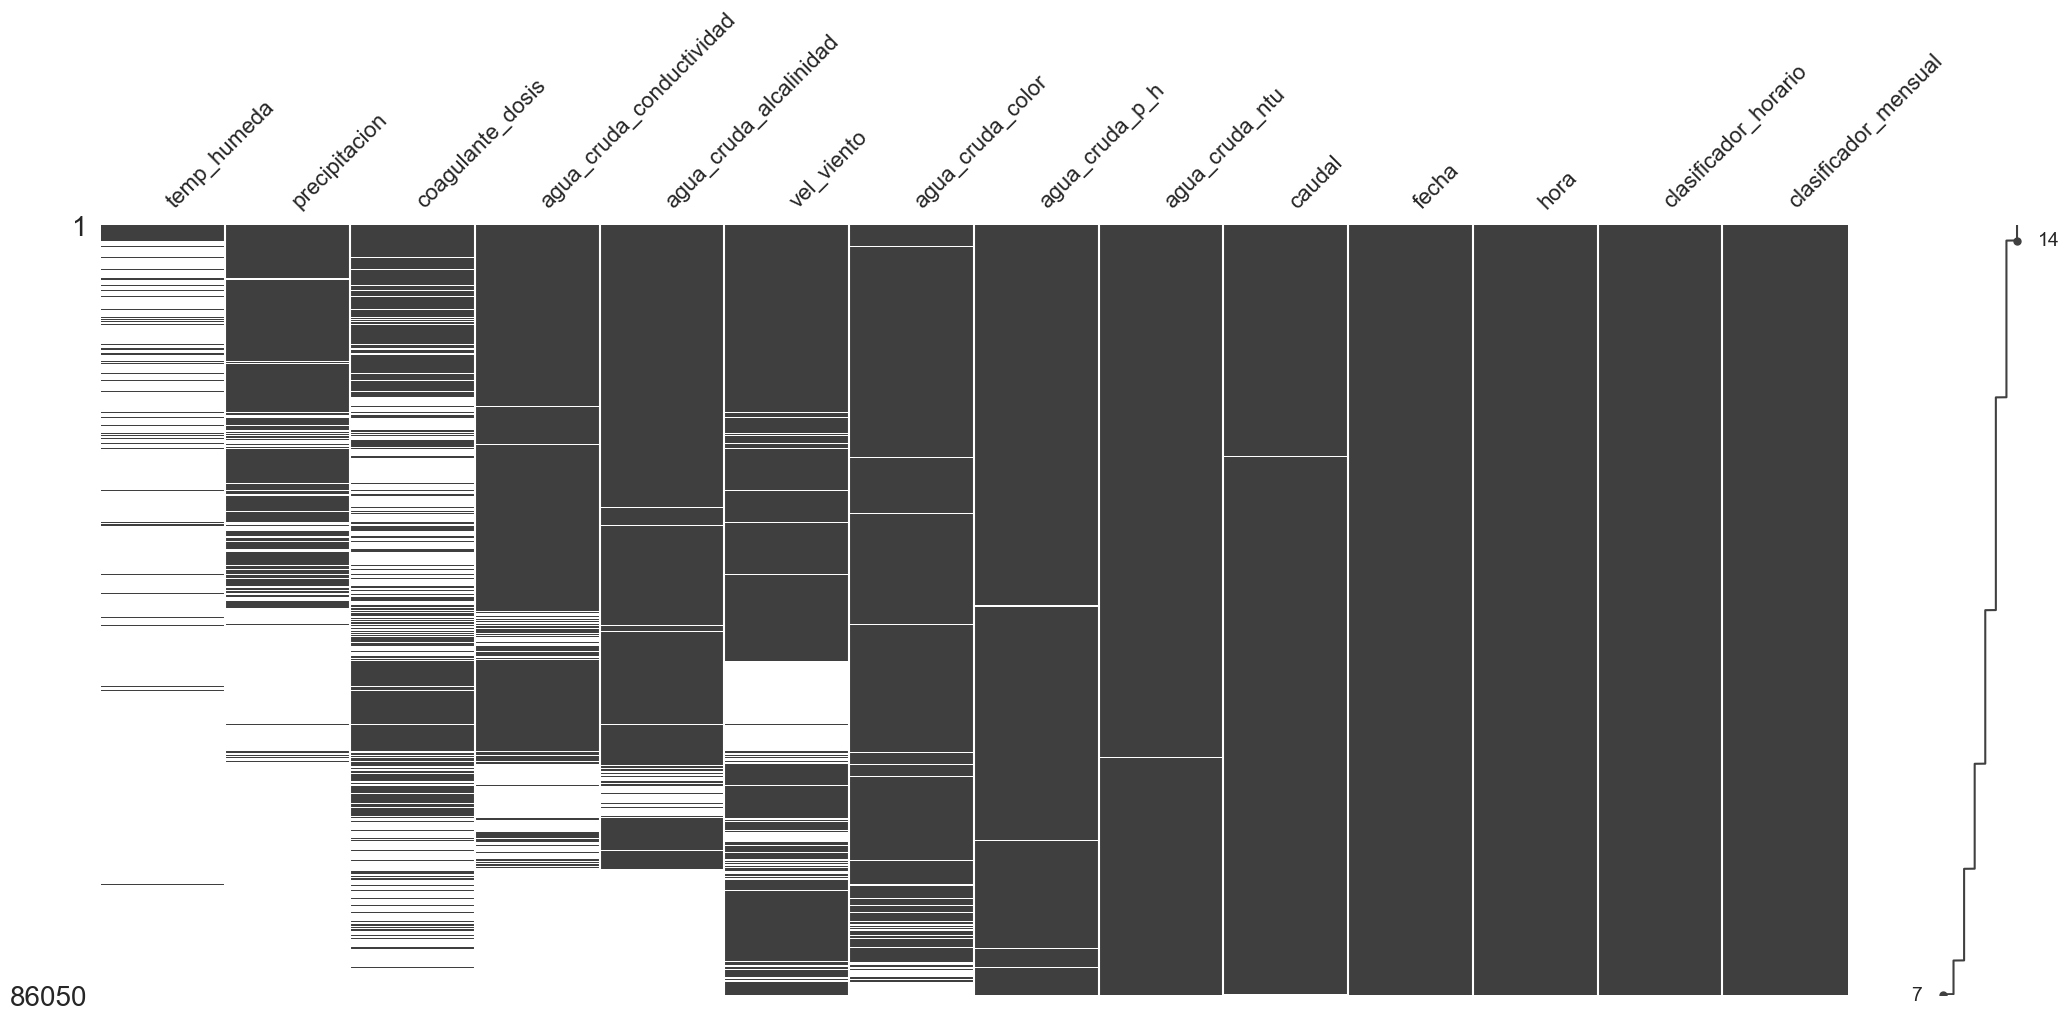

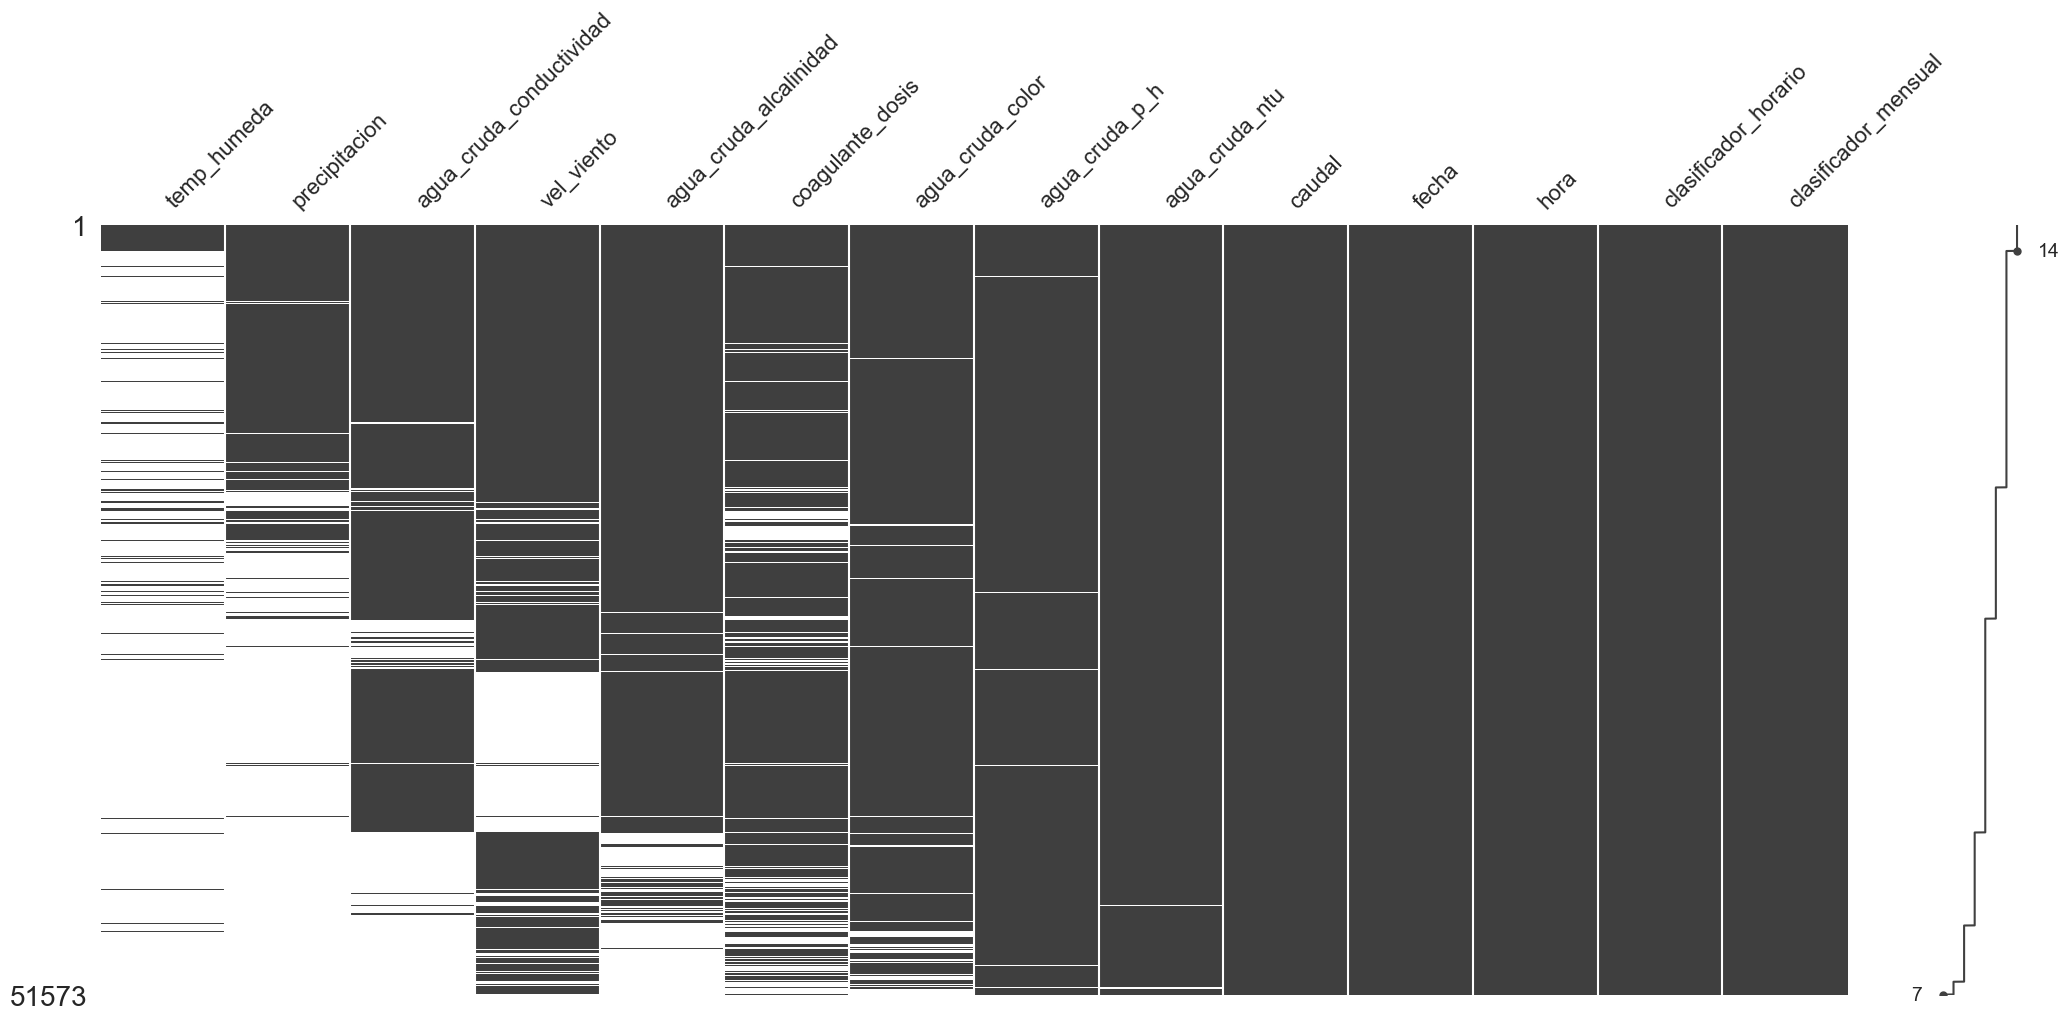

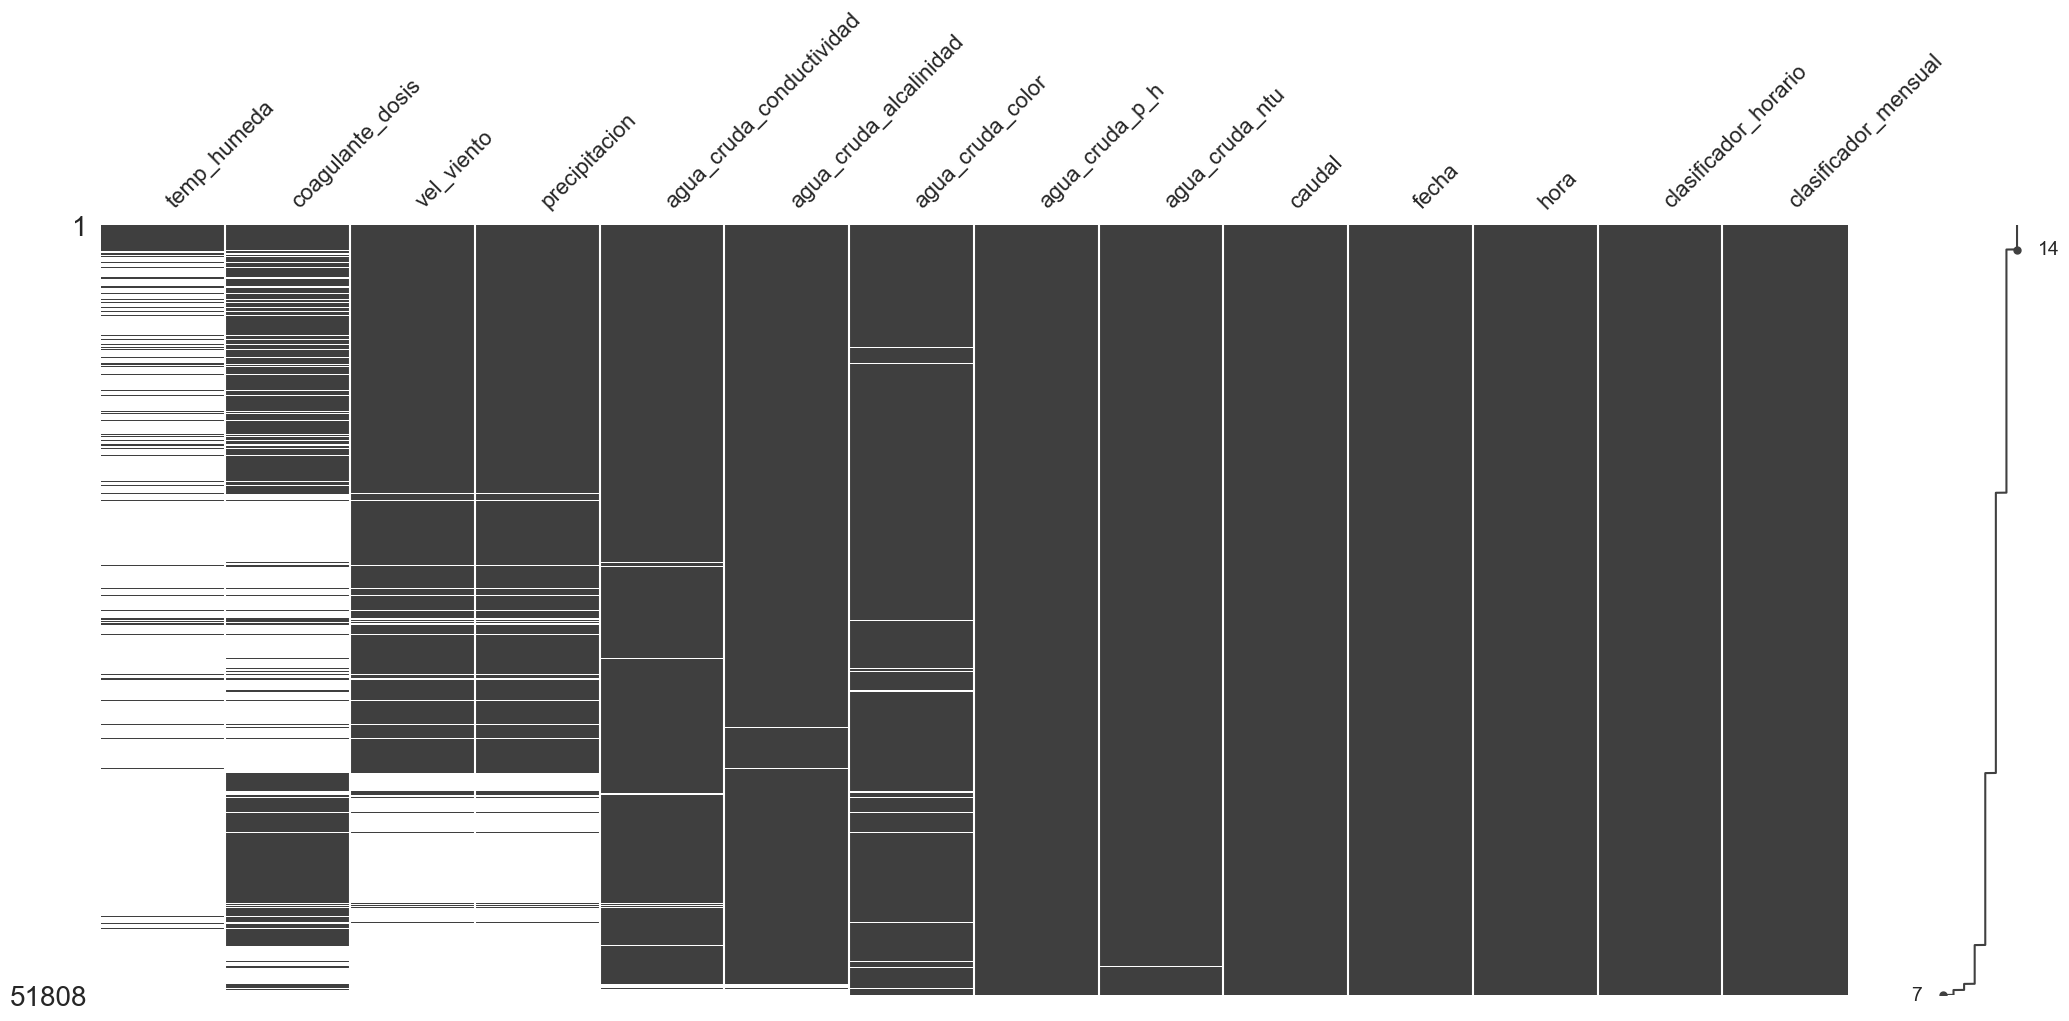

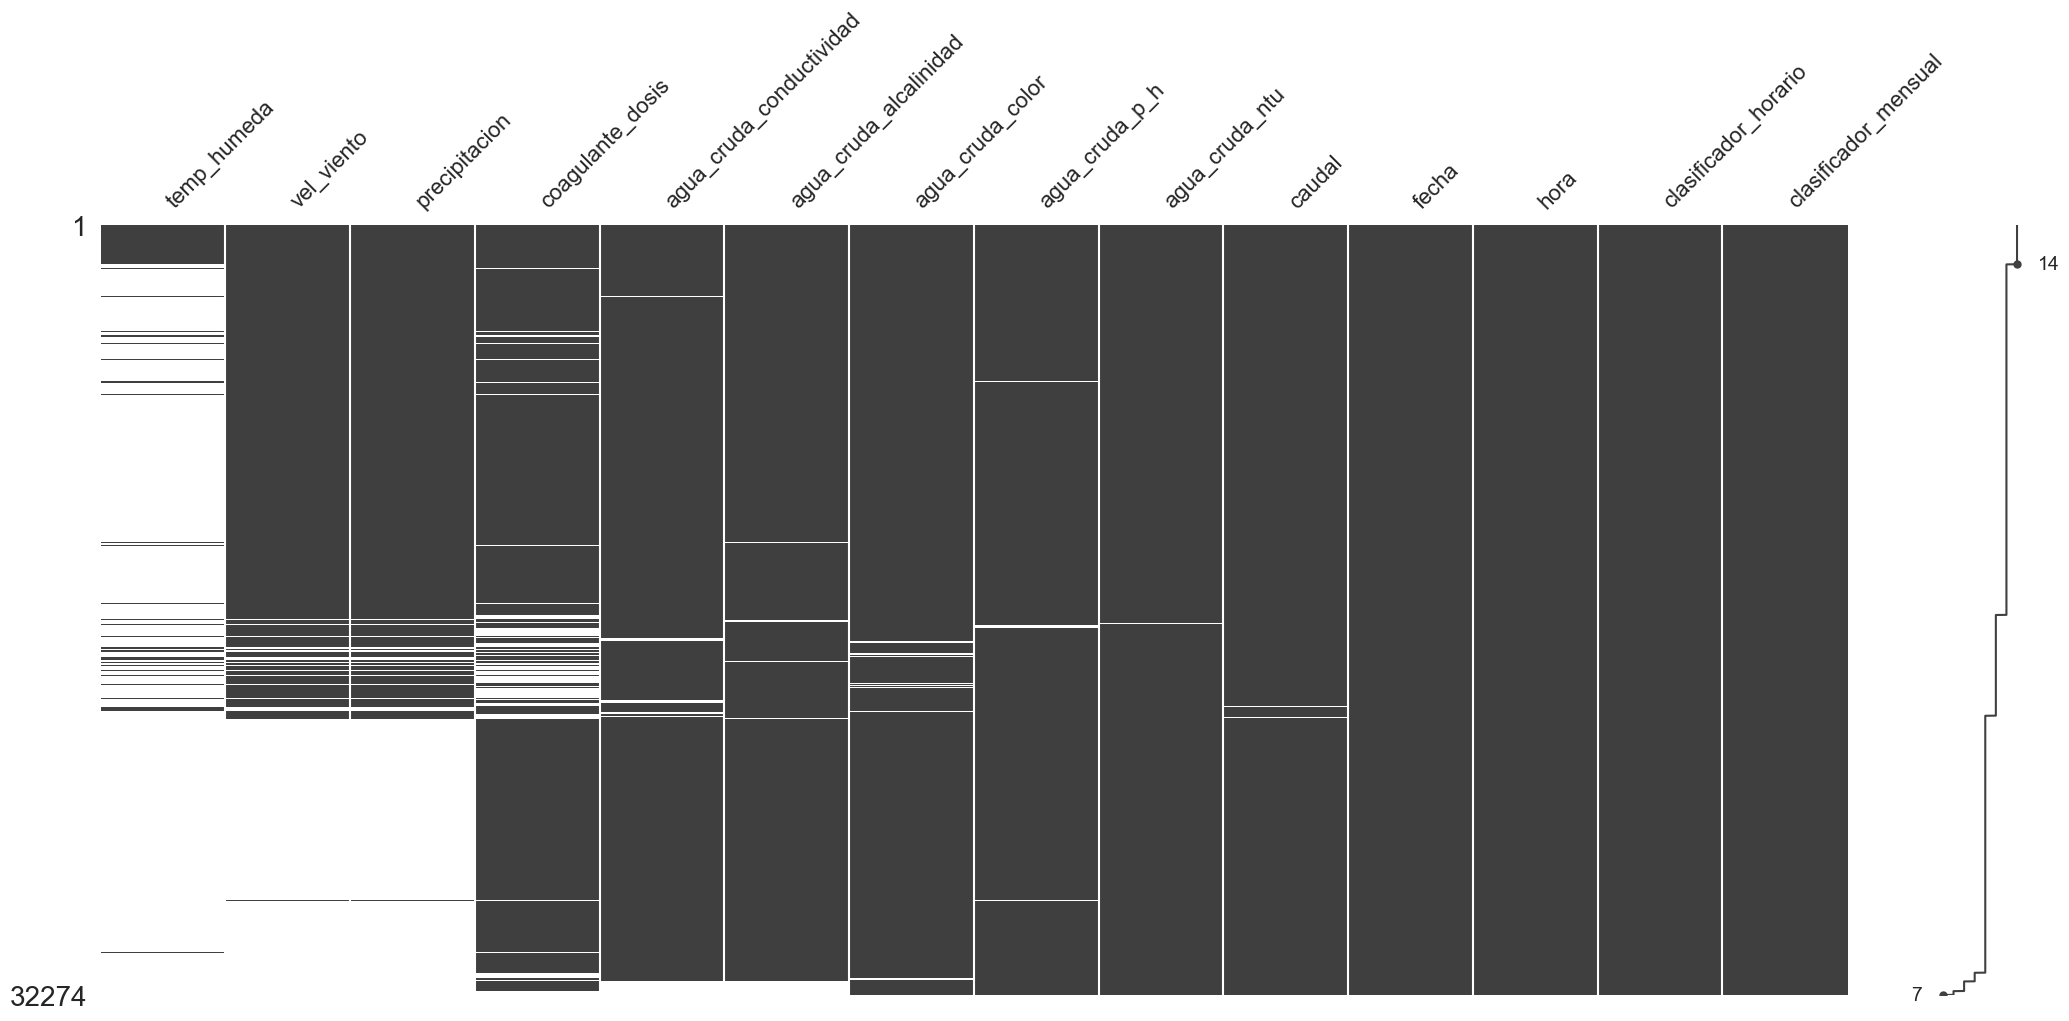

In [15]:
df_vf.pipe(missingno.matrix, sort = 'descending')
df_edit_vf.pipe(missingno.matrix, sort = 'descending')
df_2017_vf.pipe(missingno.matrix, sort = 'descending')
df_edit_2017_vf.pipe(missingno.matrix, sort = 'descending')

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

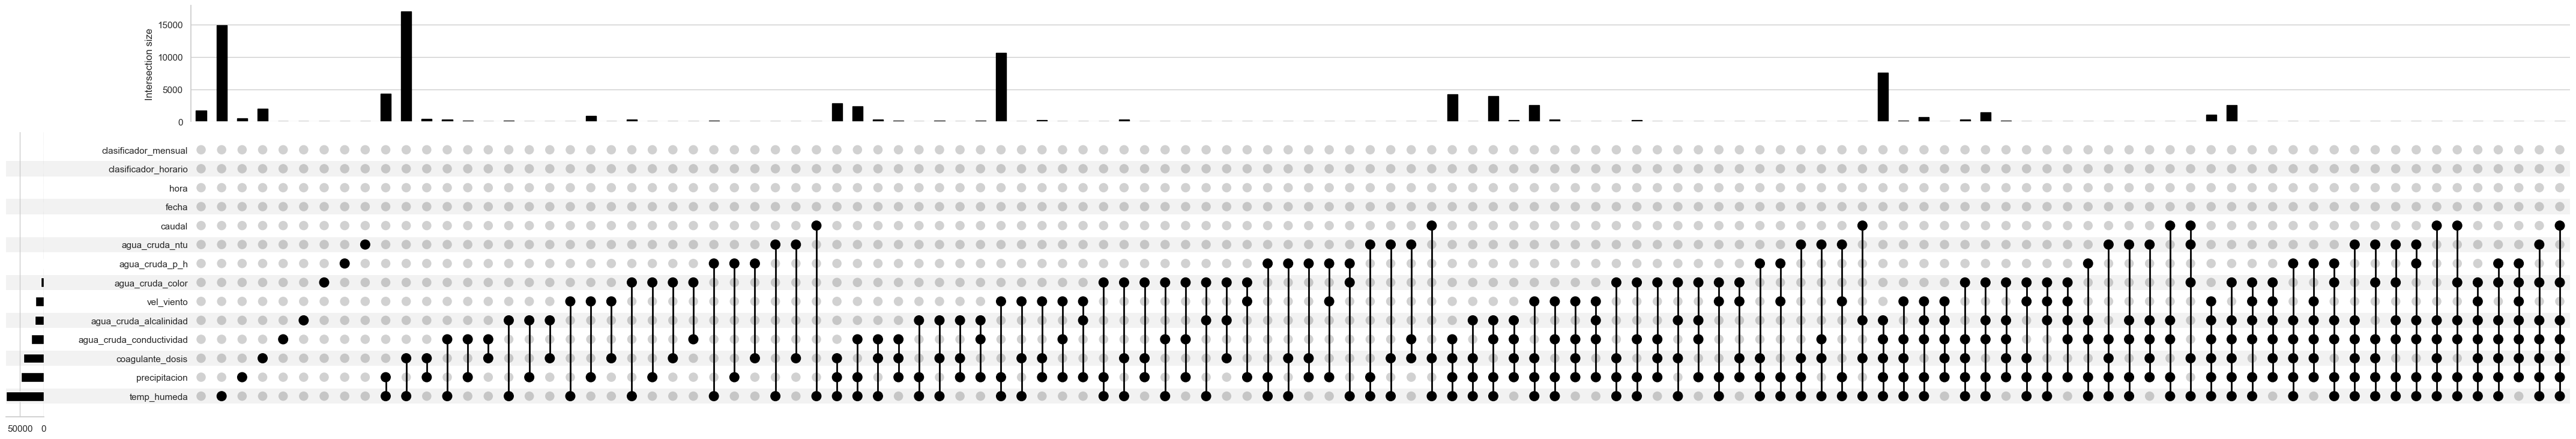

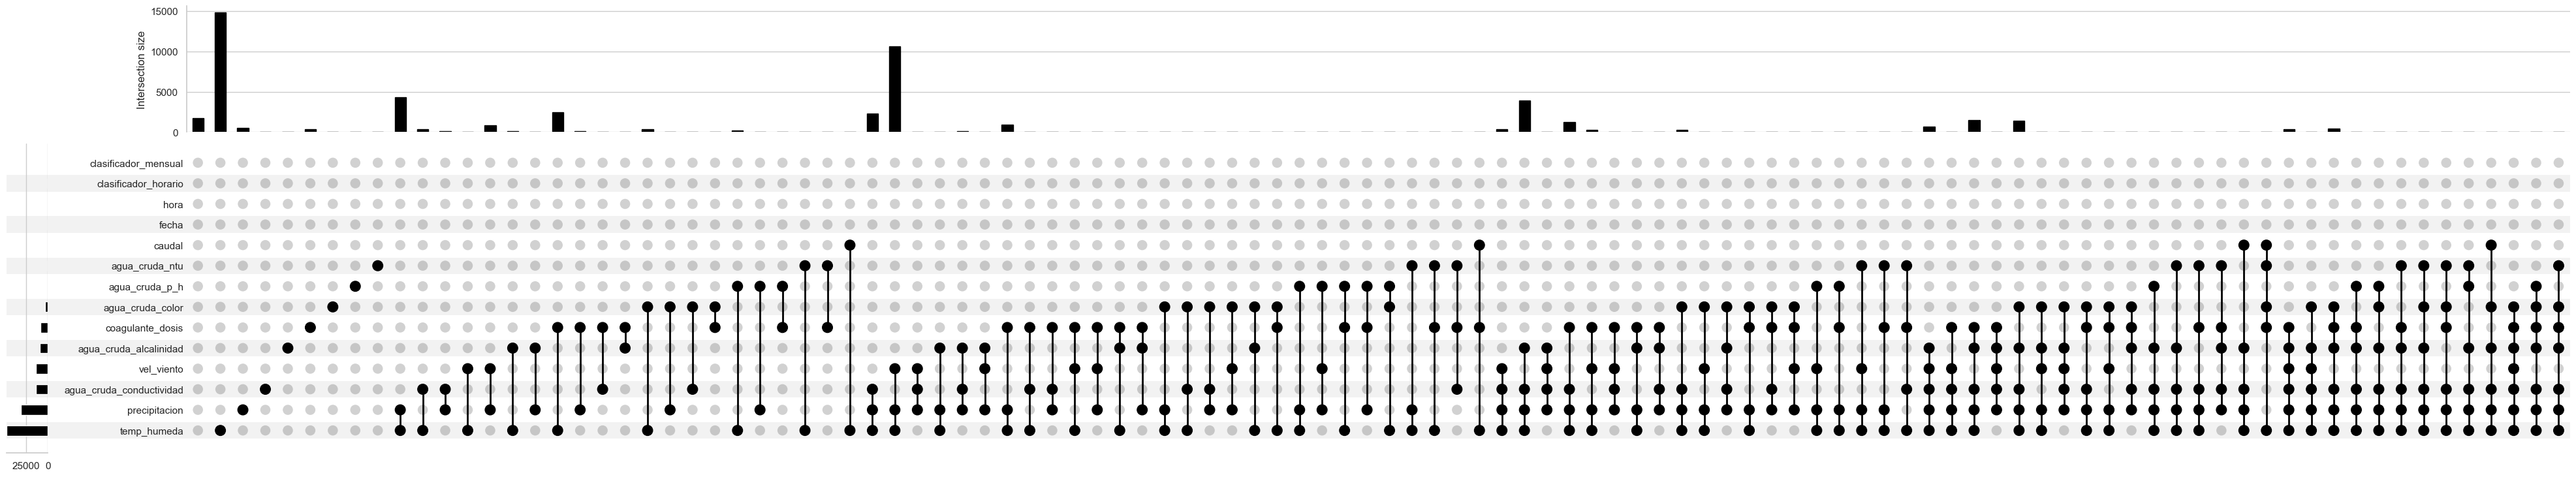

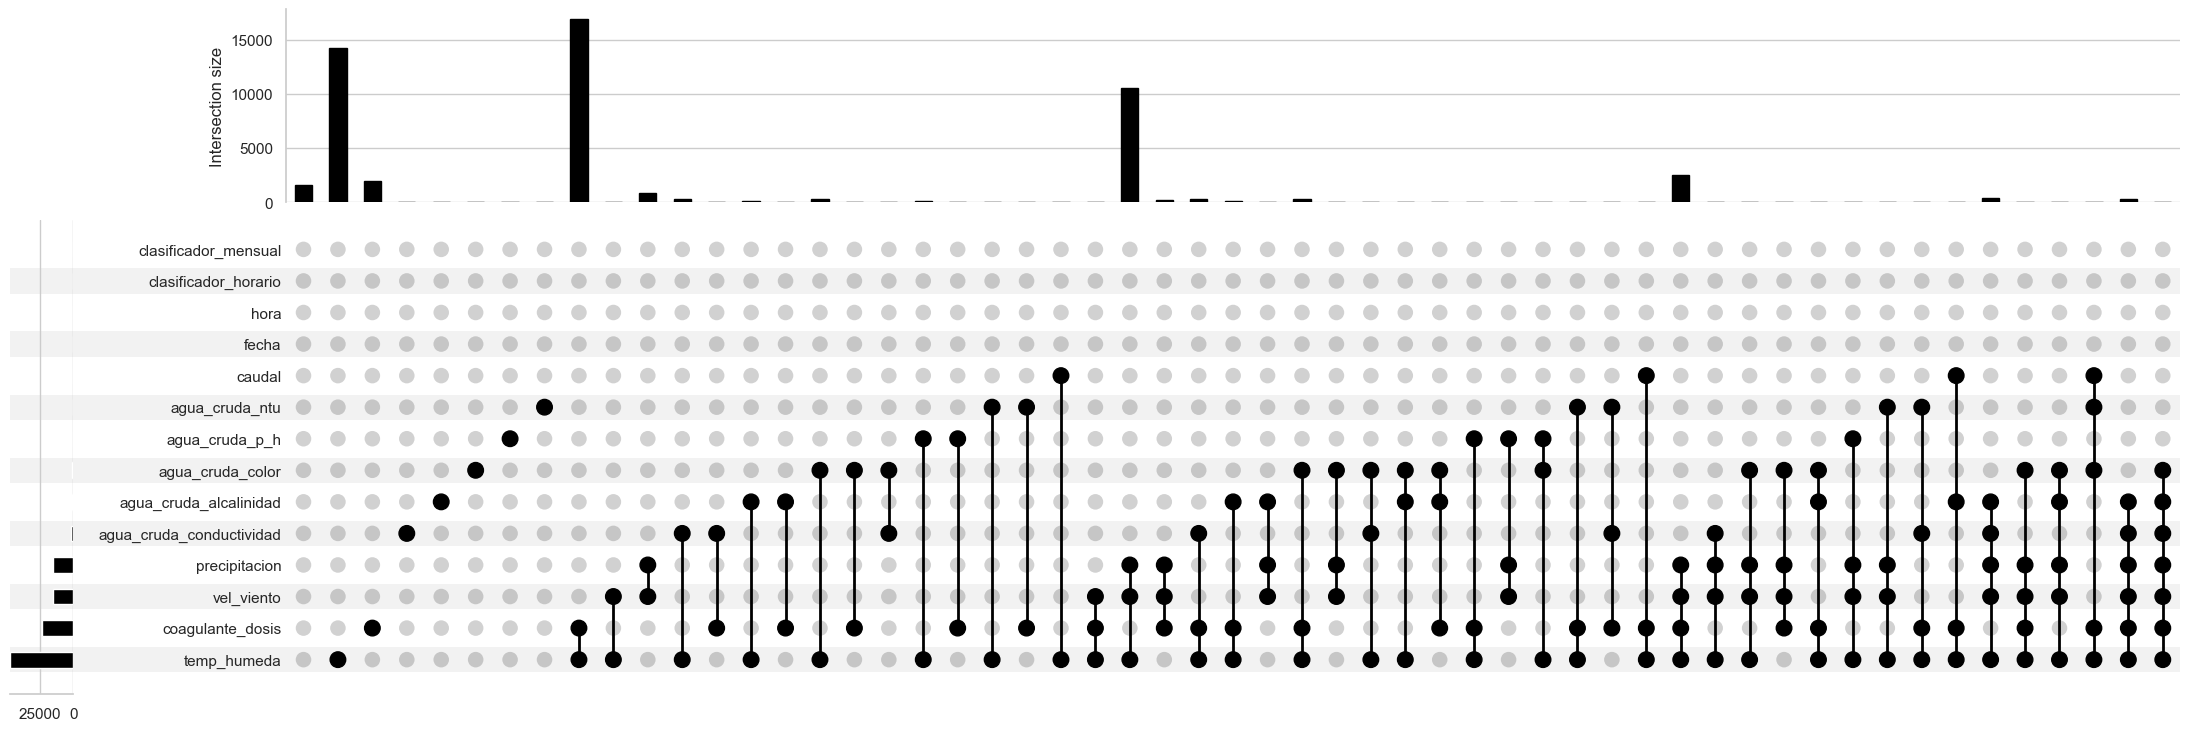

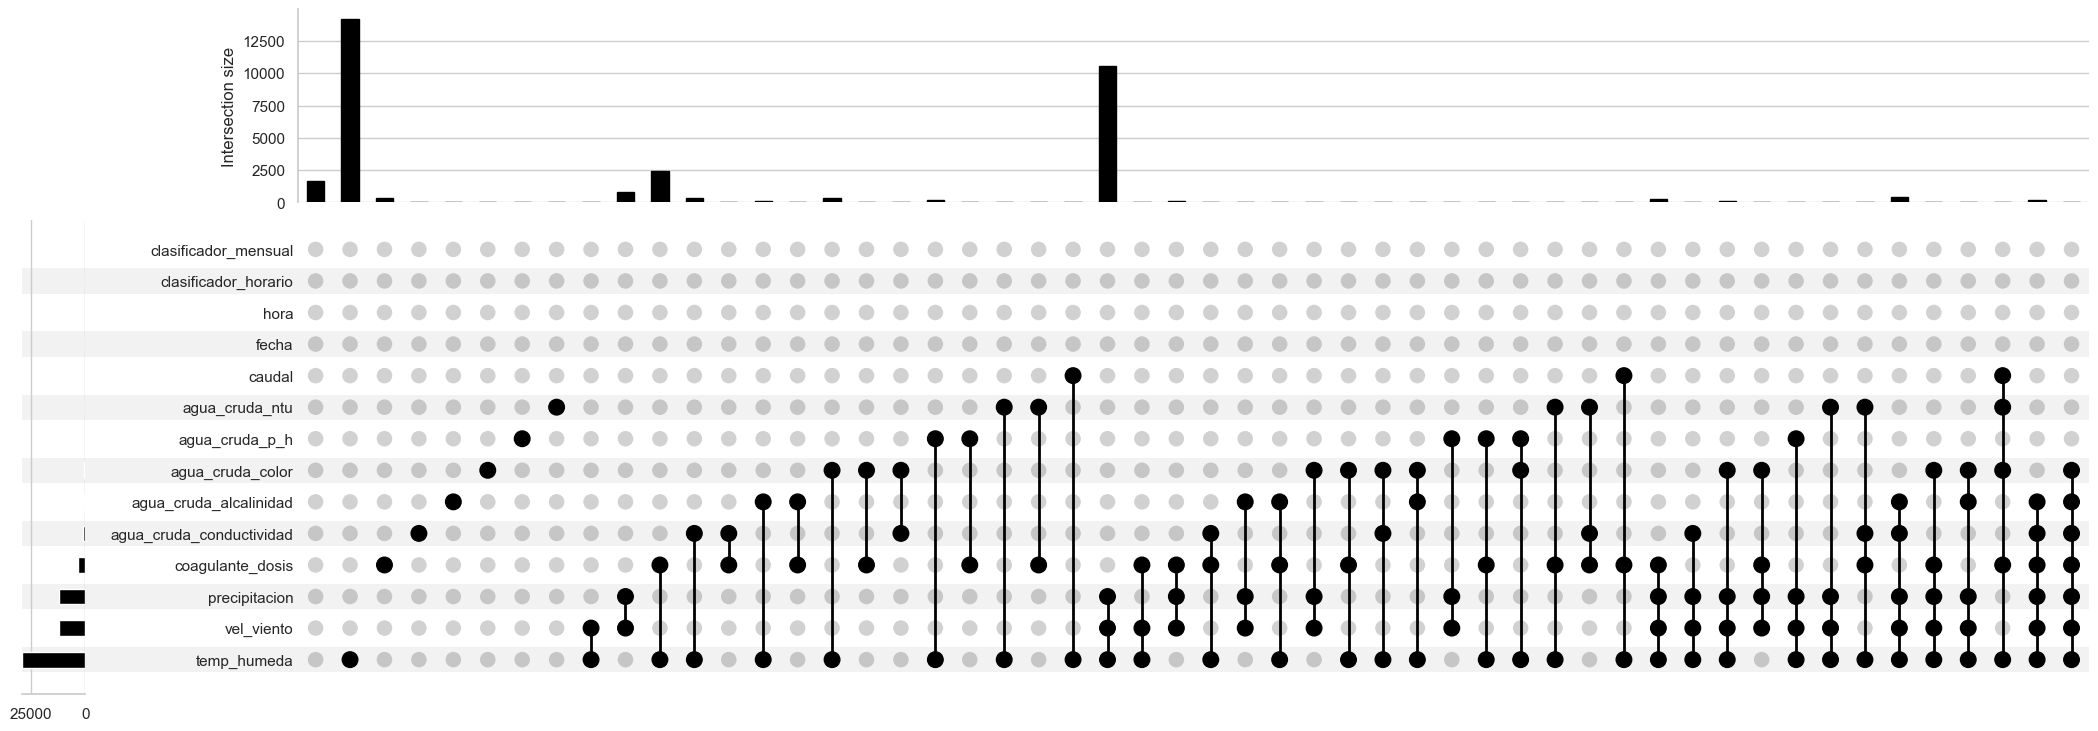

In [16]:
df_vf.missing.missing_upsetplot()
df_edit_vf.missing.missing_upsetplot()
df_2017_vf.missing.missing_upsetplot()
df_edit_2017_vf.missing.missing_upsetplot()

## Evaluación del mecanismo de valores faltantes por prueba de t-test

Esta evaluación sólo se hará para las variables `caudal`, `agua_cruda_p_h`, `agua_cruda_color`,`agua_cruda_alcalinidad`, `agua_cruda_conductivivdad`, para el dataframe que abarca los años del 2017 en adelante, para el dataframe completo se hará la evaluación para las mismas variables menos `agua_cruda_alcalinidad`, `agua_cruda_conductivivdad` debido a la falta de las mismas en los primeros años.

In [17]:
# missingno.bar(df = df)
# missingno.bar(df = df_edit)
# missingno.bar(df = df_2017)
# missingno.bar(df = df_edit_2017)

### Caudal

In [18]:
junio_septiembre, otros = (
    df
    .select_columns("clasificador_mensual","caudal")
    .transform_column(
        "caudal",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_mensual")
    .caudal
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

In [19]:
junio_septiembre_2017, otros_2017 = (
    df_2017
    .select_columns("clasificador_mensual","caudal")
    .transform_column(
        "caudal",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_mensual")
    .caudal
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

Se hace una prueba estadística para ver si existe o no una diferencia en la presencia o ausencia de valores de caudal para la variable de clasificador_mensual.

Con two-sided estamos preguntando: ¿Existe diferencia entre la presencia o ausencia de valores de medición de caudal? y si el valor es mayor a 0.05 diriamos que no, no podemos definir o rechazar la hipotesis nula de que exista una diferencia

In [20]:
scipy.stats.ttest_ind(
    a = junio_septiembre,
    b = otros,
    alternative = "two-sided"
)

Ttest_indResult(statistic=0.4715037986329904, pvalue=0.6372822031017504)

In [21]:
scipy.stats.ttest_ind(
    a = junio_septiembre_2017,
    b = otros_2017,
    alternative = "two-sided"
)

Ttest_indResult(statistic=0.18750533043834178, pvalue=0.8512651790426972)

Nuestros análisis revelan un valor de 0.6403 para el dataframe completo y de 0.8503 para el dataframe que considera los datos a partir del año 2017. Estos resultados no nos permiten rechazar la hipótesis nula, implicando que no podemos afirmar con certeza que exista una diferencia entre los valores de 'Caudal' con y sin valores faltantes. En consecuencia, podemos inferir que nuestros datos parecen estar perdidos de manera aleatoria, al menos en la categoría correspondiente a los meses de junio a septiembre y en las categoría de otros meses.

In [22]:
dia, noche = (
    df
    .select_columns("clasificador_horario","caudal")
    .transform_column(
        "caudal",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_horario")
    .caudal
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

In [23]:
dia_2017, noche_2017 = (
    df_2017
    .select_columns("clasificador_horario","caudal")
    .transform_column(
        "caudal",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_horario")
    .caudal
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

Se hace una prueba estadística para ver si existe o no una diferencia en la presencia o ausencia de valores de caudal para la variable de clasificador_horario.

In [24]:
scipy.stats.ttest_ind(
    a = dia,
    b = noche,
    alternative = "two-sided"
)

Ttest_indResult(statistic=-2.721823581919674, pvalue=0.006493585341634977)

In [25]:
scipy.stats.ttest_ind(
    a = dia_2017,
    b = noche_2017,
    alternative = "two-sided"
)

Ttest_indResult(statistic=-1.7980858051571686, pvalue=0.07216923114278471)

El resultado nos indica que tenemos un valor de 0.006522082919151407 para el dataframe comleto y 0.07239513141706938 para el dataframe a partir del 2017.

Luego de llevar a cabo la prueba t de Student sobre nuestras variables categóricas, observamos que los p-valores obtenidos son superiores a 0.05 para los datos correspondientes a los años a partir de 2017. Sin embargo, para el caso del dataframe completo, el p-valor es inferior a 0.05 en relación con la variable `clasificador_horario` para `caudal`. Aunado a esto, notamos que el volumen de datos ausentes para `caudal` es mínimo. Al considerar estos factores y la información proporcionada por el ingeniero Mauricio, hemos decidido categorizar la falta de datos en la columna `caudal` como un caso de **MAR (Missing at Random).**

### AGUA_CRUDA_P_H

In [26]:
junio_septiembre, otros = (
    df
    .select_columns("clasificador_mensual","agua_cruda_p_h")
    .transform_column(
        "agua_cruda_p_h",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_mensual")
    .agua_cruda_p_h
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

In [27]:
junio_septiembre_2017, otros_2017 = (
    df_2017
    .select_columns("clasificador_mensual","agua_cruda_p_h")
    .transform_column(
        "agua_cruda_p_h",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_mensual")
    .agua_cruda_p_h
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

Se hace una prueba estadística para ver si existe o no una diferencia en la presencia o ausencia de valores de agua_cruda_p_h para la variable de clasificador_mensual.

In [28]:
scipy.stats.ttest_ind(
    a = junio_septiembre,
    b = otros,
    alternative = "two-sided"
)

Ttest_indResult(statistic=-11.720165118260631, pvalue=1.0621597260474498e-31)

In [29]:
scipy.stats.ttest_ind(
    a = junio_septiembre_2017,
    b = otros_2017,
    alternative = "two-sided"
)

Ttest_indResult(statistic=-9.629824013358403, pvalue=6.241946833361501e-22)

Nuestros análisis revelan un valor de 8.975030413664003e-32 para el dataframe completo y de 6.50435246261715e-22 para el dataframe que considera los datos a partir del año 2017. Estos resultados nos permiten rechazar la hipótesis nula, implicando que podemos afirmar que existe una diferencia entre los valores de 'agua_cruda_p_h' con y sin valores faltantes. En consecuencia, podemos inferir que nuestros datos parecen estar perdidos de manera no aleatoria, al menos en la categoría correspondiente a los meses de junio a septiembre y en las categoría de otros meses.

In [30]:
dia, noche = (
    df
    .select_columns("clasificador_horario","agua_cruda_p_h")
    .transform_column(
        "agua_cruda_p_h",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_horario")
    .agua_cruda_p_h
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

In [31]:
dia_2017, noche_2017 = (
    df_2017
    .select_columns("clasificador_horario","agua_cruda_p_h")
    .transform_column(
        "agua_cruda_p_h",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_horario")
    .agua_cruda_p_h
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

Se hace una prueba estadística para ver si existe o no una diferencia en la presencia o ausencia de valores de agua_cruda_p_h para la variable de clasificador_horario.

In [32]:
scipy.stats.ttest_ind(
    a = dia,
    b = noche,
    alternative = "two-sided"
)

Ttest_indResult(statistic=0.5069465899112424, pvalue=0.612193593501323)

In [33]:
scipy.stats.ttest_ind(
    a = dia_2017,
    b = noche_2017,
    alternative = "two-sided"
)

Ttest_indResult(statistic=1.4850112723854483, pvalue=0.13754692258523604)

Nuestros análisis revelan un valor de 0.6079365356487716 para el dataframe completo y de 0.13589282810931883 para el dataframe que considera los datos a partir del año 2017. Estos resultados no nos permiten rechazar la hipótesis nula, implicando que no podemos afirmar que existe una diferencia entre los valores de 'agua_cruda_p_h' con y sin valores faltantes. En consecuencia, podemos inferir que nuestros datos parecen estar perdidos de manera aleatoria, al menos en la categoría correspondiente a los meses de dia y noche.

Luego de llevar a cabo la prueba t de Student sobre nuestras variables categóricas, observamos que los p-valores obtenidos son superiores a 0.05 para los datos correspondientes a los años a partir de 2017. Sin embargo, para el caso del dataframe completo, el p-valor es inferior a 0.05. Aunado a esto, notamos que el volumen de datos ausentes para `agua_cruda_p_h` es mínimo. Al considerar estos factores y la información proporcionada por el ingeniero Mauricio, hemos decidido categorizar la falta de datos en la columna `agua_cruda_p_h` como un caso de **MAR (Missing at Random).**

### AGUA_CRUDA_COLOR

In [34]:
junio_septiembre, otros = (
    df
    .select_columns("clasificador_mensual","agua_cruda_color")
    .transform_column(
        "agua_cruda_color",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_mensual")
    .agua_cruda_color
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

In [35]:
junio_septiembre_2017, otros_2017 = (
    df_2017
    .select_columns("clasificador_mensual","agua_cruda_color")
    .transform_column(
        "agua_cruda_color",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_mensual")
    .agua_cruda_color
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

Se hace una prueba estadística para ver si existe o no una diferencia en la presencia o ausencia de valores de agua_cruda_color para la variable de clasificador_mensual.

In [36]:
scipy.stats.ttest_ind(
    a = junio_septiembre,
    b = otros,
    alternative = "two-sided"
)

Ttest_indResult(statistic=23.819409137967458, pvalue=5.351603879706066e-125)

In [37]:
scipy.stats.ttest_ind(
    a = junio_septiembre_2017,
    b = otros_2017,
    alternative = "two-sided"
)

Ttest_indResult(statistic=17.0726254885688, pvalue=3.579914051739629e-65)

Nuestros análisis revelan un valor de 4.914429581957408e-124 para el dataframe completo y de 2.902675783786543e-65 para el dataframe que considera los datos a partir del año 2017. Estos resultados nos permiten rechazar la hipótesis nula, implicando que podemos afirmar que existe una diferencia entre los valores de 'agua_cruda_color' con y sin valores faltantes. En consecuencia, podemos inferir que nuestros datos parecen estar perdidos de manera no aleatoria, al menos en la categoría correspondiente a los meses de junio a septiembre y en las categoría de otros meses.

In [38]:
dia, noche = (
    df
    .select_columns("clasificador_horario","agua_cruda_color")
    .transform_column(
        "agua_cruda_color",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_horario")
    .agua_cruda_color
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

In [39]:
dia_2017, noche_2017 = (
    df_2017
    .select_columns("clasificador_horario","agua_cruda_color")
    .transform_column(
        "agua_cruda_color",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_horario")
    .agua_cruda_color
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

Se hace una prueba estadística para ver si existe o no una diferencia en la presencia o ausencia de valores de agua_cruda_color para la variable de clasificador_horario.

In [40]:
scipy.stats.ttest_ind(
    a = dia,
    b = noche,
    alternative = "two-sided"
)

Ttest_indResult(statistic=-2.3532928739827397, pvalue=0.018610208683576095)

In [41]:
scipy.stats.ttest_ind(
    a = dia_2017,
    b = noche_2017,
    alternative = "two-sided"
)

Ttest_indResult(statistic=-1.2821280513373057, pvalue=0.19980346745942784)

Nuestro análisis genera valores de 0.016036972853589827 para el dataframe completo y de 0.20413340119845308 para el dataframe que recopila datos a partir del año 2017. Basándonos en estos resultados, nos vemos en la capacidad de rechazar la hipótesis nula para el dataframe completo, pero no para el dataframe con datos a partir del 2017. Esto implica que podemos afirmar la existencia de una diferencia significativa entre los valores de 'agua_cruda_color' que tienen y no tienen datos faltantes en el caso del dataframe completo, mientras que no podemos afirmar lo mismo para el dataframe con datos a partir del 2017. En consecuencia, la inferencia es que nuestros datos parecen faltar de manera no aleatoria para el dataframe completo, específicamente en la categoría correspondiente a los datos de día y noche, mientras que para el dataframe a partir del 2017, los datos parecen faltar de manera aleatoria.

Luego de llevar a cabo la prueba t de Student sobre nuestras variables categóricas, observamos que los p-valores obtenidos son superiores a 0.05 para los datos correspondientes a los años a partir de 2017 para la categoría de `clasificador_horario`. Sin embargo, para el caso del dataframe completo, el p-valor es inferior a 0.05. Aunado a esto, notamos que el volumen de datos ausentes para `agua_cruda_color` es mínimo. Al considerar estos factores y la información proporcionada por el ingeniero Mauricio, hemos decidido categorizar la falta de datos en la columna `agua_cruda_color` como un caso de **MAR (Missing at Random).**

### AGUA_CRUDA_NTU

In [42]:
junio_septiembre, otros = (
    df
    .select_columns("clasificador_mensual","agua_cruda_ntu")
    .transform_column(
        "agua_cruda_ntu",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_mensual")
    .agua_cruda_ntu
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

In [43]:
junio_septiembre_2017, otros_2017 = (
    df_2017
    .select_columns("clasificador_mensual","agua_cruda_ntu")
    .transform_column(
        "agua_cruda_ntu",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_mensual")
    .agua_cruda_ntu
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

Se hace una prueba estadística para ver si existe o no una diferencia en la presencia o ausencia de valores de agua_cruda_ntu para la variable de clasificador_horario.

In [44]:
scipy.stats.ttest_ind(
    a = dia,
    b = noche,
    alternative = "two-sided"
)

Ttest_indResult(statistic=-2.3532928739827397, pvalue=0.018610208683576095)

In [45]:
scipy.stats.ttest_ind(
    a = dia_2017,
    b = noche_2017,
    alternative = "two-sided"
)

Ttest_indResult(statistic=-1.2821280513373057, pvalue=0.19980346745942784)

### AGUA_CRUDA_ALCALINIDAD

In [46]:
junio_septiembre_2017, otros_2017 = (
    df_2017
    .select_columns("clasificador_mensual","agua_cruda_alcalinidad")
    .transform_column(
        "agua_cruda_alcalinidad",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_mensual")
    .agua_cruda_alcalinidad
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

Se hace una prueba estadística para ver si existe o no una diferencia en la presencia o ausencia de valores de agua_cruda_alcalinidad para la variable de clasificador_mensual.

In [47]:
scipy.stats.ttest_ind(
    a = junio_septiembre_2017,
    b = otros_2017,
    alternative = "two-sided"
)

Ttest_indResult(statistic=-18.60921119932893, pvalue=4.83002196751327e-77)

In [48]:
dia_2017, noche_2017 = (
    df_2017
    .select_columns("clasificador_horario","agua_cruda_alcalinidad")
    .transform_column(
        "agua_cruda_alcalinidad",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_horario")
    .agua_cruda_alcalinidad
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

In [49]:
scipy.stats.ttest_ind(
    a = dia_2017,
    b = noche_2017,
    alternative = "two-sided"
)

Ttest_indResult(statistic=0.05647406673606215, pvalue=0.9549643720826931)

Nuestro análisis genera valores de 5.7282685620592e-77 para las categorías de clasificador_mensual y de 0.9444951841961977 para las categorías de clasificador_horario. Basándonos en estos resultados, nos vemos en la capacidad de rechazar la hipótesis nula para las categorías de clasificador_horario, pero no para las categorías de clasificador_mensual. Esto implica que podemos afirmar la existencia de una diferencia significativa entre los valores de 'clasificador_mensual' que tienen y no tienen datos faltantes para las categorías de clasificador_horario, mientras que no podemos afirmar lo mismo para las categorías de clasificador_mensual. En consecuencia, la inferencia es que nuestros datos parecen faltar de manera no aleatoria para las categorías de clasificador_horario, mientras que para las categorías de clasificador_mensual, los datos parecen faltar de manera aleatoria.

Luego de llevar a cabo la prueba t de Student sobre nuestras variables categóricas y notar que el volumen de datos ausentes para `agua_cruda_alcalinidad` es mínimo. Al considerar estos factores y la información proporcionada por el ingeniero Mauricio, hemos decidido categorizar la falta de datos en la columna `agua_cruda_alcalinidad` como un caso de **MAR (Missing at Random).**

### AGUA_CRUDA_CONDUCTIVIDAD

In [50]:
junio_septiembre_2017, otros_2017 = (
    df_2017
    .select_columns("clasificador_mensual","agua_cruda_conductividad")
    .transform_column(
        "agua_cruda_conductividad",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_mensual")
    .agua_cruda_conductividad
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

Se hace una prueba estadística para ver si existe o no una diferencia en la presencia o ausencia de valores de agua_cruda_conductividad para la variable de clasificador_mensual.

In [51]:
scipy.stats.ttest_ind(
    a = junio_septiembre_2017,
    b = otros_2017,
    alternative = "two-sided"
)

Ttest_indResult(statistic=-12.68272229892441, pvalue=8.36381458702704e-37)

In [52]:
dia_2017, noche_2017 = (
    df_2017
    .select_columns("clasificador_horario","agua_cruda_conductividad")
    .transform_column(
        "agua_cruda_conductividad",
        lambda x: x.isna(),
        elementwise = False # Para que regrese una serie
    )
    .groupby("clasificador_horario")
    .agua_cruda_conductividad
    .pipe(
        lambda df: (
            df.get_group(0),
            df.get_group(1)
        )
    )
)

In [53]:
scipy.stats.ttest_ind(
    a = dia_2017,
    b = noche_2017,
    alternative = "two-sided"
)

Ttest_indResult(statistic=0.3161462801245661, pvalue=0.7518927539604754)

Nuestro análisis genera valores de 9.77966788253476e-37 para las categorías de clasificador_mensual y de 0.7397644221322179 para las categorías de clasificador_horario. Basándonos en estos resultados, nos vemos en la capacidad de rechazar la hipótesis nula para las categorías de clasificador_horario, pero no para las categorías de clasificador_mensual. Esto implica que podemos afirmar la existencia de una diferencia significativa entre los valores de 'clasificador_mensual' que tienen y no tienen datos faltantes para las categorías de clasificador_horario, mientras que no podemos afirmar lo mismo para las categorías de clasificador_mensual. En consecuencia, la inferencia es que nuestros datos parecen faltar de manera no aleatoria para las categorías de clasificador_horario, mientras que para las categorías de clasificador_mensual, los datos parecen faltar de manera aleatoria.

Luego de llevar a cabo la prueba t de Student sobre nuestras variables categóricas y notar que el volumen de datos ausentes para `agua_cruda_conductividad` es mínimo. Al considerar estos factores y la información proporcionada por el ingeniero Mauricio, hemos decidido categorizar la falta de datos en la columna `agua_cruda_conductividad` como un caso de **MAR (Missing at Random).**

Para las anteriores variables se realizará imputación por interpolación para todas en los dataframes que recopila datos a partir del año 2017 y para los dataframes completos se imputaran las variables de alcalinidad y conductividad con imputación por modelos y las demás por imputación por interpolación.

In [54]:
def plot_histograms(df1, df2, column, bins=10):
    fig, axs = plt.subplots(2, figsize=(10, 6))

    # Hacer el histograma para df1
    axs[0].hist(df1[column].dropna(), bins=bins, color='blue', alpha=0.7)
    axs[0].set_title(f'Histograma de {column} en el primer dataframe')

    # Hacer el histograma para df2
    axs[1].hist(df2[column].dropna(), bins=bins, color='green', alpha=0.7)
    axs[1].set_title(f'Histograma de {column} en el segundo dataframe')

    # Ajustar el espacio entre los subplots
    plt.tight_layout()
    plt.show()


In [55]:
# Crear una columna temporal 'hora' que contenga objetos Timedelta representando las horas
df['temp_hora'] = pd.to_timedelta(df['hora'], unit='h')
# Crear una nueva columna 'fecha_hora' sumando las columnas 'fecha' y 'temp_hora'
df['fecha_hora'] = df['fecha'] + df['temp_hora']
# Establecer 'fecha_hora' como el índice
df_imputed = df.set_index('fecha_hora')

# Repetir el mismo proceso para los demás DataFrames
df_edit['temp_hora'] = pd.to_timedelta(df_edit['hora'], unit='h')
df_edit['fecha_hora'] = df_edit['fecha'] + df_edit['temp_hora']
df_imputed_edit = df_edit.set_index('fecha_hora')

df_2017['temp_hora'] = pd.to_timedelta(df_2017['hora'], unit='h')
df_2017['fecha_hora'] = df_2017['fecha'] + df_2017['temp_hora']
df_imputed_2017 = df_2017.set_index('fecha_hora')

df_edit_2017['temp_hora'] = pd.to_timedelta(df_edit_2017['hora'], unit='h')
df_edit_2017['fecha_hora'] = df_edit_2017['fecha'] + df_edit_2017['temp_hora']
df_imputed_edit_2017 = df_edit_2017.set_index('fecha_hora')

df_imputed = df_imputed.drop(columns=['temp_hora', 'fecha', 'hora'])
df_imputed_edit = df_imputed_edit.drop(columns=['temp_hora', 'fecha', 'hora'])
df_imputed_2017 = df_imputed_2017.drop(columns=['temp_hora', 'fecha', 'hora'])
df_imputed_edit_2017 = df_imputed_edit_2017.drop(columns=['temp_hora', 'fecha', 'hora'])

In [56]:
df_imputed = df_imputed.sort_index()
df_imputed_edit = df_imputed_edit.sort_index()
df_imputed_2017 = df_imputed_2017.sort_index()
df_imputed_edit_2017 = df_imputed_edit_2017.sort_index()

In [57]:
# df_imputed = df.set_index('fecha')
# df_imputed_edit = df_edit.set_index('fecha')
# df_imputed_2017 = df_2017.set_index('fecha')
# df_imputed_edit_2017 = df_edit_2017.set_index('fecha')

In [58]:
def impute_and_plot(df, group_col, value_col):
    # Extraemos los grupos únicos
    grupos = df[group_col].unique()

    # Creando un DataFrame vacío para almacenar los resultados
    df_impute = pd.DataFrame()

    for grupo in grupos:
        # Subconjunto de datos para cada 'grupo'
        df_grupo = df[df[group_col] == grupo]
    
        # Rastrear las ubicaciones de los valores perdidos
        missing_locs = df_grupo[value_col].isna()
    
        # Realizar la interpolación en este grupo
        df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
        
        # Asignar los valores imputados a una nueva columna
        df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
    
        # Añadir este grupo a df_impute
        df_impute = pd.concat([df_impute, df_grupo])

    # Ordenar el DataFrame por índice después de concatenar
    df_impute = df_impute.sort_index()

    # Ahora procedemos a visualizar los resultados
    plt.figure(figsize=(30,10))
    df_impute[value_col].plot(color = "#313638", marker = "o")
    df_impute['imputed_values'].plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed")
    plt.show()
    
    # Aquí devolvemos el DataFrame sin la columna 'imputed_values'
    return df_impute.drop(columns=['imputed_values'])

### CAUDAL

**Dataframes completos**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

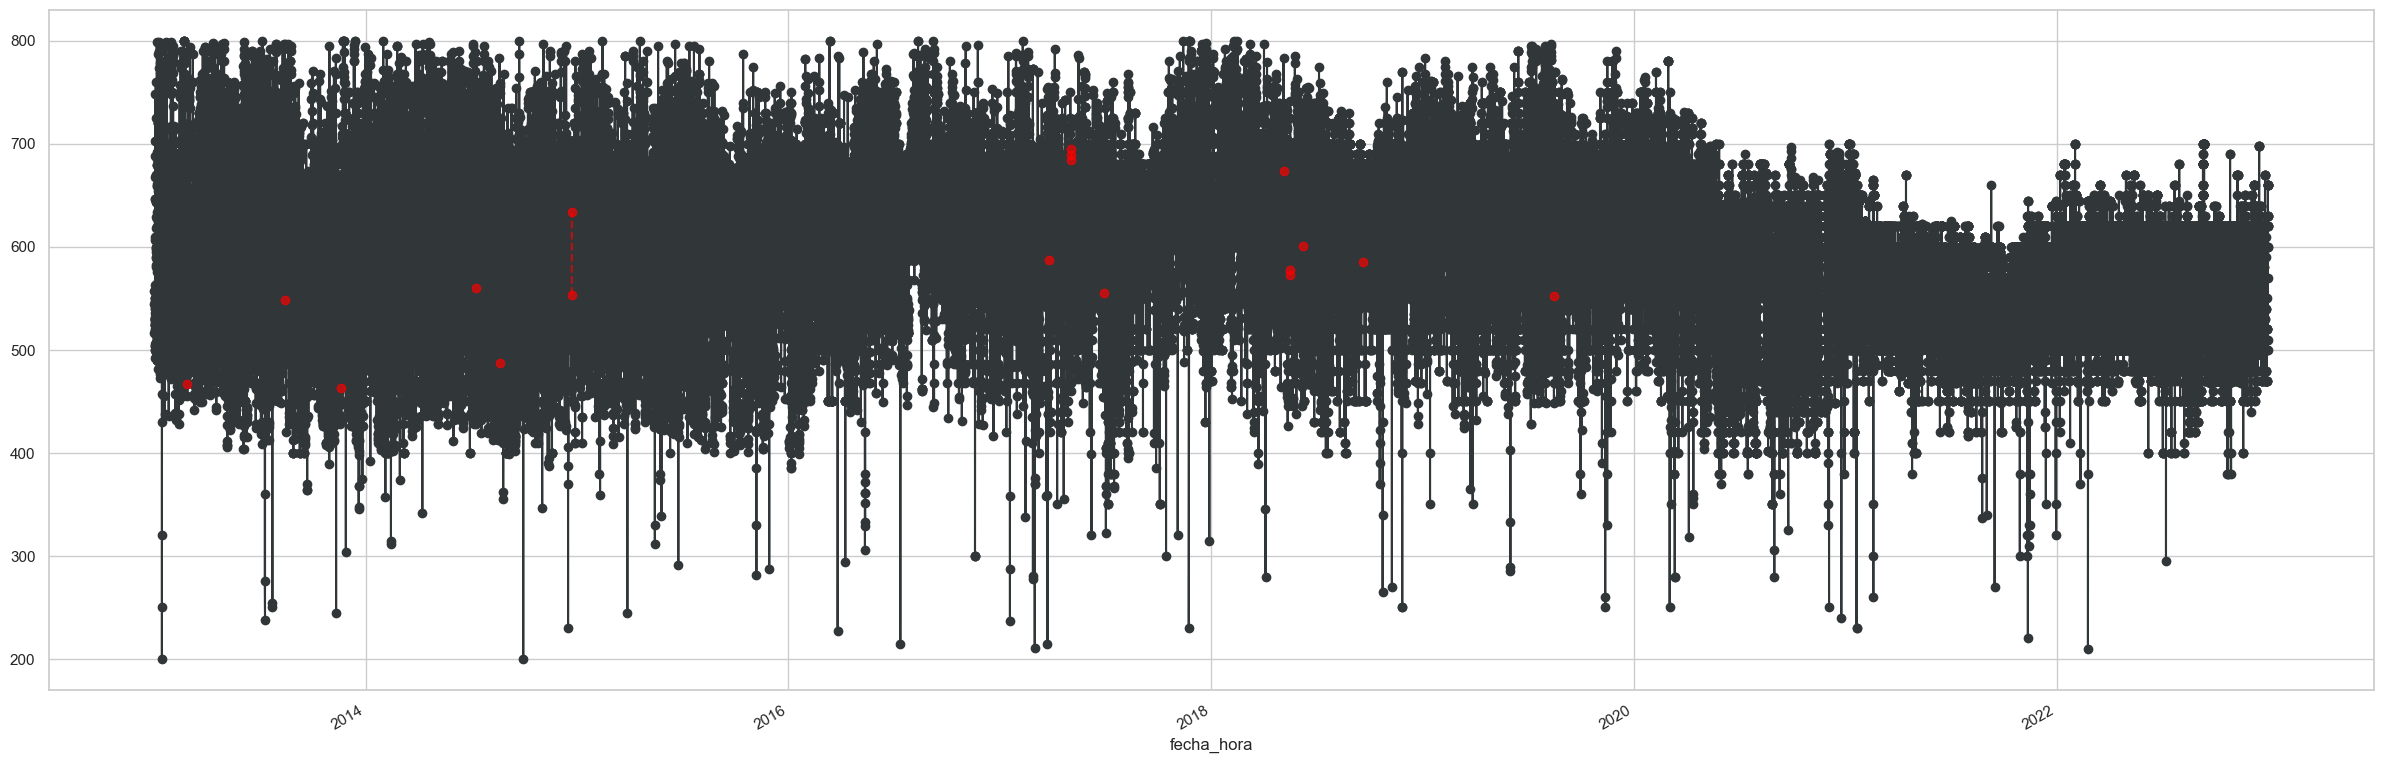

In [59]:
df_imputed = impute_and_plot(df_imputed, 'clasificador_horario', 'caudal')

In [60]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86050 entries, 2013-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    86050 non-null  float64
 1   agua_cruda_p_h            85697 non-null  float64
 2   agua_cruda_color          80260 non-null  float64
 3   agua_cruda_ntu            85965 non-null  float64
 4   agua_cruda_alcalinidad    67691 non-null  float64
 5   agua_cruda_conductividad  59501 non-null  float64
 6   coagulante_dosis          43483 non-null  float64
 7   vel_viento                69325 non-null  float64
 8   precipitacion             37761 non-null  float64
 9   temp_humeda               6798 non-null   float64
 10  clasificador_horario      86050 non-null  int64  
 11  clasificador_mensual      86050 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 8.5 MB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

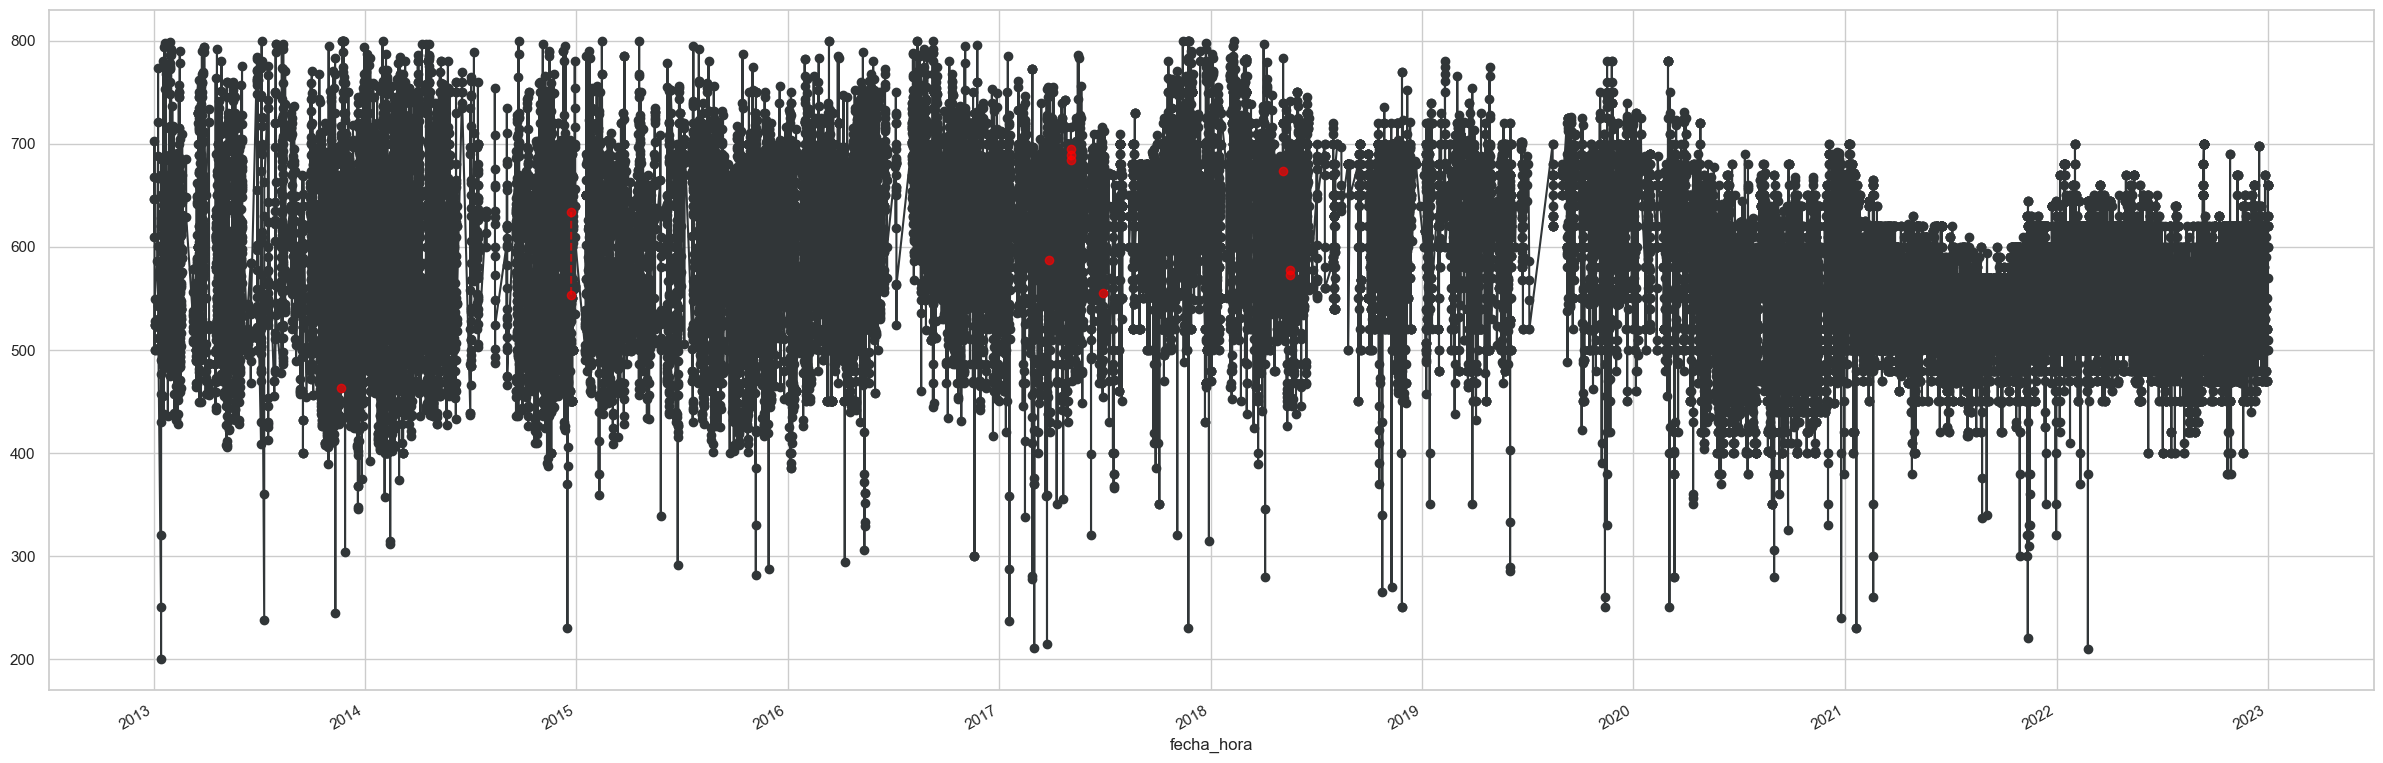

In [61]:
df_imputed_edit = impute_and_plot(df_imputed_edit, 'clasificador_horario', 'caudal')

In [62]:
df_imputed_edit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51573 entries, 2013-01-02 12:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51573 non-null  float64
 1   agua_cruda_p_h            51282 non-null  float64
 2   agua_cruda_color          48668 non-null  float64
 3   agua_cruda_ntu            51488 non-null  float64
 4   agua_cruda_alcalinidad    42716 non-null  float64
 5   agua_cruda_conductividad  38055 non-null  float64
 6   coagulante_dosis          43483 non-null  float64
 7   vel_viento                38139 non-null  float64
 8   precipitacion             20662 non-null  float64
 9   temp_humeda               4180 non-null   float64
 10  clasificador_horario      51573 non-null  int64  
 11  clasificador_mensual      51573 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 5.1 MB


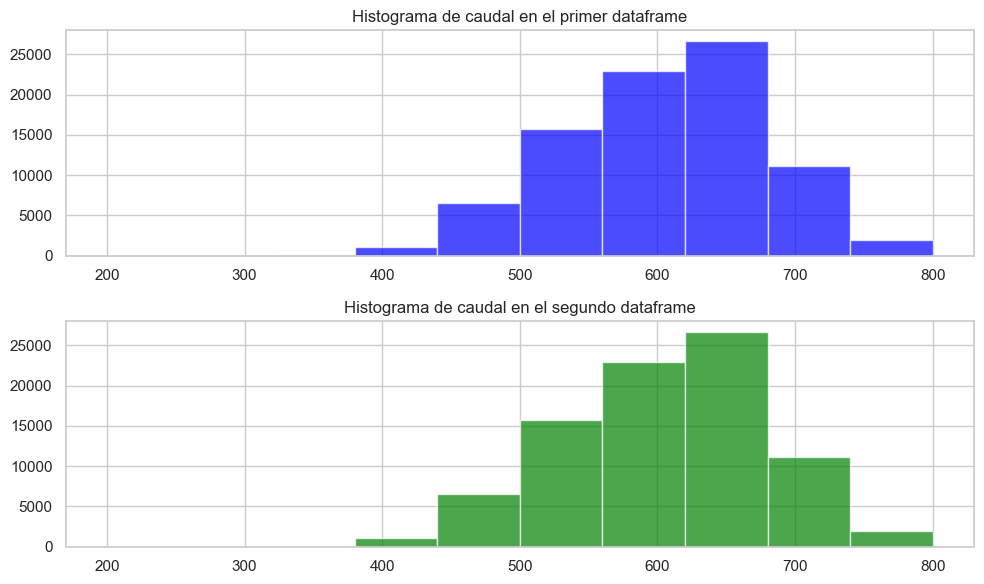

In [63]:
plot_histograms(df, df_imputed, 'caudal', bins=10)

**Dataframes a partir del 2017**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

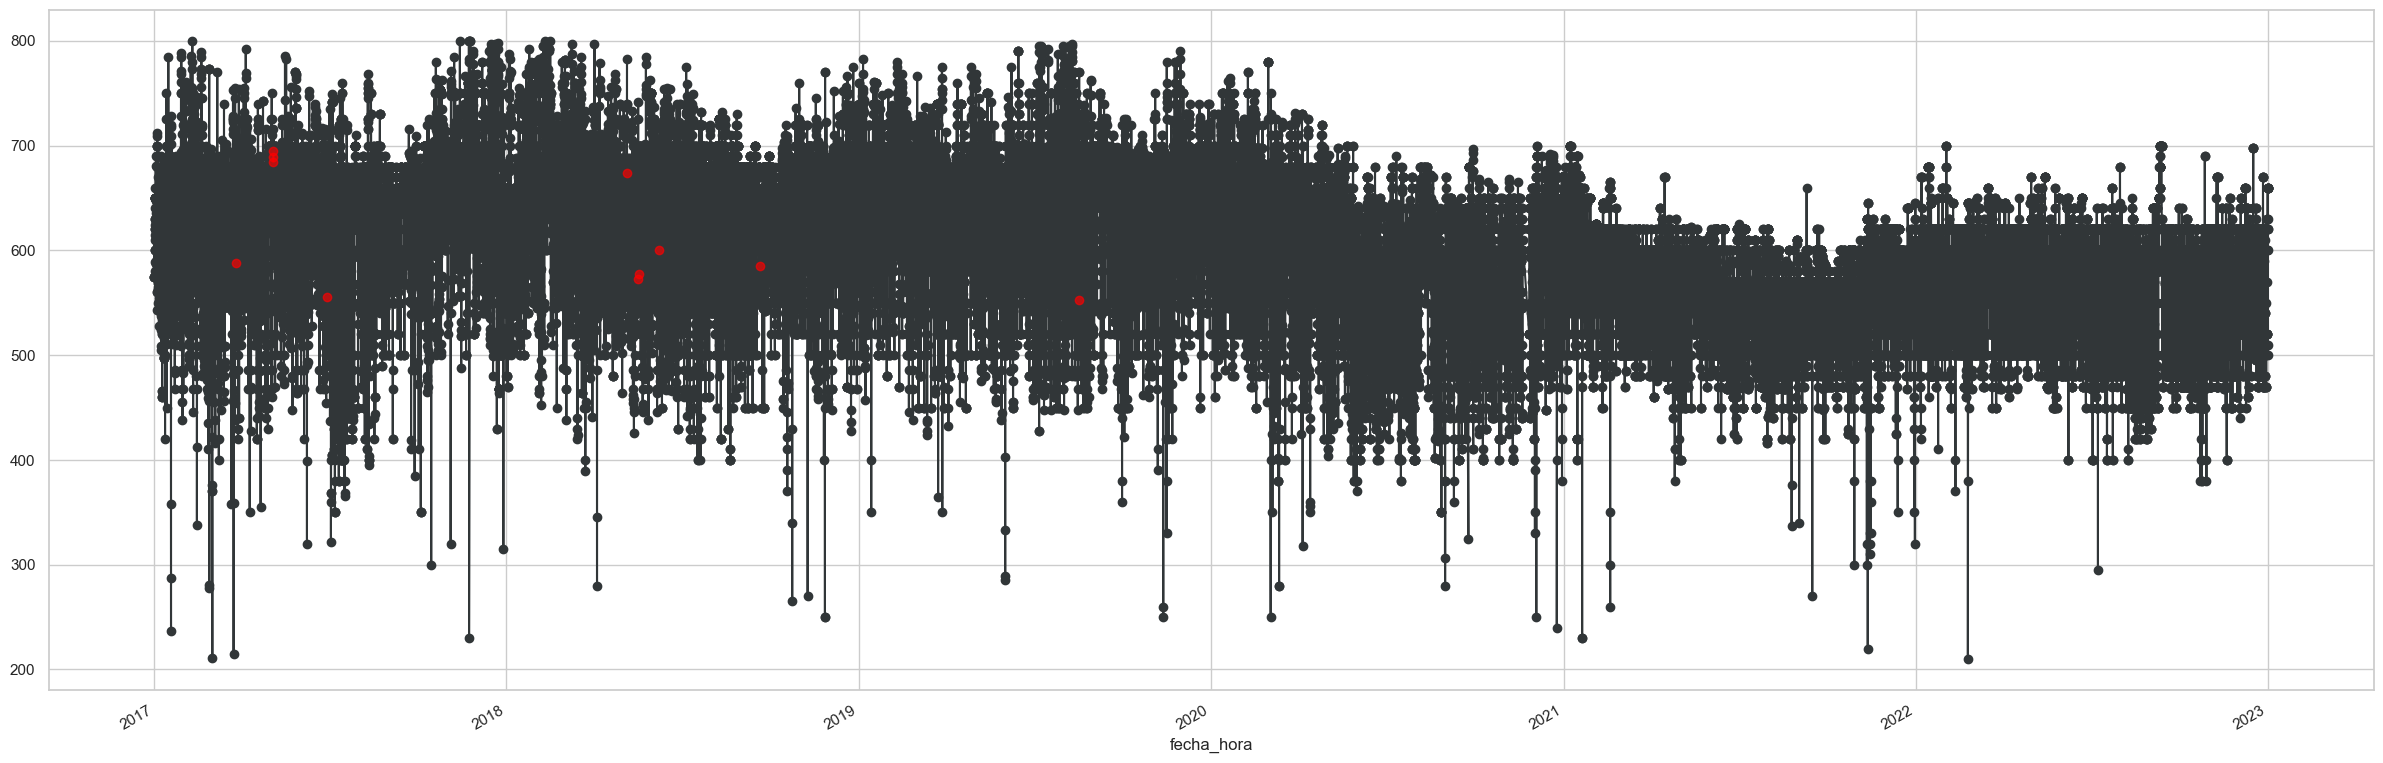

In [64]:
df_imputed_2017 = impute_and_plot(df_imputed_2017, 'clasificador_horario', 'caudal')

In [65]:
df_imputed_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51808 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51808 non-null  float64
 1   agua_cruda_p_h            51571 non-null  float64
 2   agua_cruda_color          50939 non-null  float64
 3   agua_cruda_ntu            51791 non-null  float64
 4   agua_cruda_alcalinidad    50800 non-null  float64
 5   agua_cruda_conductividad  50323 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                36884 non-null  float64
 8   precipitacion             36890 non-null  float64
 9   temp_humeda               4912 non-null   float64
 10  clasificador_horario      51808 non-null  int64  
 11  clasificador_mensual      51808 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 5.1 MB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

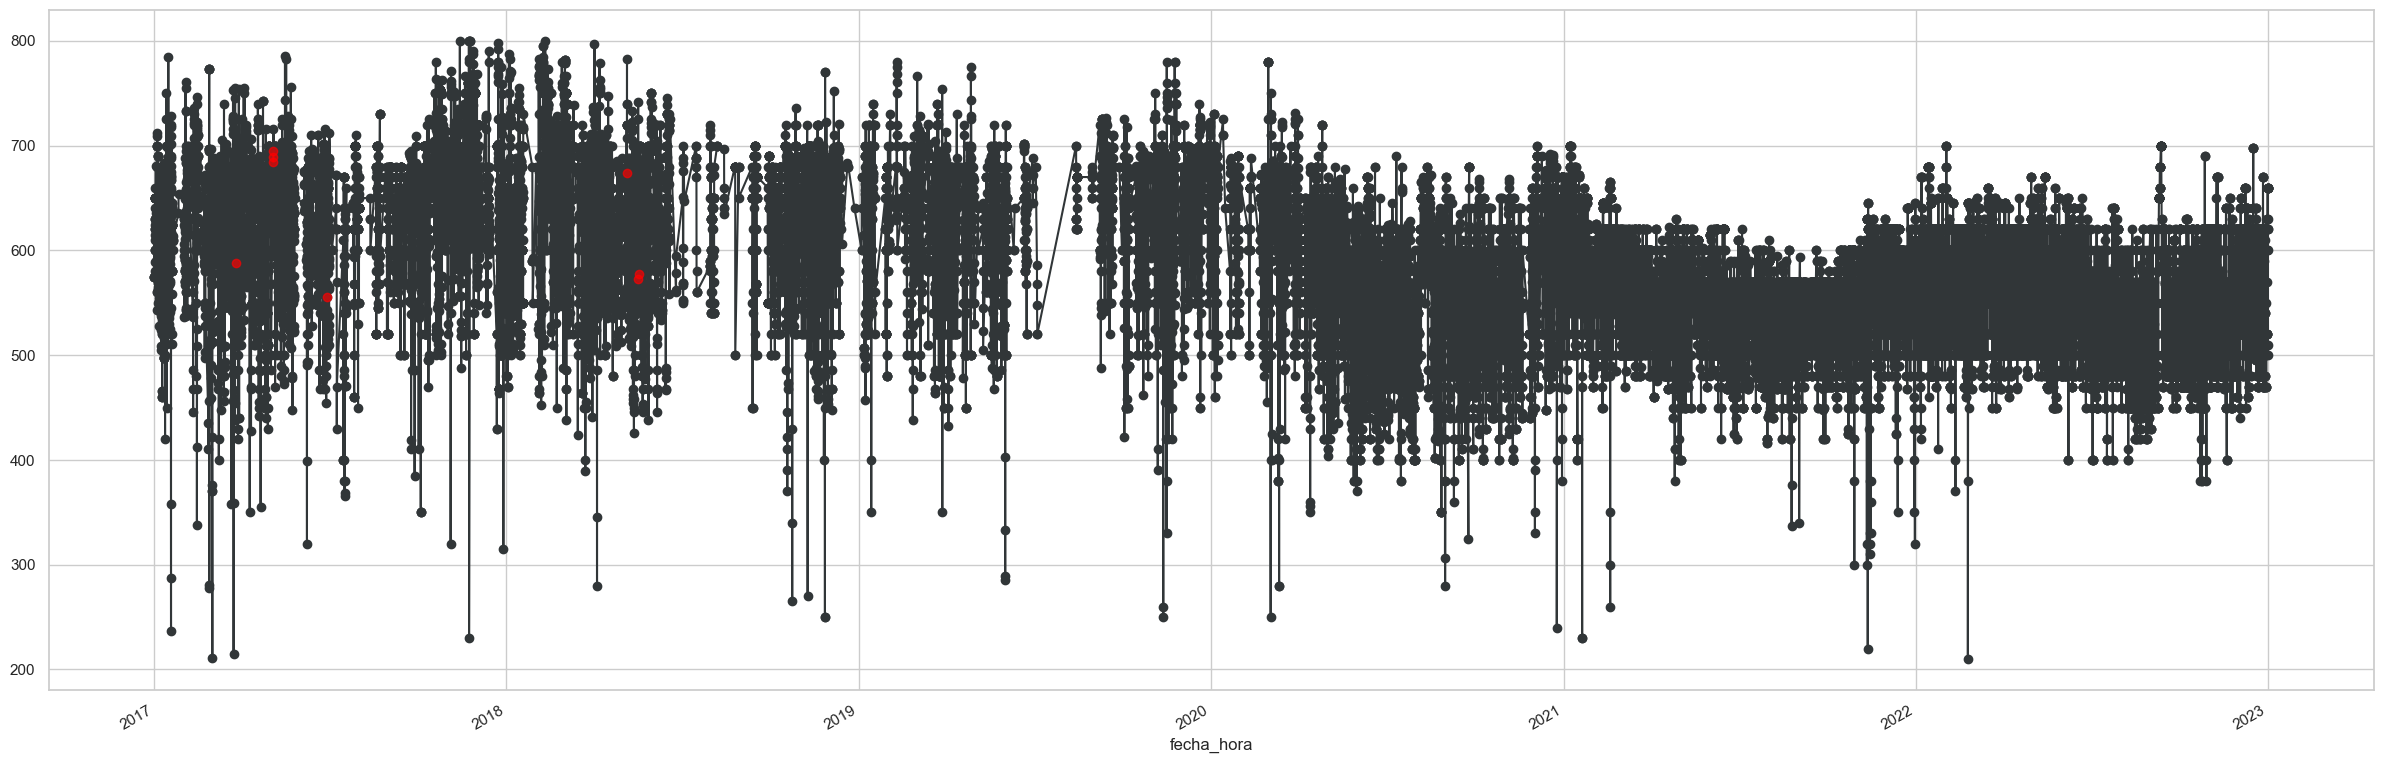

In [66]:
df_imputed_edit_2017 = impute_and_plot(df_imputed_edit_2017, 'clasificador_horario', 'caudal')

In [67]:
df_imputed_edit_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32274 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    32274 non-null  float64
 1   agua_cruda_p_h            32065 non-null  float64
 2   agua_cruda_color          31727 non-null  float64
 3   agua_cruda_ntu            32257 non-null  float64
 4   agua_cruda_alcalinidad    31540 non-null  float64
 5   agua_cruda_conductividad  31276 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                19897 non-null  float64
 8   precipitacion             19900 non-null  float64
 9   temp_humeda               3041 non-null   float64
 10  clasificador_horario      32274 non-null  int64  
 11  clasificador_mensual      32274 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 3.2 MB


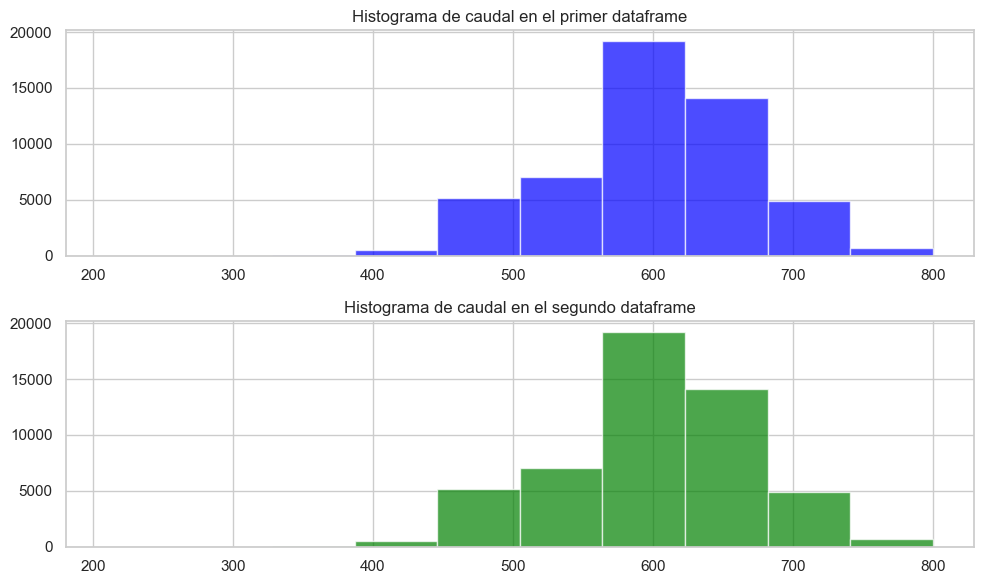

In [68]:
plot_histograms(df_2017, df_imputed_2017, 'caudal', bins=10)

### AGUA_CRUDA_P_H

**Dataframes completos**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

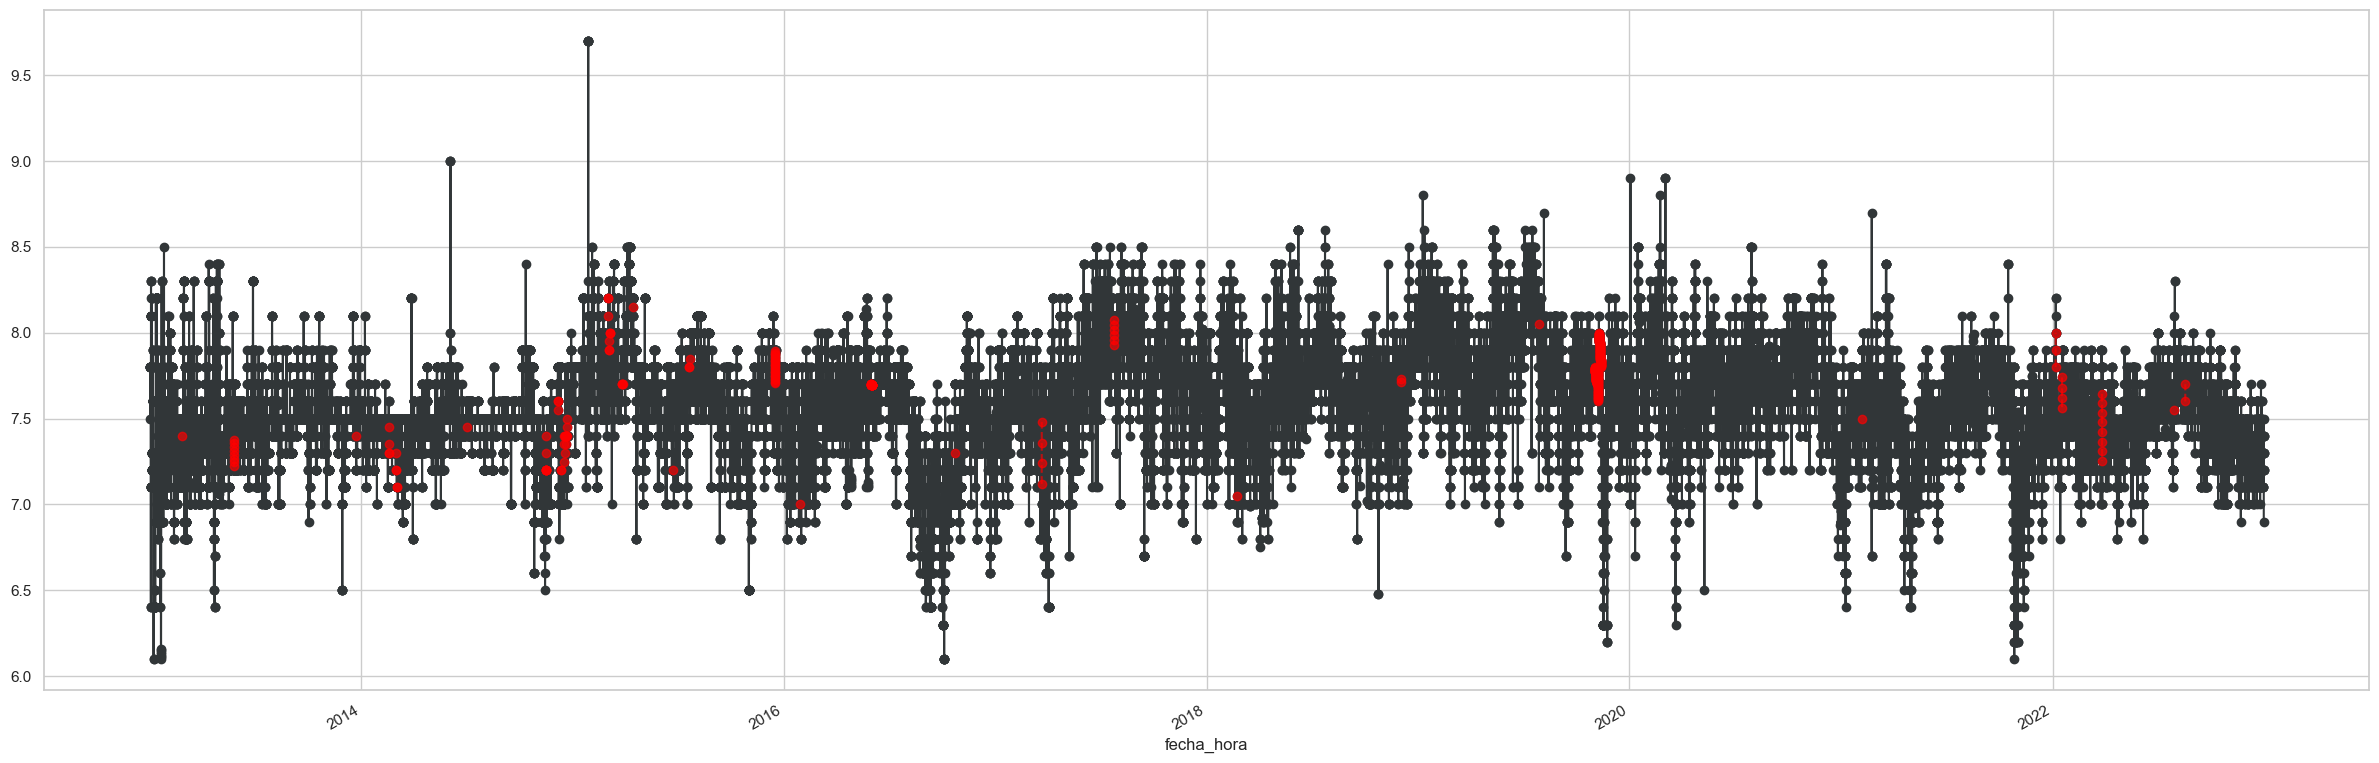

In [69]:
df_imputed = impute_and_plot(df_imputed, 'clasificador_mensual', 'agua_cruda_p_h')

In [70]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86050 entries, 2013-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    86050 non-null  float64
 1   agua_cruda_p_h            86050 non-null  float64
 2   agua_cruda_color          80260 non-null  float64
 3   agua_cruda_ntu            85965 non-null  float64
 4   agua_cruda_alcalinidad    67691 non-null  float64
 5   agua_cruda_conductividad  59501 non-null  float64
 6   coagulante_dosis          43483 non-null  float64
 7   vel_viento                69325 non-null  float64
 8   precipitacion             37761 non-null  float64
 9   temp_humeda               6798 non-null   float64
 10  clasificador_horario      86050 non-null  int64  
 11  clasificador_mensual      86050 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 8.5 MB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

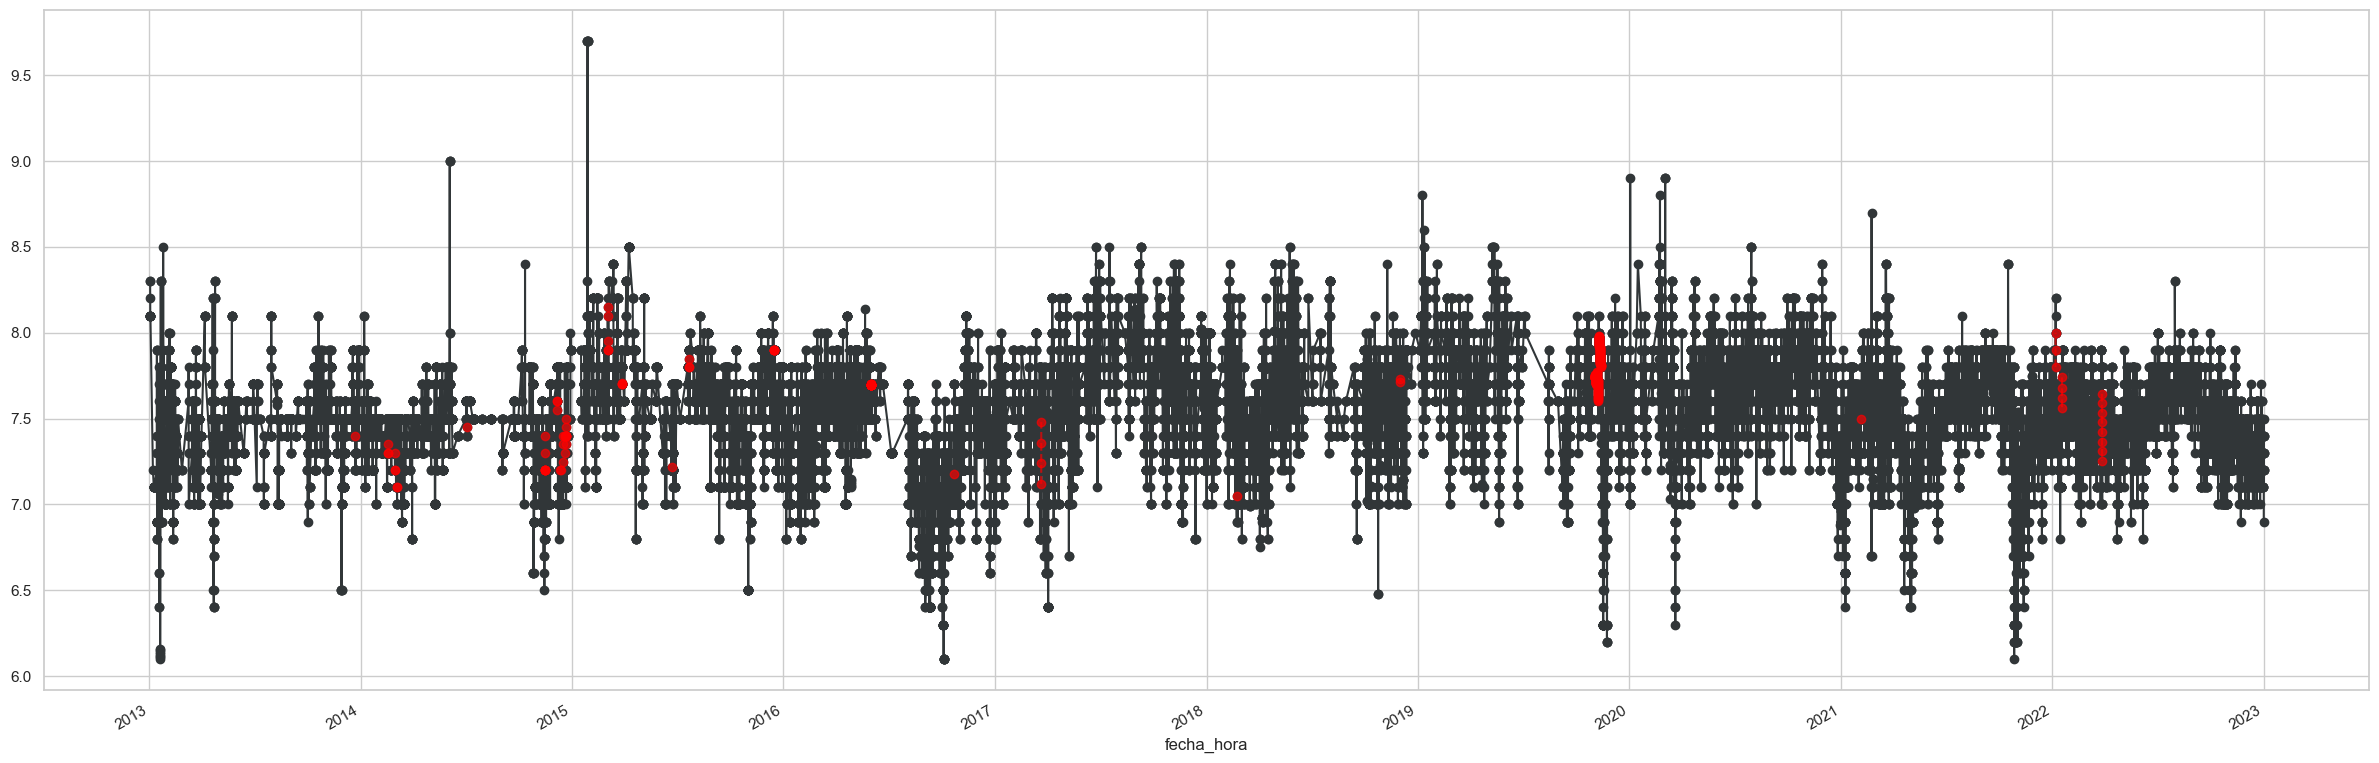

In [71]:
df_imputed_edit = impute_and_plot(df_imputed_edit, 'clasificador_mensual', 'agua_cruda_p_h')

In [72]:
df_imputed_edit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51573 entries, 2013-01-02 12:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51573 non-null  float64
 1   agua_cruda_p_h            51573 non-null  float64
 2   agua_cruda_color          48668 non-null  float64
 3   agua_cruda_ntu            51488 non-null  float64
 4   agua_cruda_alcalinidad    42716 non-null  float64
 5   agua_cruda_conductividad  38055 non-null  float64
 6   coagulante_dosis          43483 non-null  float64
 7   vel_viento                38139 non-null  float64
 8   precipitacion             20662 non-null  float64
 9   temp_humeda               4180 non-null   float64
 10  clasificador_horario      51573 non-null  int64  
 11  clasificador_mensual      51573 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 5.1 MB


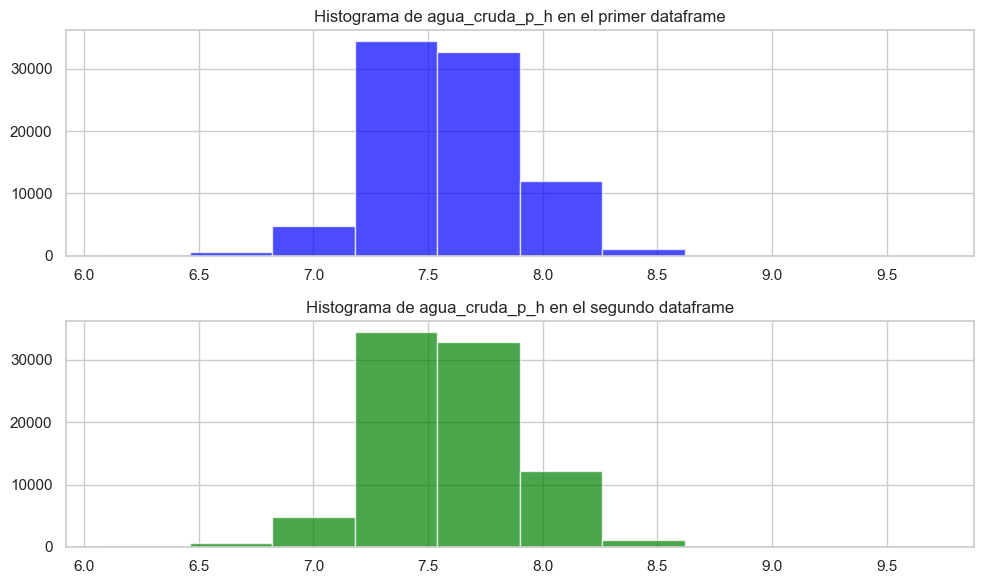

In [73]:
plot_histograms(df, df_imputed, 'agua_cruda_p_h', bins=10)

**Dataframes a partir del 2017**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

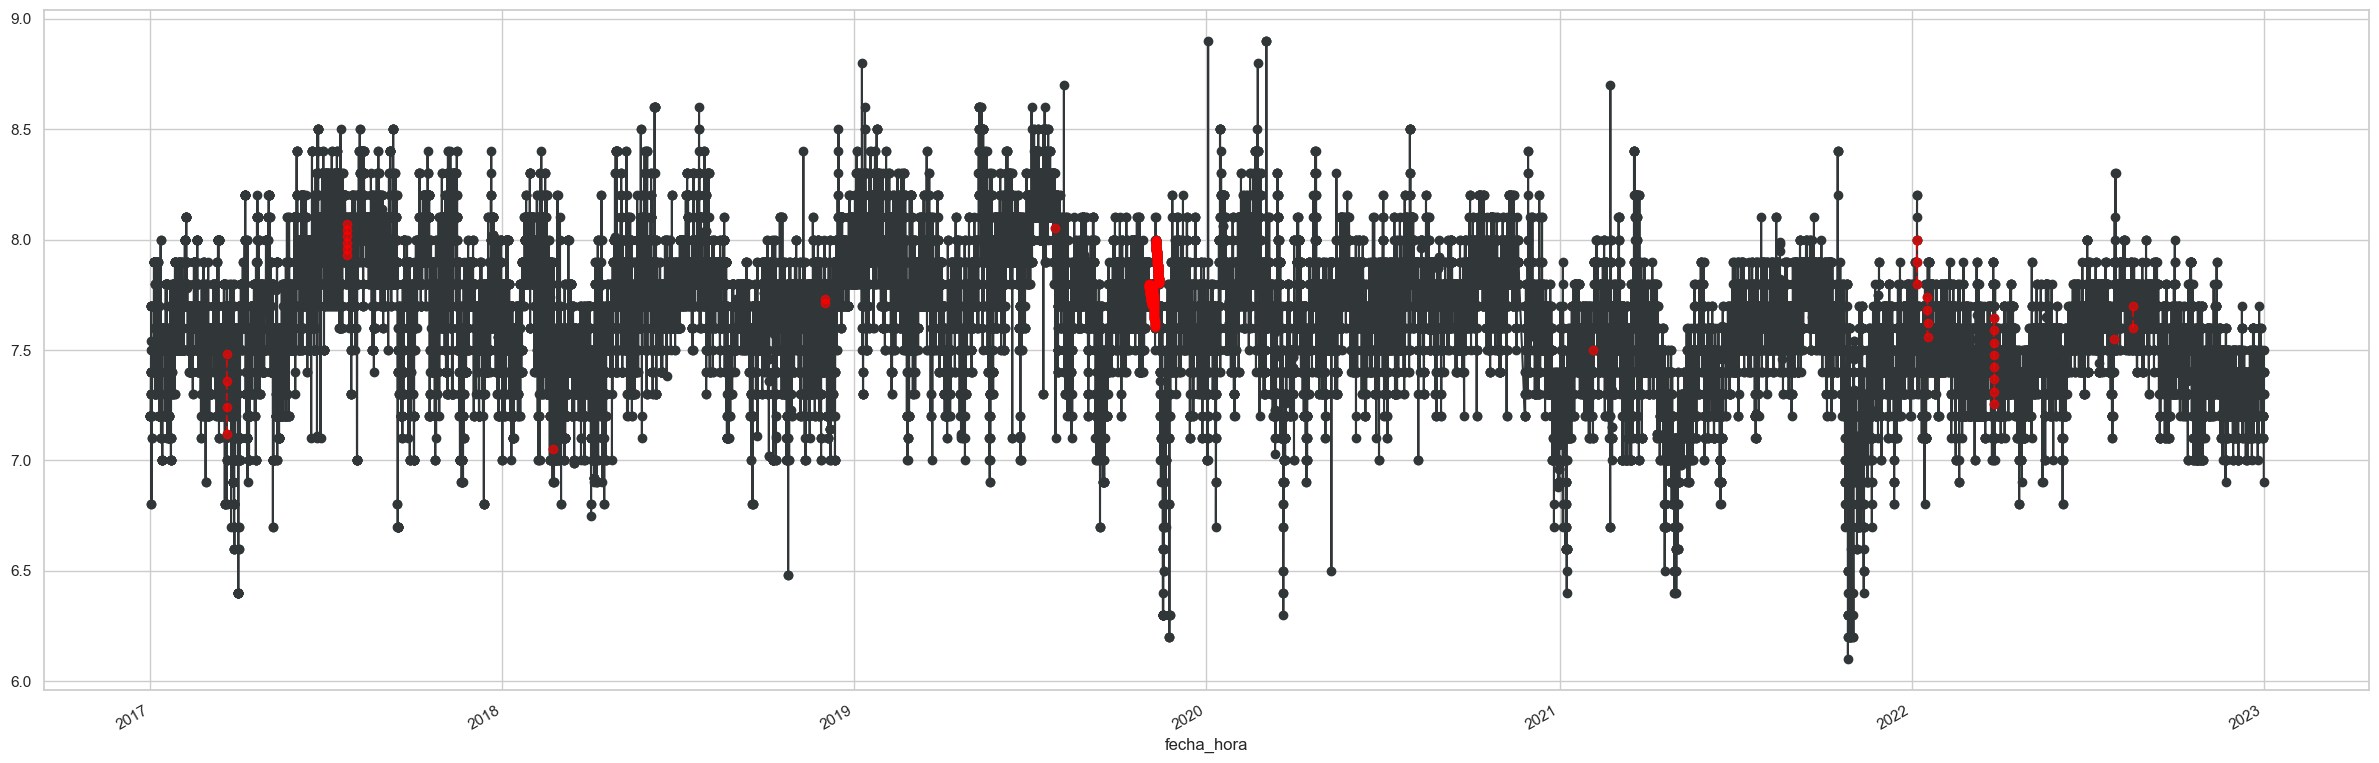

In [74]:
df_imputed_2017 = impute_and_plot(df_imputed_2017, 'clasificador_mensual', 'agua_cruda_p_h')

In [75]:
df_imputed_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51808 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51808 non-null  float64
 1   agua_cruda_p_h            51808 non-null  float64
 2   agua_cruda_color          50939 non-null  float64
 3   agua_cruda_ntu            51791 non-null  float64
 4   agua_cruda_alcalinidad    50800 non-null  float64
 5   agua_cruda_conductividad  50323 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                36884 non-null  float64
 8   precipitacion             36890 non-null  float64
 9   temp_humeda               4912 non-null   float64
 10  clasificador_horario      51808 non-null  int64  
 11  clasificador_mensual      51808 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 5.1 MB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

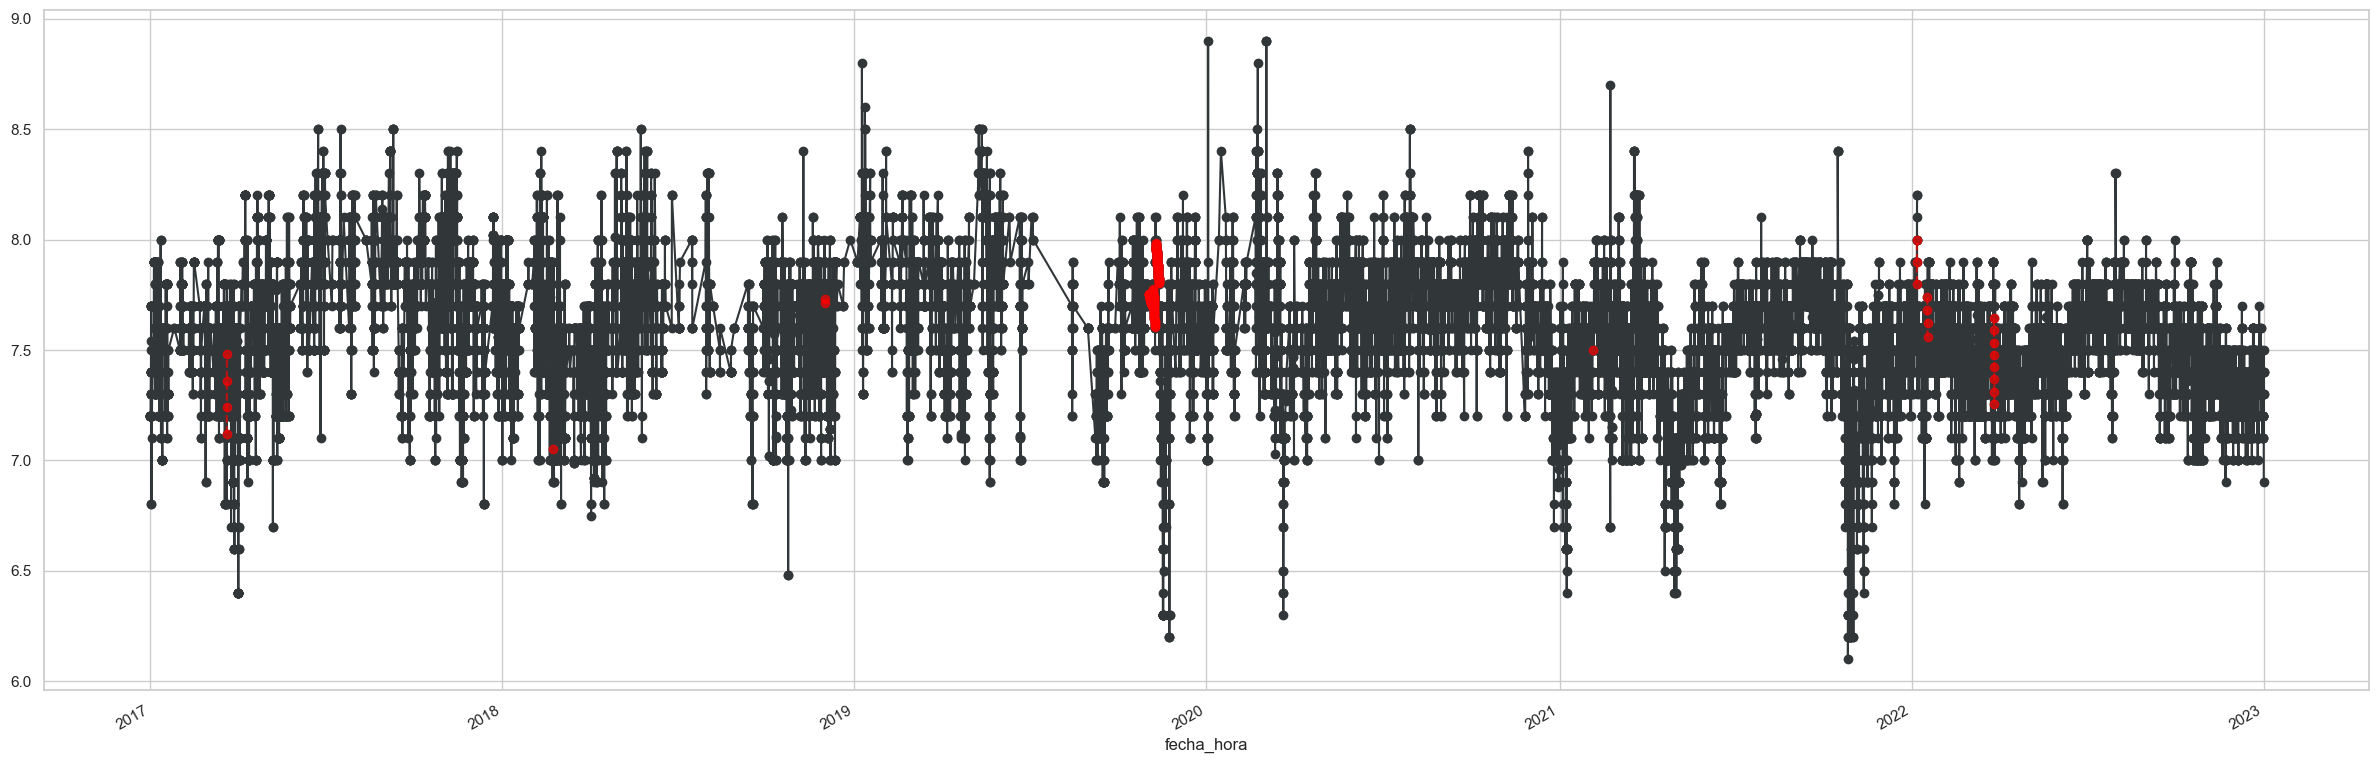

In [76]:
df_imputed_edit_2017 = impute_and_plot(df_imputed_edit_2017, 'clasificador_mensual', 'agua_cruda_p_h')

In [77]:
df_imputed_edit_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32274 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    32274 non-null  float64
 1   agua_cruda_p_h            32274 non-null  float64
 2   agua_cruda_color          31727 non-null  float64
 3   agua_cruda_ntu            32257 non-null  float64
 4   agua_cruda_alcalinidad    31540 non-null  float64
 5   agua_cruda_conductividad  31276 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                19897 non-null  float64
 8   precipitacion             19900 non-null  float64
 9   temp_humeda               3041 non-null   float64
 10  clasificador_horario      32274 non-null  int64  
 11  clasificador_mensual      32274 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 3.2 MB


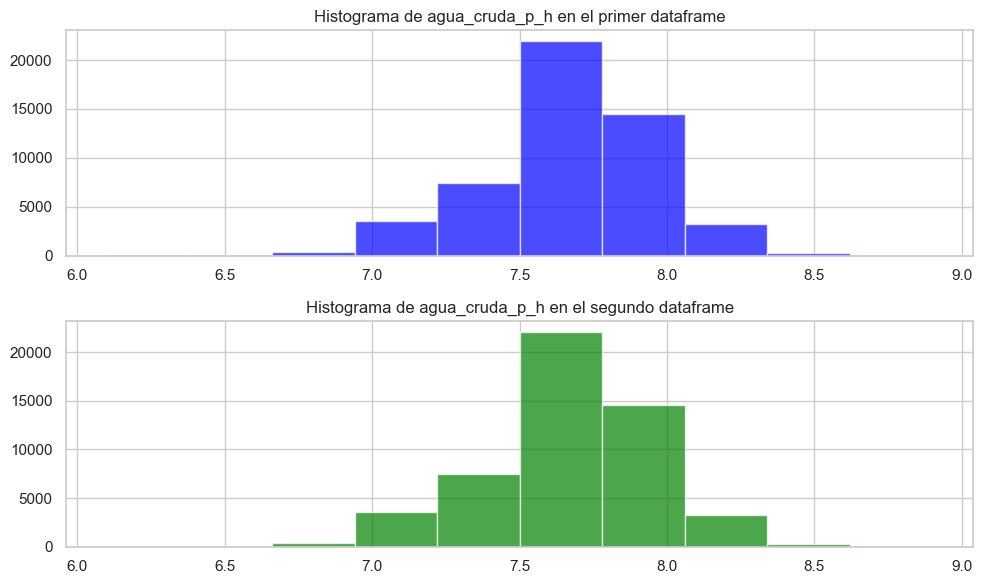

In [78]:
plot_histograms(df_2017, df_imputed_2017, 'agua_cruda_p_h', bins=10)

### AGUA_CRUDA_COLOR

**Dataframes completos**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

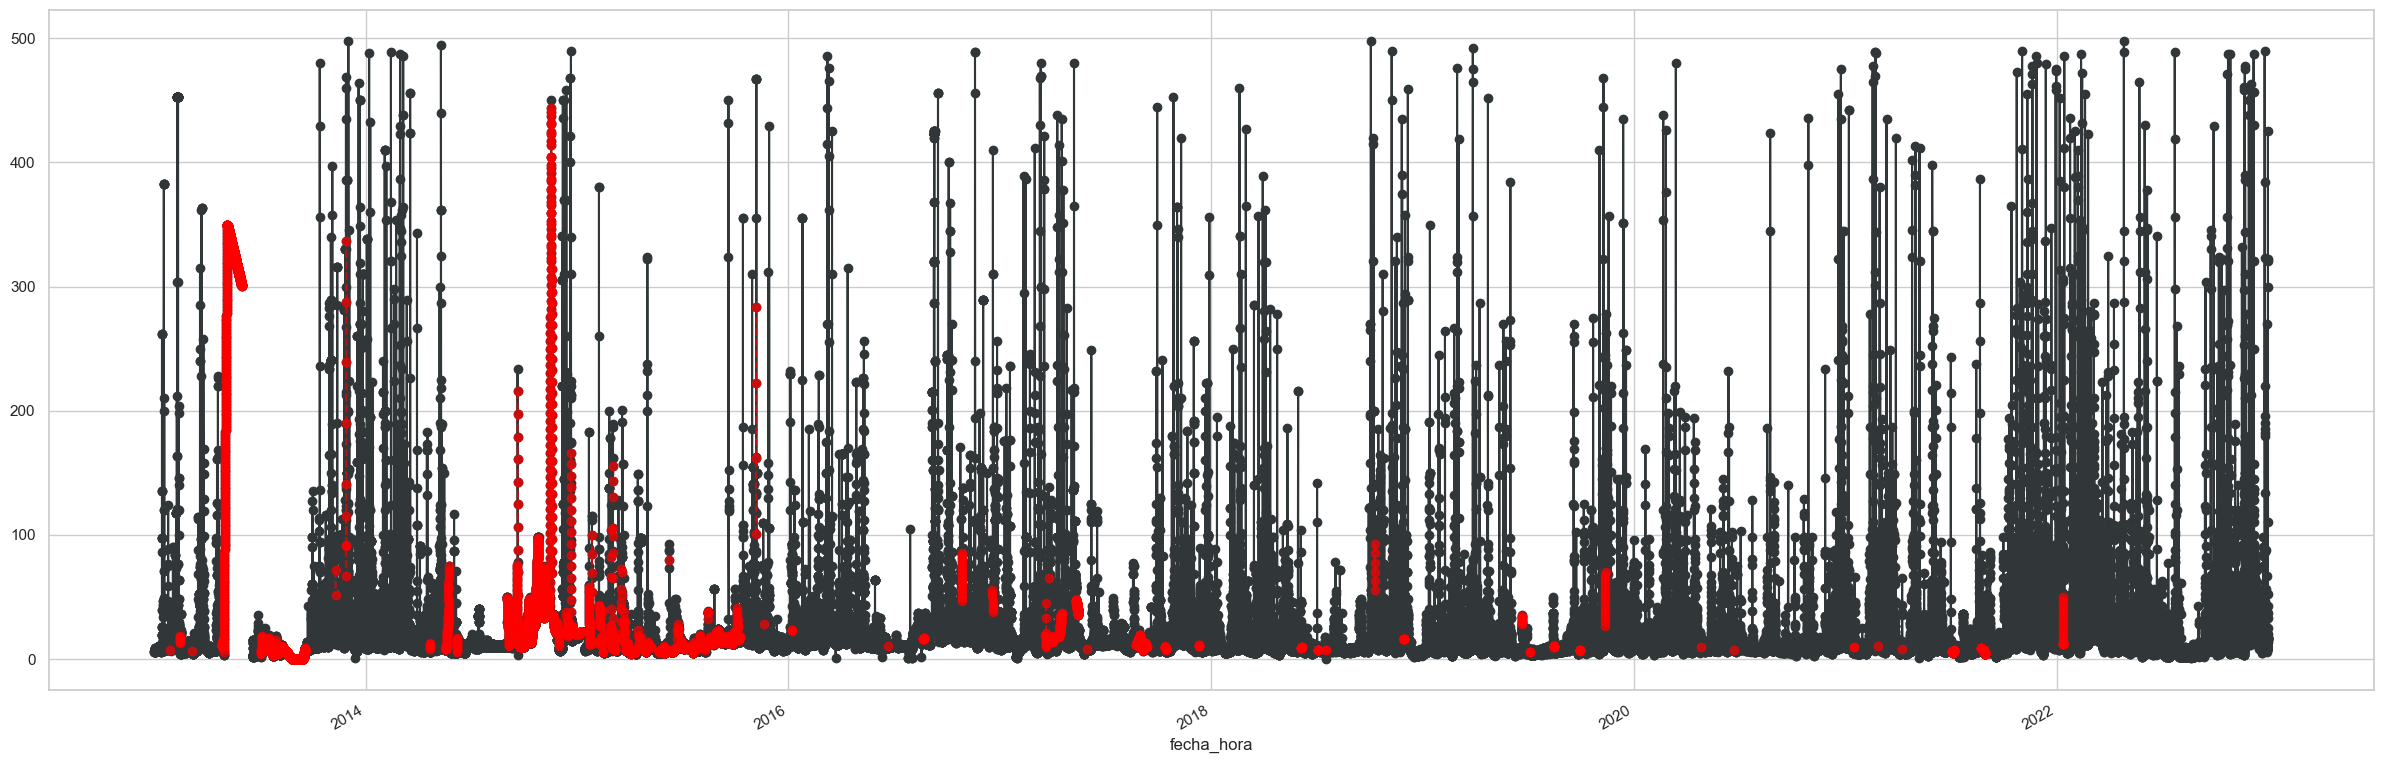

In [79]:
df_imputed = impute_and_plot(df_imputed, 'clasificador_mensual', 'agua_cruda_color')

In [80]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86050 entries, 2013-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    86050 non-null  float64
 1   agua_cruda_p_h            86050 non-null  float64
 2   agua_cruda_color          85618 non-null  float64
 3   agua_cruda_ntu            85965 non-null  float64
 4   agua_cruda_alcalinidad    67691 non-null  float64
 5   agua_cruda_conductividad  59501 non-null  float64
 6   coagulante_dosis          43483 non-null  float64
 7   vel_viento                69325 non-null  float64
 8   precipitacion             37761 non-null  float64
 9   temp_humeda               6798 non-null   float64
 10  clasificador_horario      86050 non-null  int64  
 11  clasificador_mensual      86050 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 8.5 MB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

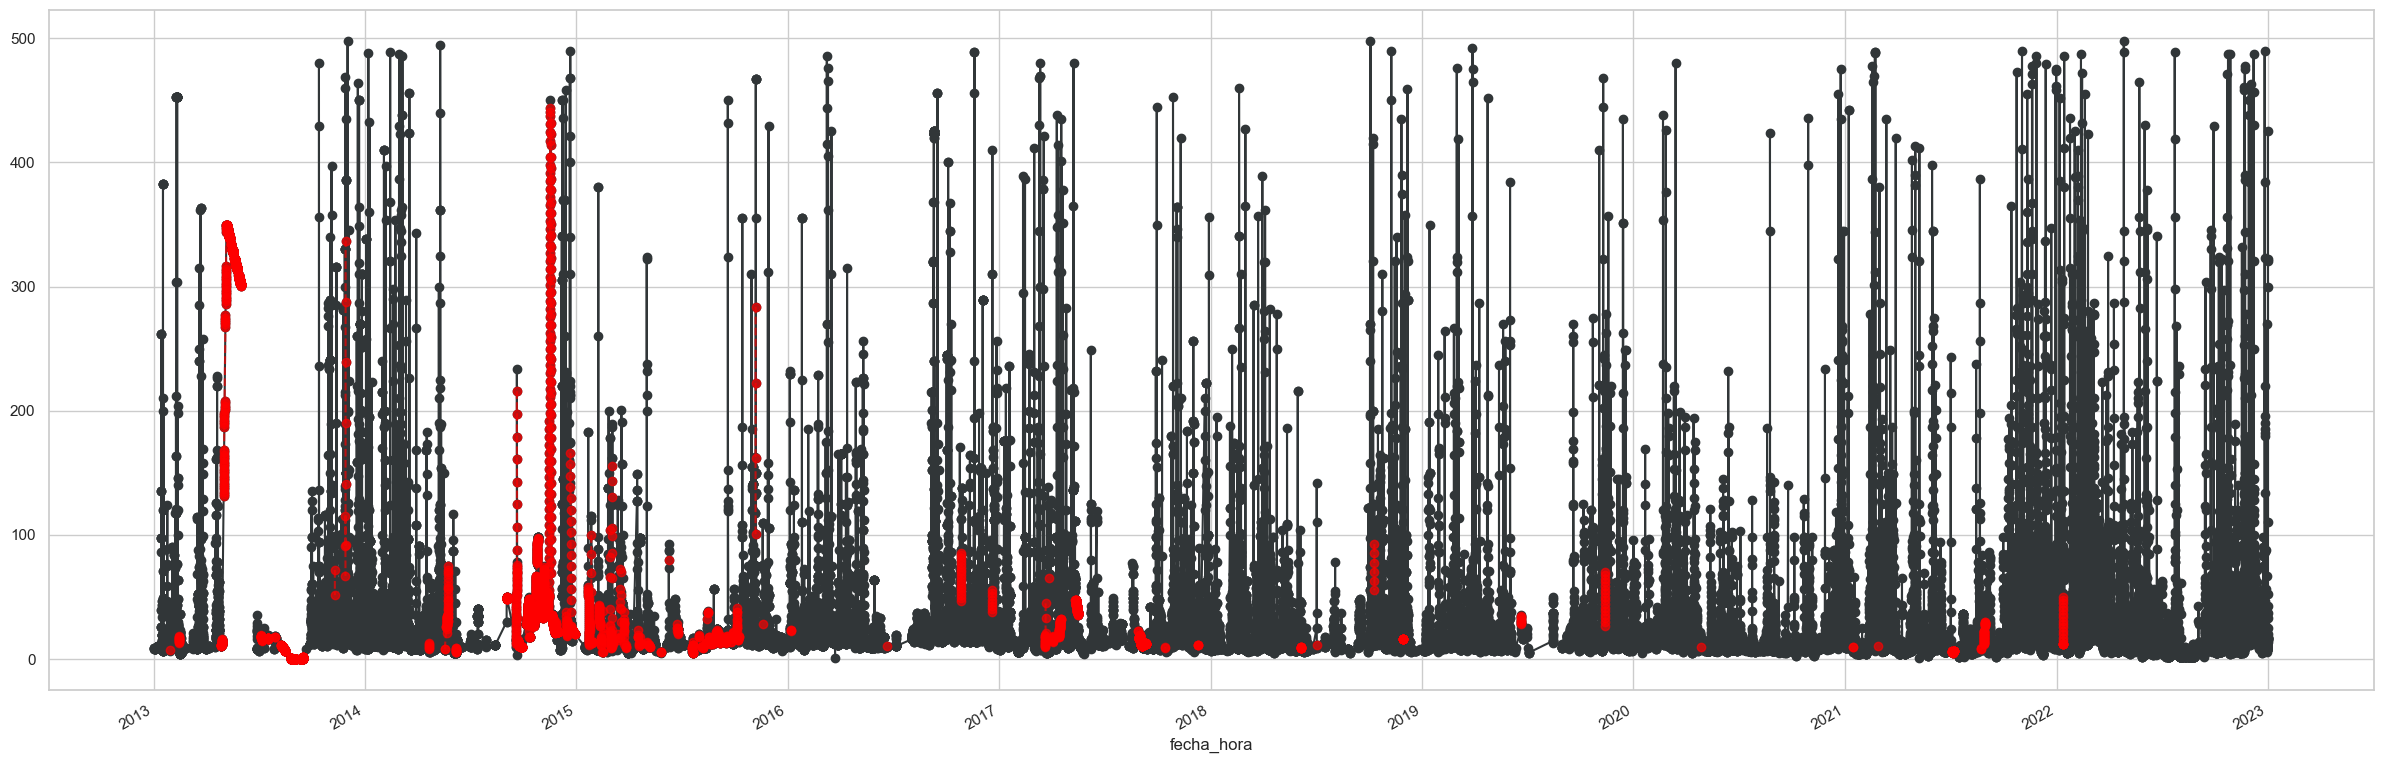

In [81]:
df_imputed_edit = impute_and_plot(df_imputed_edit, 'clasificador_mensual', 'agua_cruda_color')

In [82]:
df_imputed_edit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51573 entries, 2013-01-02 12:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51573 non-null  float64
 1   agua_cruda_p_h            51573 non-null  float64
 2   agua_cruda_color          51498 non-null  float64
 3   agua_cruda_ntu            51488 non-null  float64
 4   agua_cruda_alcalinidad    42716 non-null  float64
 5   agua_cruda_conductividad  38055 non-null  float64
 6   coagulante_dosis          43483 non-null  float64
 7   vel_viento                38139 non-null  float64
 8   precipitacion             20662 non-null  float64
 9   temp_humeda               4180 non-null   float64
 10  clasificador_horario      51573 non-null  int64  
 11  clasificador_mensual      51573 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 5.1 MB


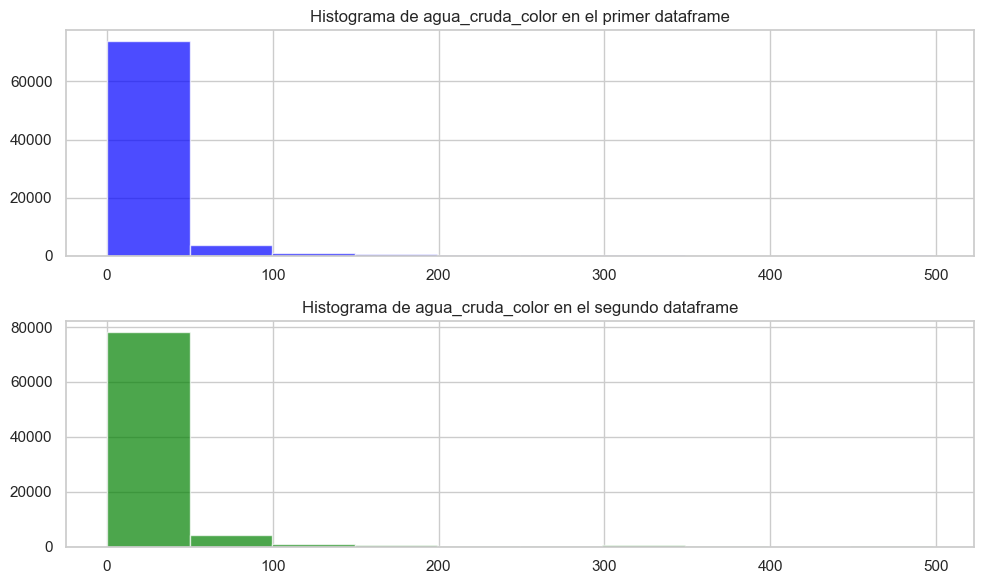

In [83]:
plot_histograms(df, df_imputed, 'agua_cruda_color', bins=10)

**Dataframes a partir del 2017**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

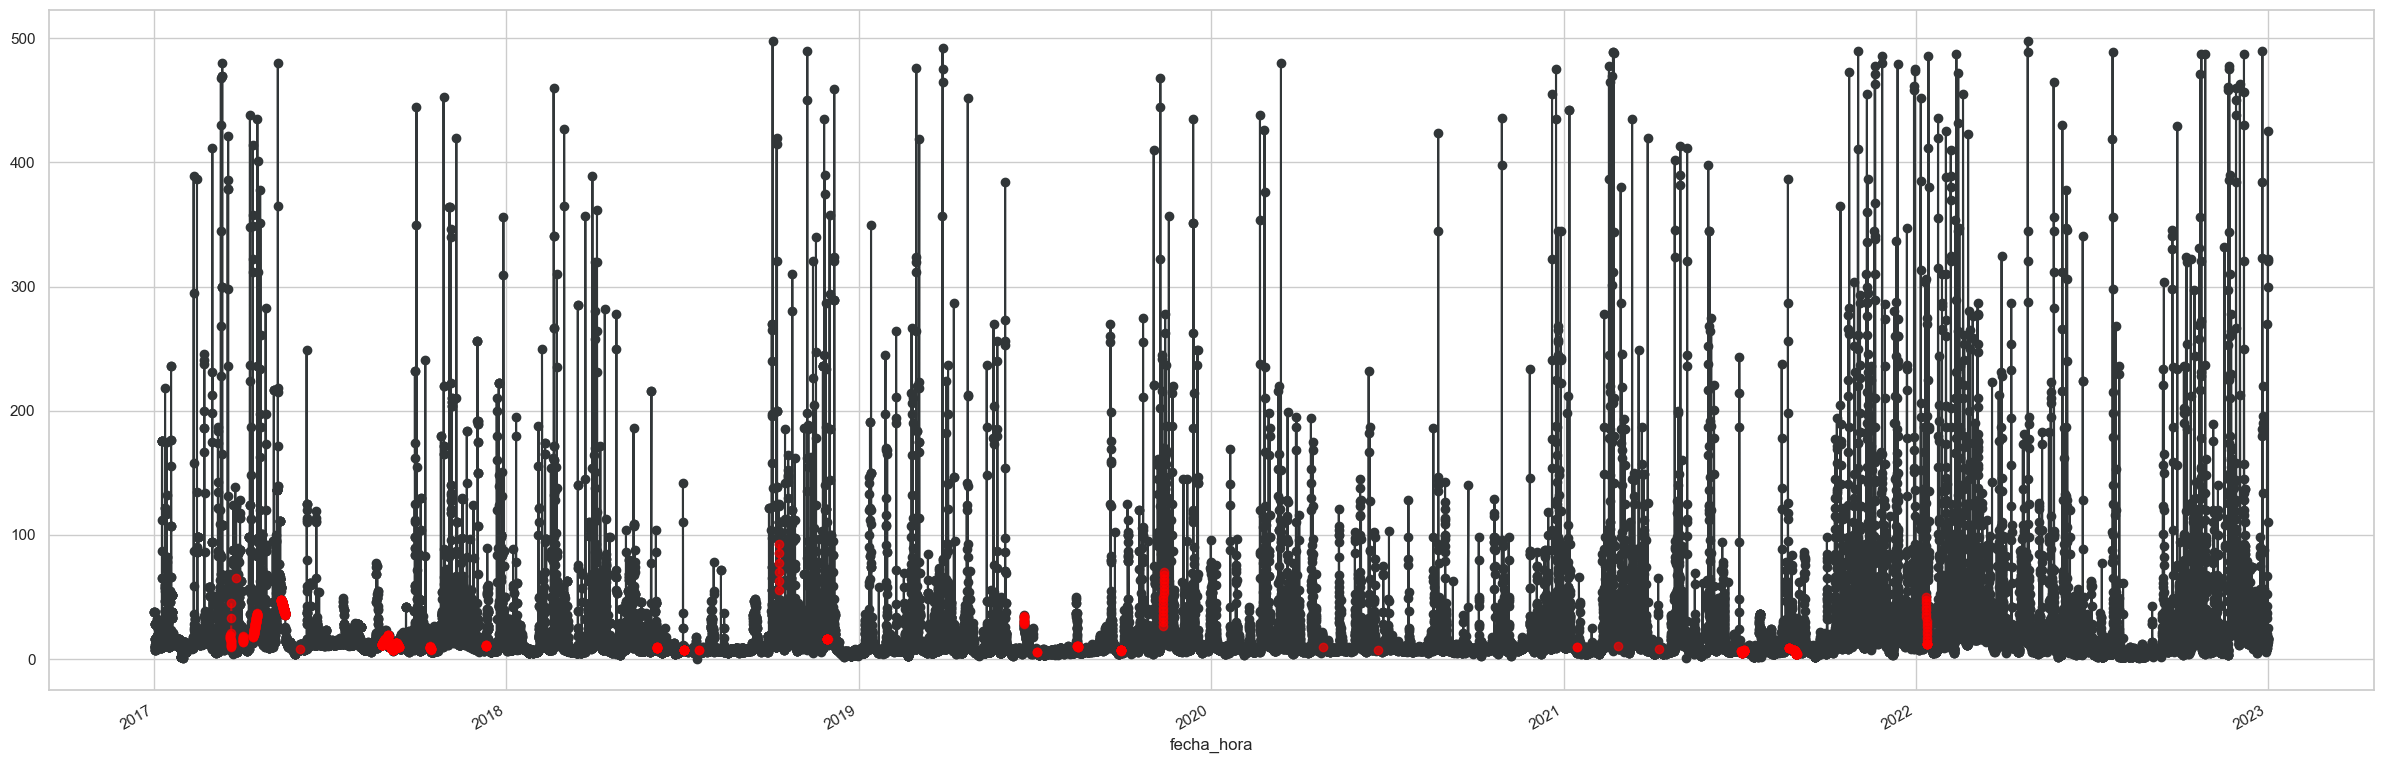

In [84]:
df_imputed_2017 = impute_and_plot(df_imputed_2017, 'clasificador_mensual', 'agua_cruda_color')

In [85]:
df_imputed_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51808 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51808 non-null  float64
 1   agua_cruda_p_h            51808 non-null  float64
 2   agua_cruda_color          51808 non-null  float64
 3   agua_cruda_ntu            51791 non-null  float64
 4   agua_cruda_alcalinidad    50800 non-null  float64
 5   agua_cruda_conductividad  50323 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                36884 non-null  float64
 8   precipitacion             36890 non-null  float64
 9   temp_humeda               4912 non-null   float64
 10  clasificador_horario      51808 non-null  int64  
 11  clasificador_mensual      51808 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 5.1 MB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

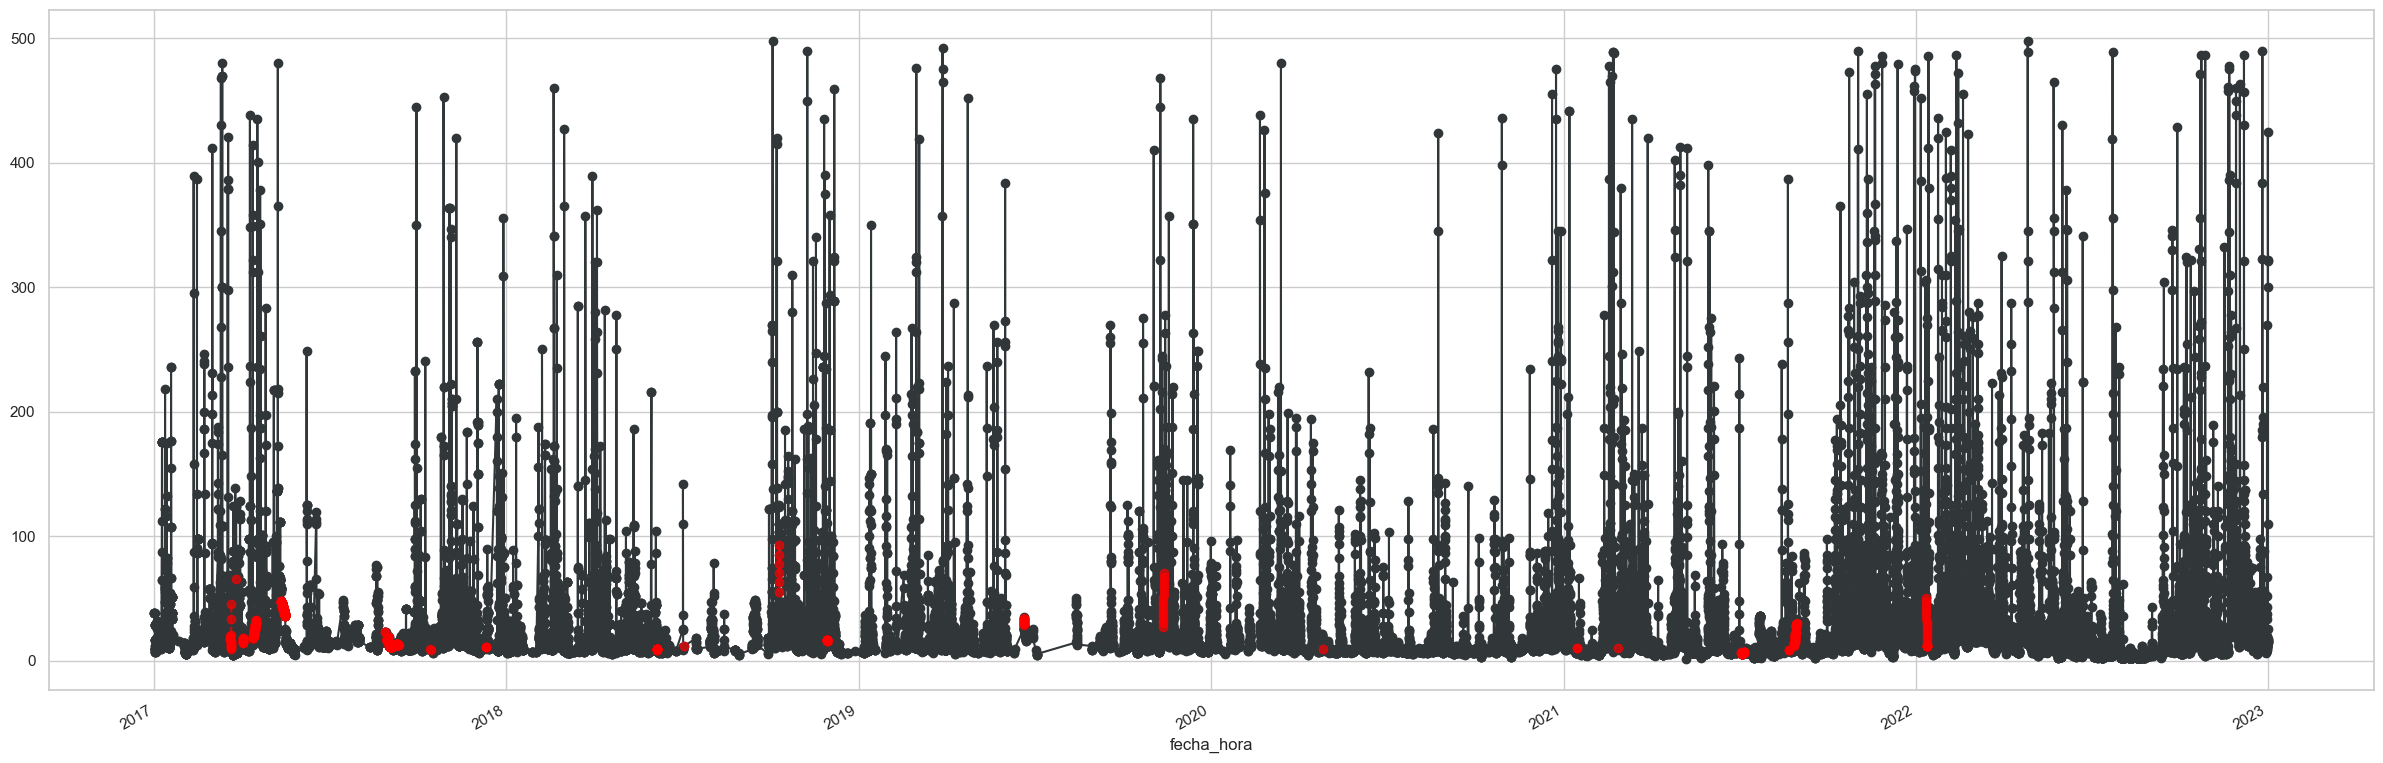

In [86]:
df_imputed_edit_2017 = impute_and_plot(df_imputed_edit_2017, 'clasificador_mensual', 'agua_cruda_color')

In [87]:
df_imputed_edit_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32274 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    32274 non-null  float64
 1   agua_cruda_p_h            32274 non-null  float64
 2   agua_cruda_color          32274 non-null  float64
 3   agua_cruda_ntu            32257 non-null  float64
 4   agua_cruda_alcalinidad    31540 non-null  float64
 5   agua_cruda_conductividad  31276 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                19897 non-null  float64
 8   precipitacion             19900 non-null  float64
 9   temp_humeda               3041 non-null   float64
 10  clasificador_horario      32274 non-null  int64  
 11  clasificador_mensual      32274 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 3.2 MB


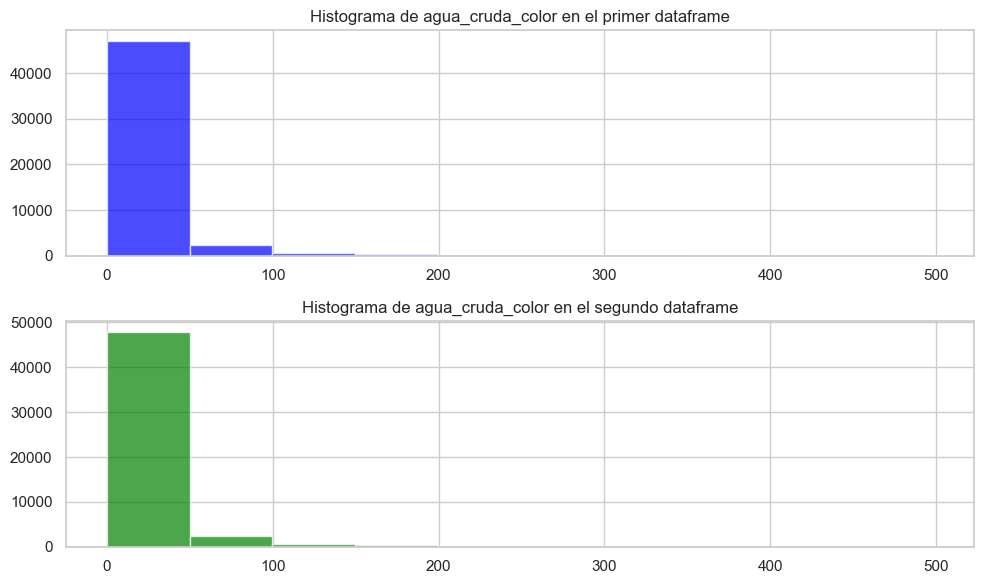

In [88]:
plot_histograms(df_2017, df_imputed_2017, 'agua_cruda_color', bins=10)

### AGUA_CRUDA_NTU

**Dataframes completos**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

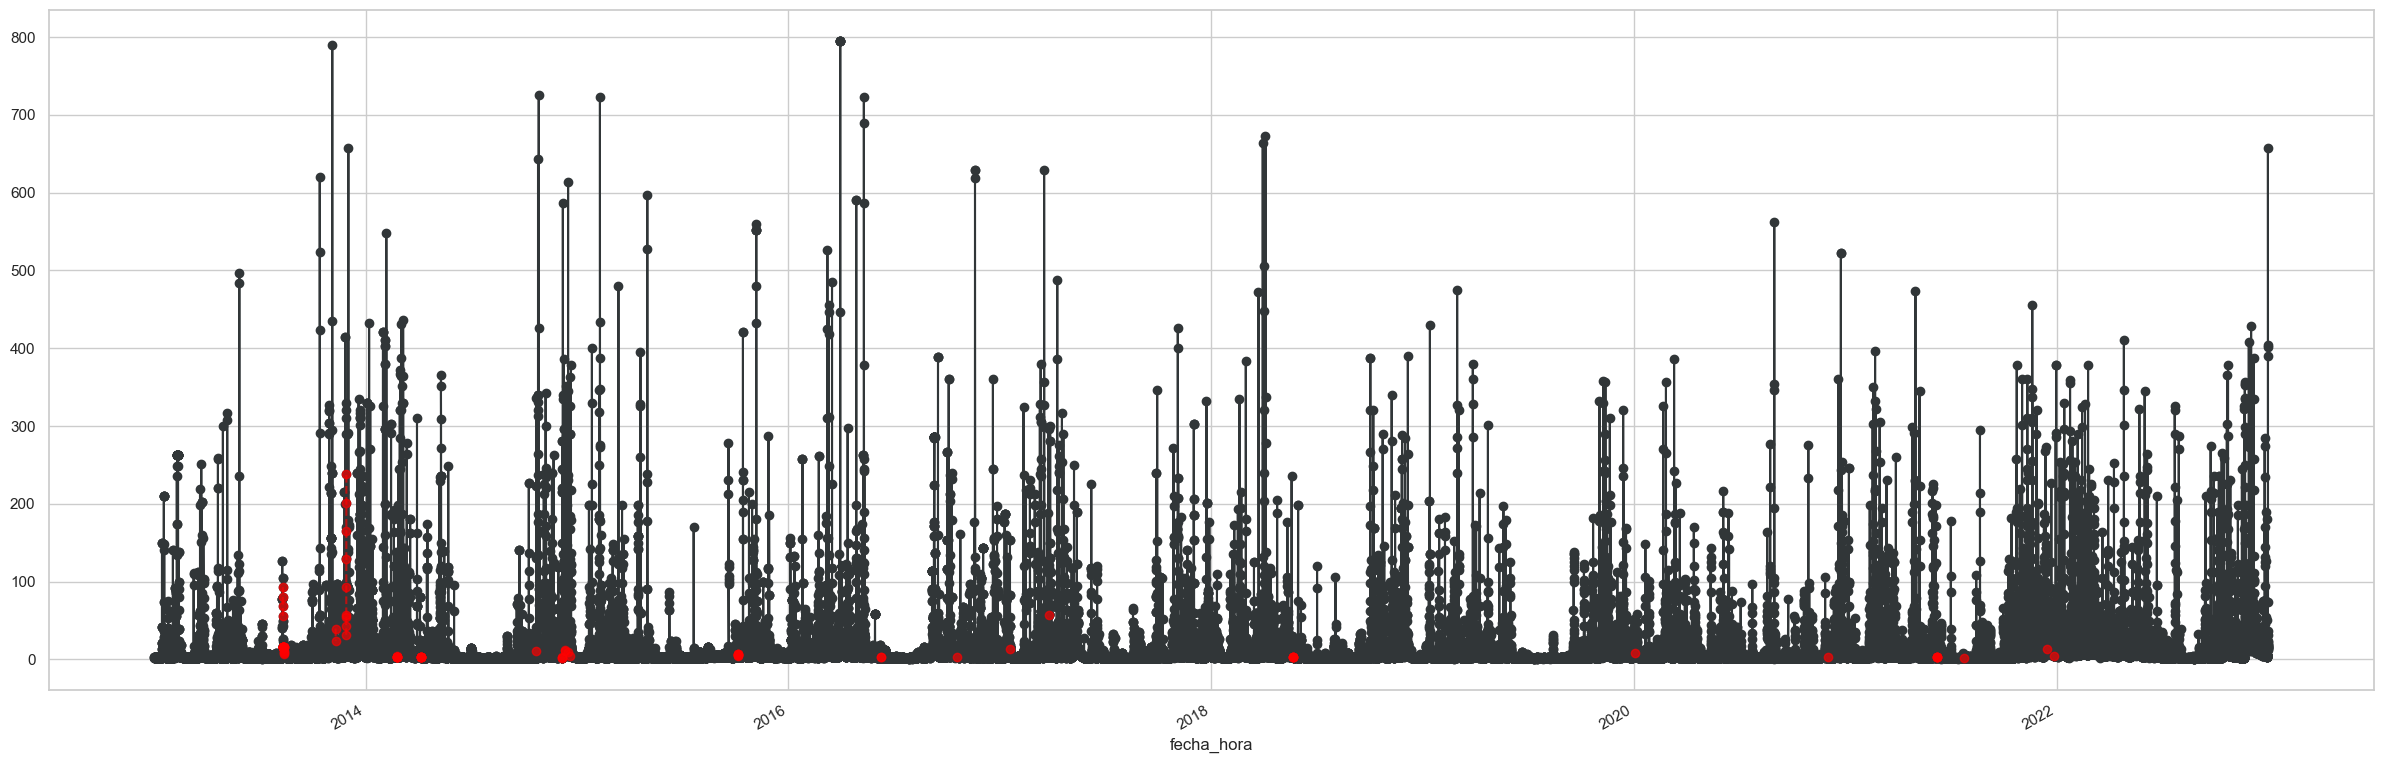

In [89]:
df_imputed = impute_and_plot(df_imputed, 'clasificador_mensual', 'agua_cruda_ntu')

In [90]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86050 entries, 2013-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    86050 non-null  float64
 1   agua_cruda_p_h            86050 non-null  float64
 2   agua_cruda_color          85618 non-null  float64
 3   agua_cruda_ntu            86050 non-null  float64
 4   agua_cruda_alcalinidad    67691 non-null  float64
 5   agua_cruda_conductividad  59501 non-null  float64
 6   coagulante_dosis          43483 non-null  float64
 7   vel_viento                69325 non-null  float64
 8   precipitacion             37761 non-null  float64
 9   temp_humeda               6798 non-null   float64
 10  clasificador_horario      86050 non-null  int64  
 11  clasificador_mensual      86050 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 8.5 MB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

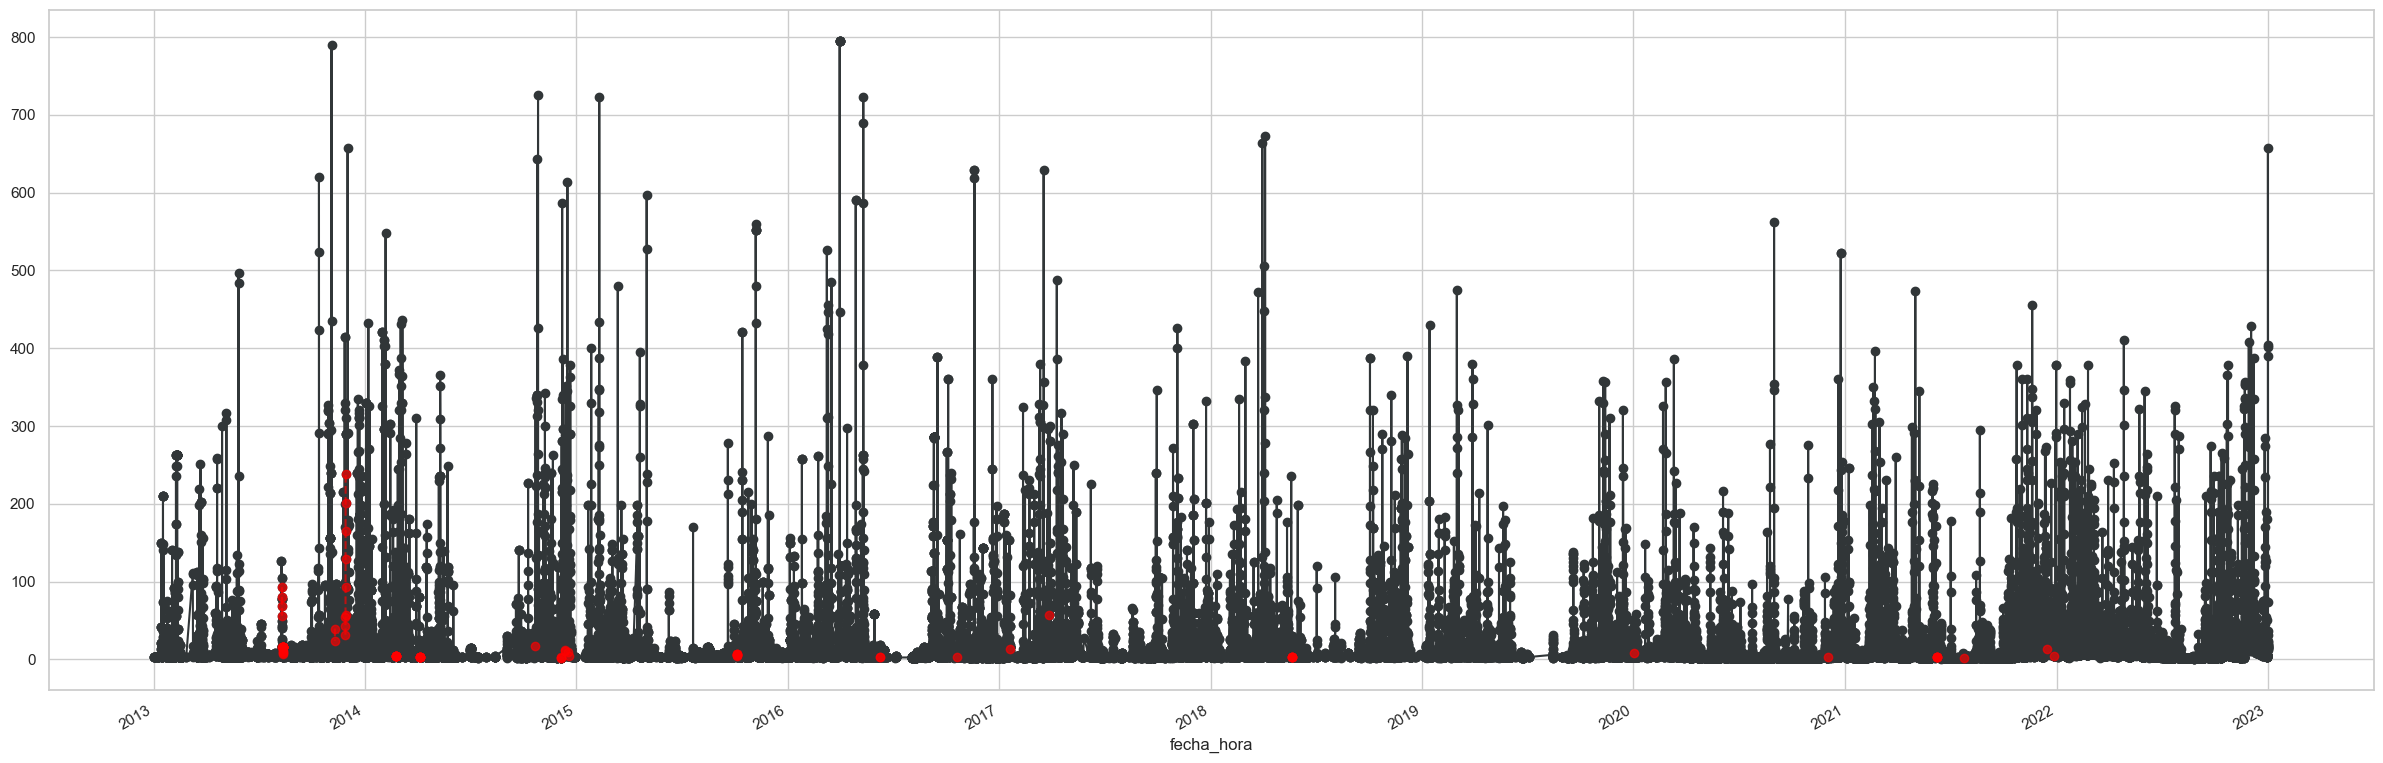

In [91]:
df_imputed_edit = impute_and_plot(df_imputed_edit, 'clasificador_mensual', 'agua_cruda_ntu')

In [92]:
df_imputed_edit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51573 entries, 2013-01-02 12:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51573 non-null  float64
 1   agua_cruda_p_h            51573 non-null  float64
 2   agua_cruda_color          51498 non-null  float64
 3   agua_cruda_ntu            51573 non-null  float64
 4   agua_cruda_alcalinidad    42716 non-null  float64
 5   agua_cruda_conductividad  38055 non-null  float64
 6   coagulante_dosis          43483 non-null  float64
 7   vel_viento                38139 non-null  float64
 8   precipitacion             20662 non-null  float64
 9   temp_humeda               4180 non-null   float64
 10  clasificador_horario      51573 non-null  int64  
 11  clasificador_mensual      51573 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 5.1 MB


**Dataframes a partir del 2017**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

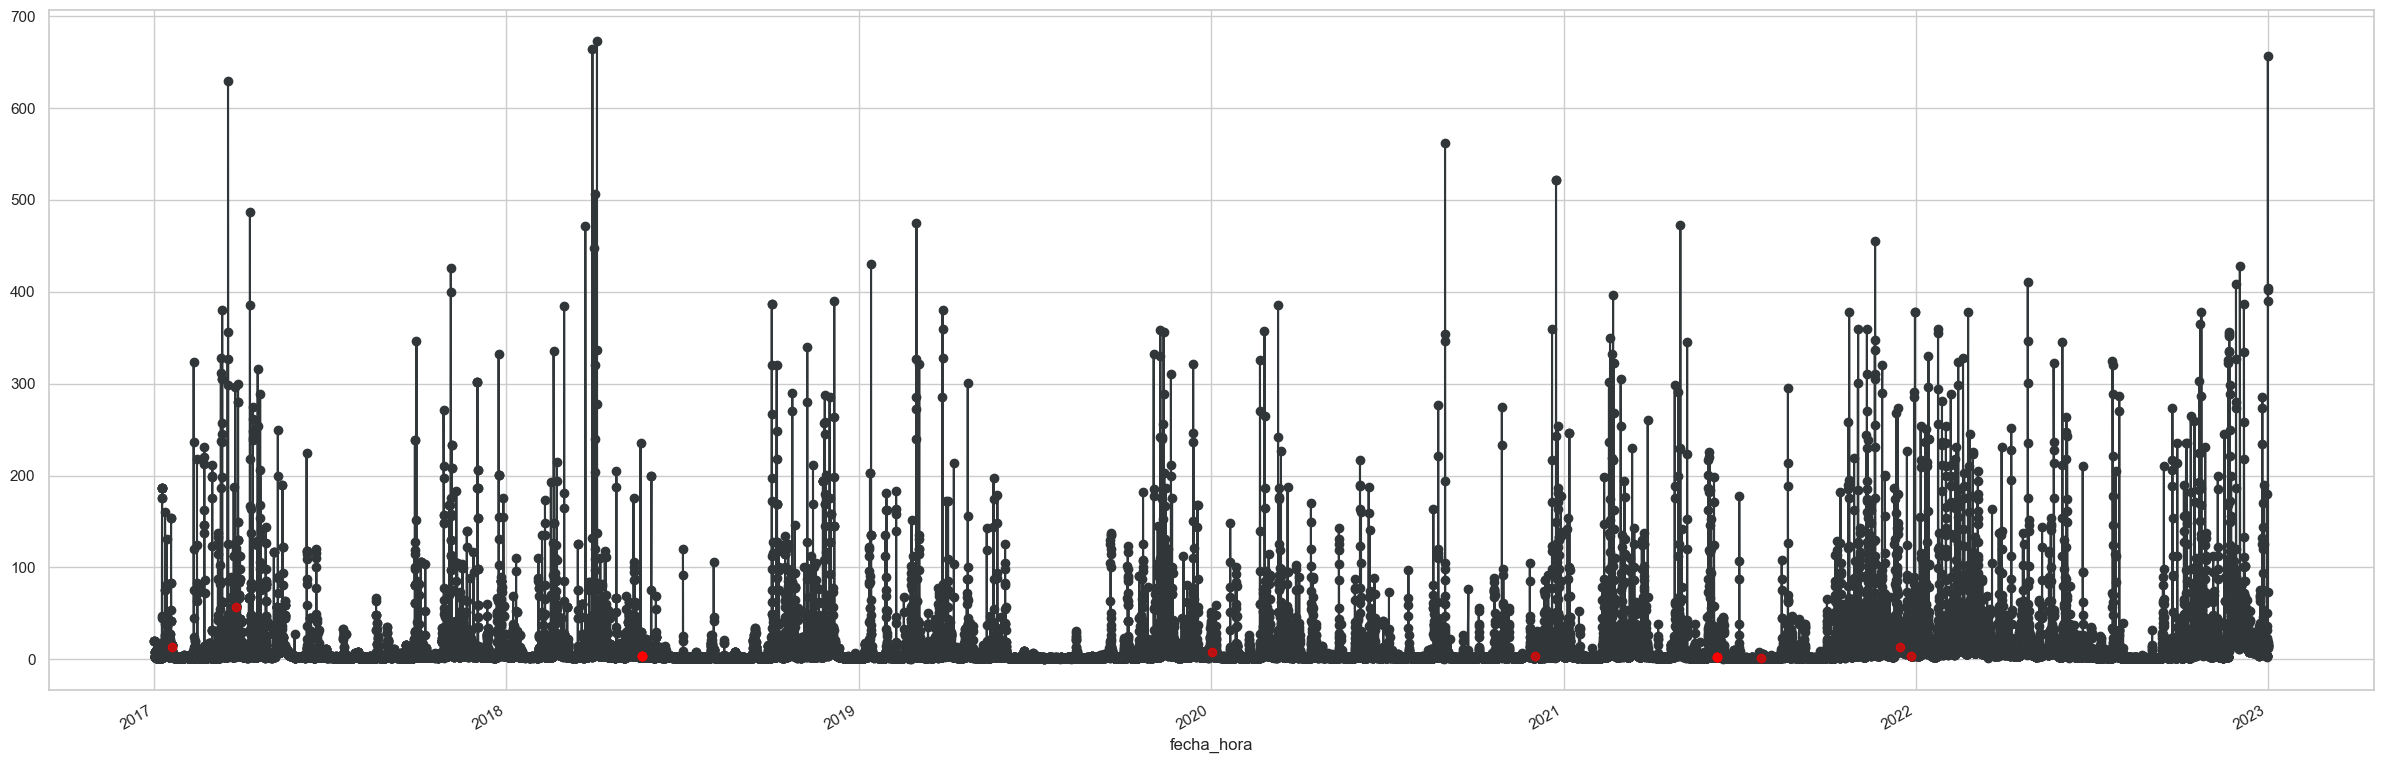

In [93]:
df_imputed_2017 = impute_and_plot(df_imputed_2017, 'clasificador_mensual', 'agua_cruda_ntu')

In [94]:
df_imputed_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51808 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51808 non-null  float64
 1   agua_cruda_p_h            51808 non-null  float64
 2   agua_cruda_color          51808 non-null  float64
 3   agua_cruda_ntu            51808 non-null  float64
 4   agua_cruda_alcalinidad    50800 non-null  float64
 5   agua_cruda_conductividad  50323 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                36884 non-null  float64
 8   precipitacion             36890 non-null  float64
 9   temp_humeda               4912 non-null   float64
 10  clasificador_horario      51808 non-null  int64  
 11  clasificador_mensual      51808 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 5.1 MB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

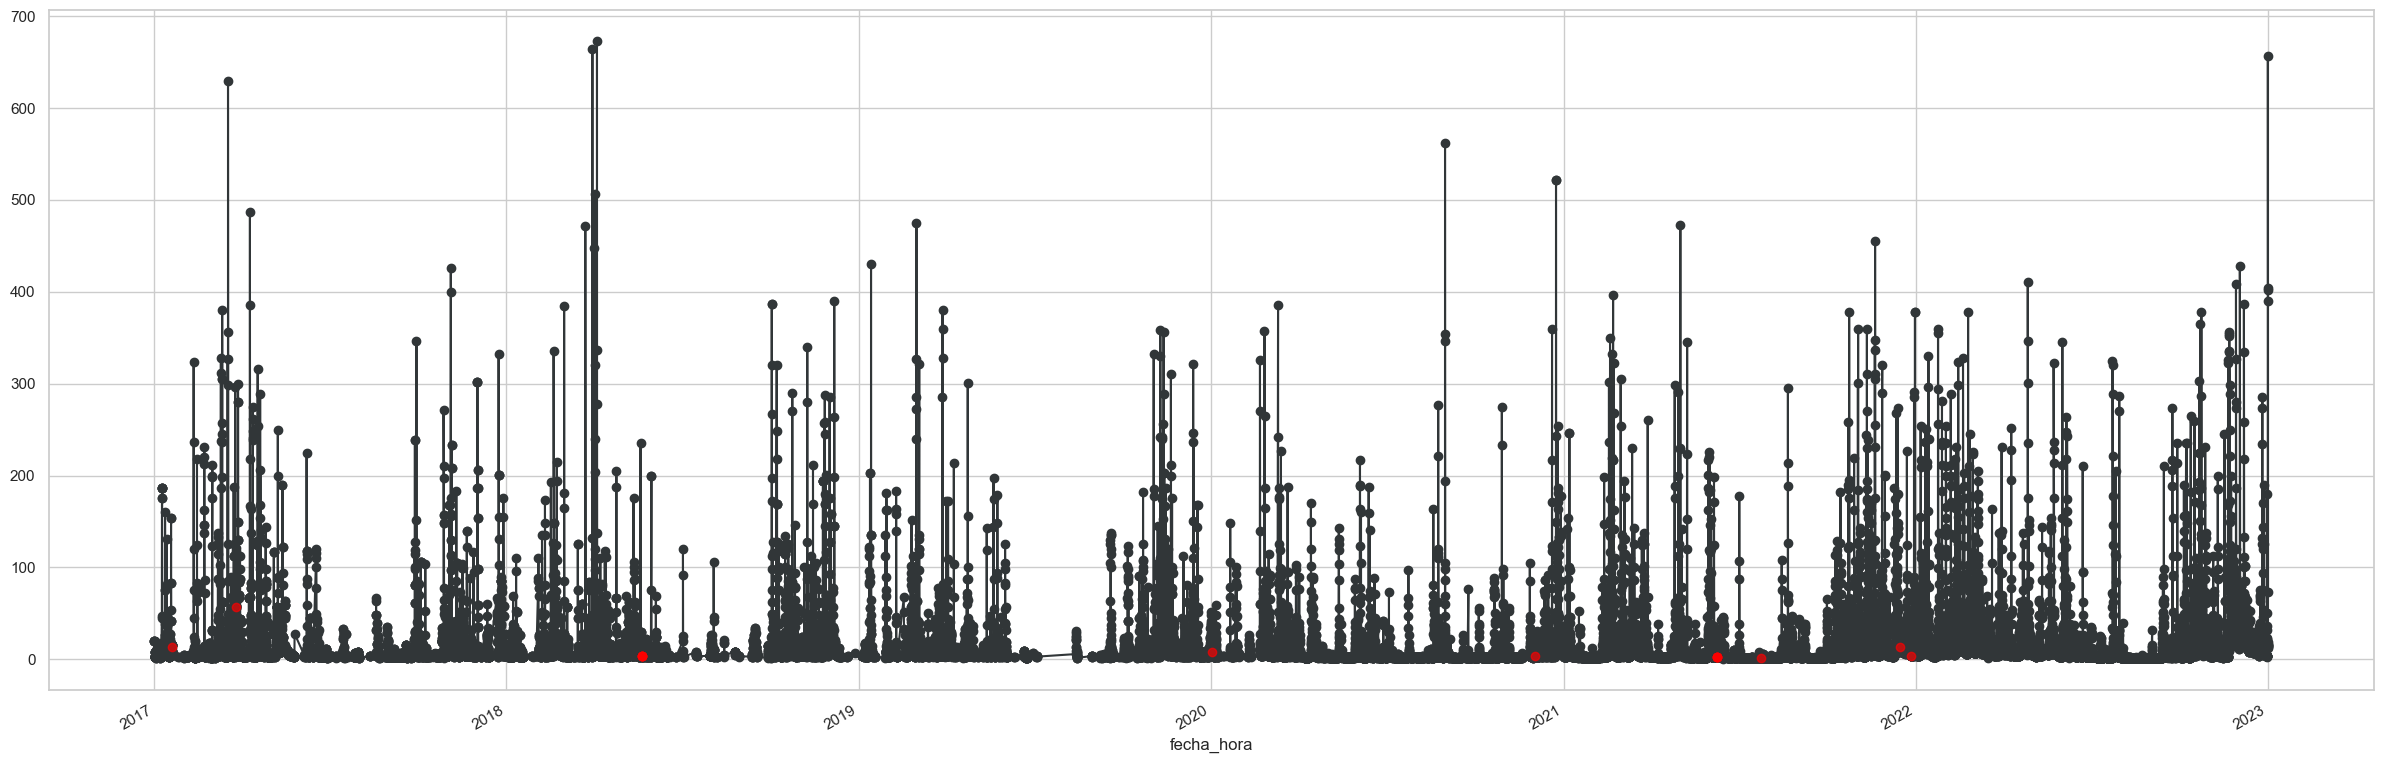

In [95]:
df_imputed_edit_2017 = impute_and_plot(df_imputed_edit_2017, 'clasificador_mensual', 'agua_cruda_ntu')

In [96]:
df_imputed_edit_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32274 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    32274 non-null  float64
 1   agua_cruda_p_h            32274 non-null  float64
 2   agua_cruda_color          32274 non-null  float64
 3   agua_cruda_ntu            32274 non-null  float64
 4   agua_cruda_alcalinidad    31540 non-null  float64
 5   agua_cruda_conductividad  31276 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                19897 non-null  float64
 8   precipitacion             19900 non-null  float64
 9   temp_humeda               3041 non-null   float64
 10  clasificador_horario      32274 non-null  int64  
 11  clasificador_mensual      32274 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 3.2 MB


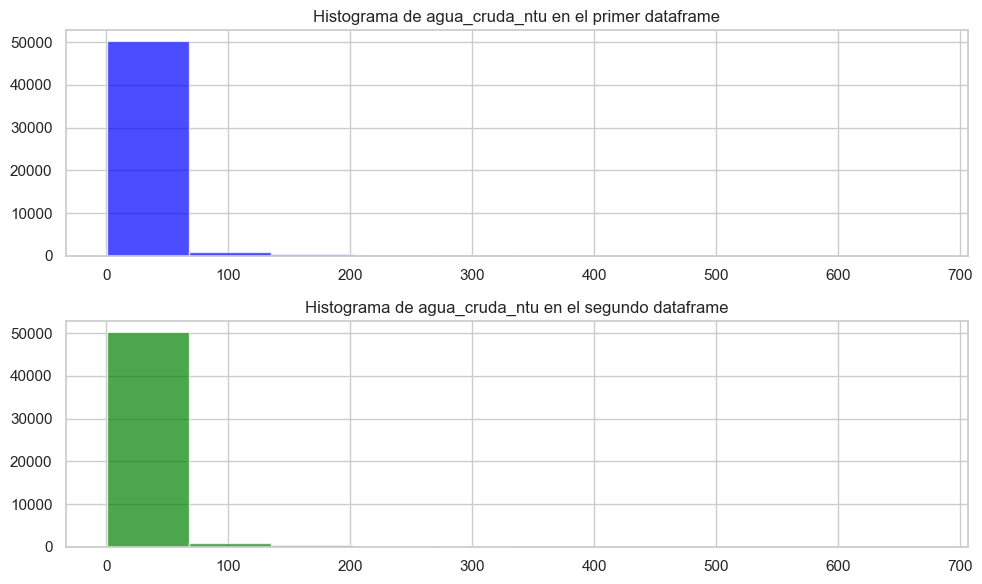

In [97]:
plot_histograms(df_2017, df_imputed_2017, 'agua_cruda_ntu', bins=10)

### AGUA_CRUDA_ALCALINIDAD

**Dataframes a partir del 2017**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

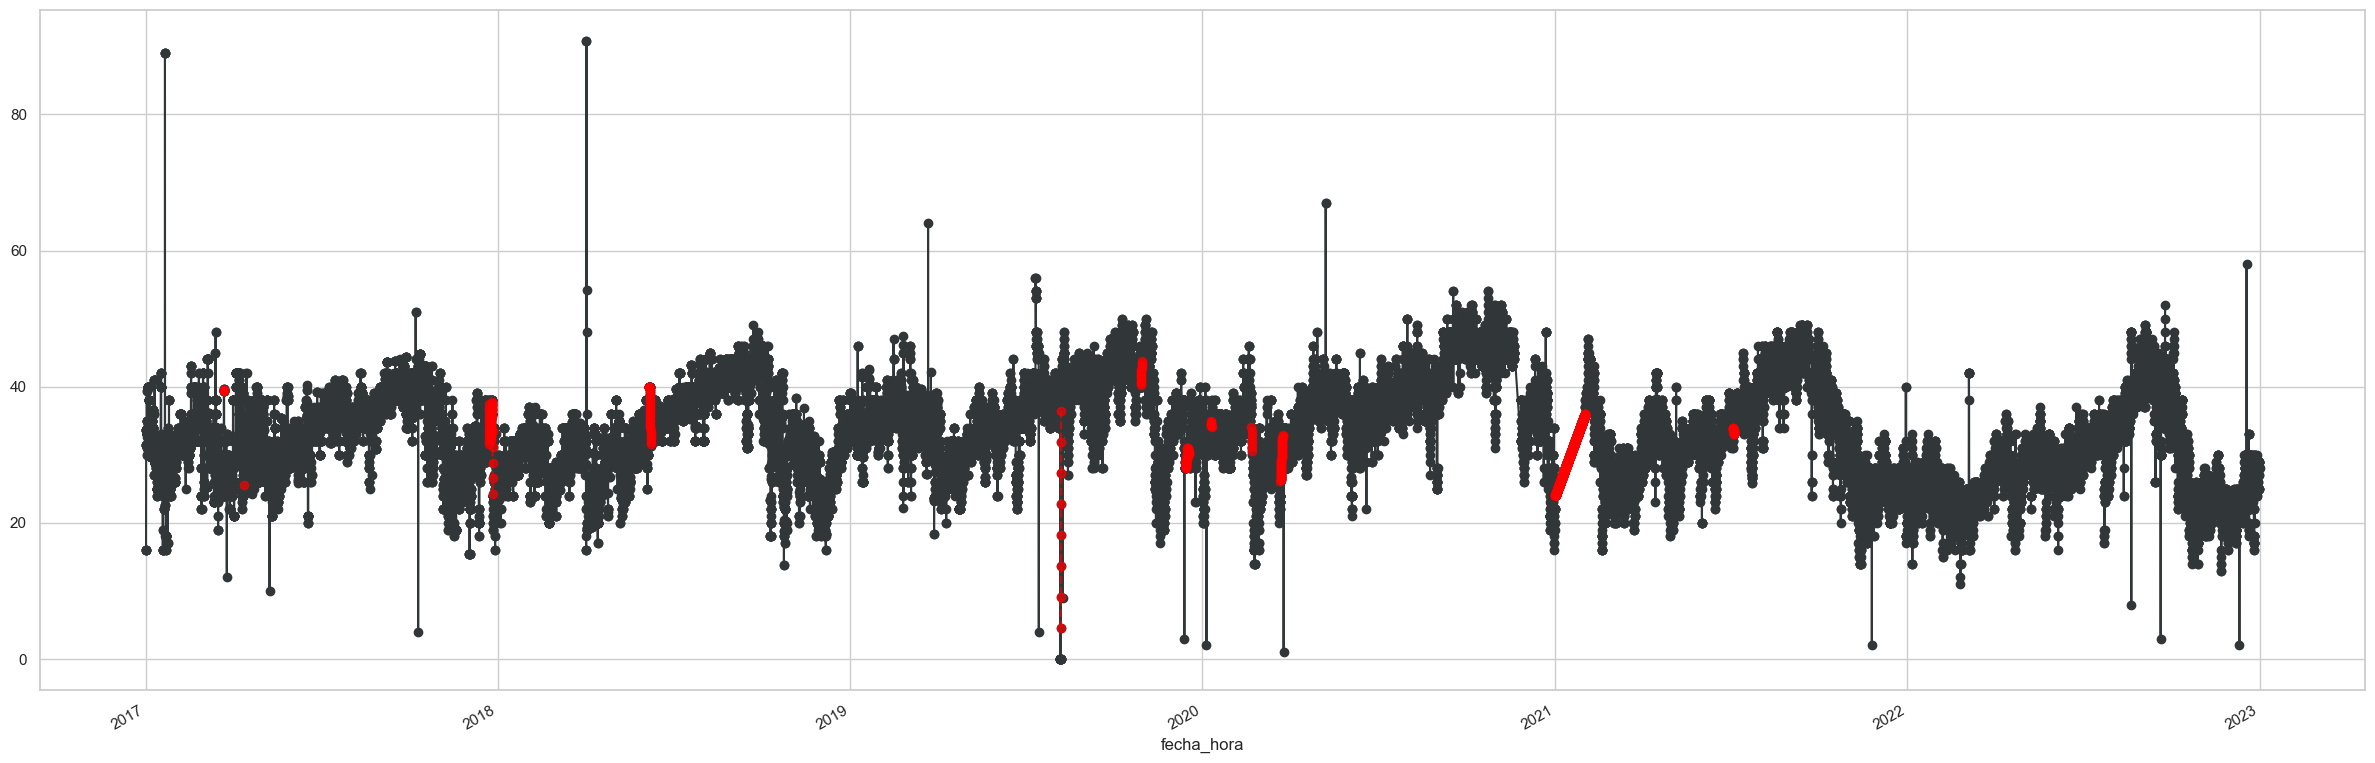

In [98]:
df_imputed_2017 = impute_and_plot(df_imputed_2017, 'clasificador_mensual', 'agua_cruda_alcalinidad')

In [99]:
df_imputed_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51808 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51808 non-null  float64
 1   agua_cruda_p_h            51808 non-null  float64
 2   agua_cruda_color          51808 non-null  float64
 3   agua_cruda_ntu            51808 non-null  float64
 4   agua_cruda_alcalinidad    51808 non-null  float64
 5   agua_cruda_conductividad  50323 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                36884 non-null  float64
 8   precipitacion             36890 non-null  float64
 9   temp_humeda               4912 non-null   float64
 10  clasificador_horario      51808 non-null  int64  
 11  clasificador_mensual      51808 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 5.1 MB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

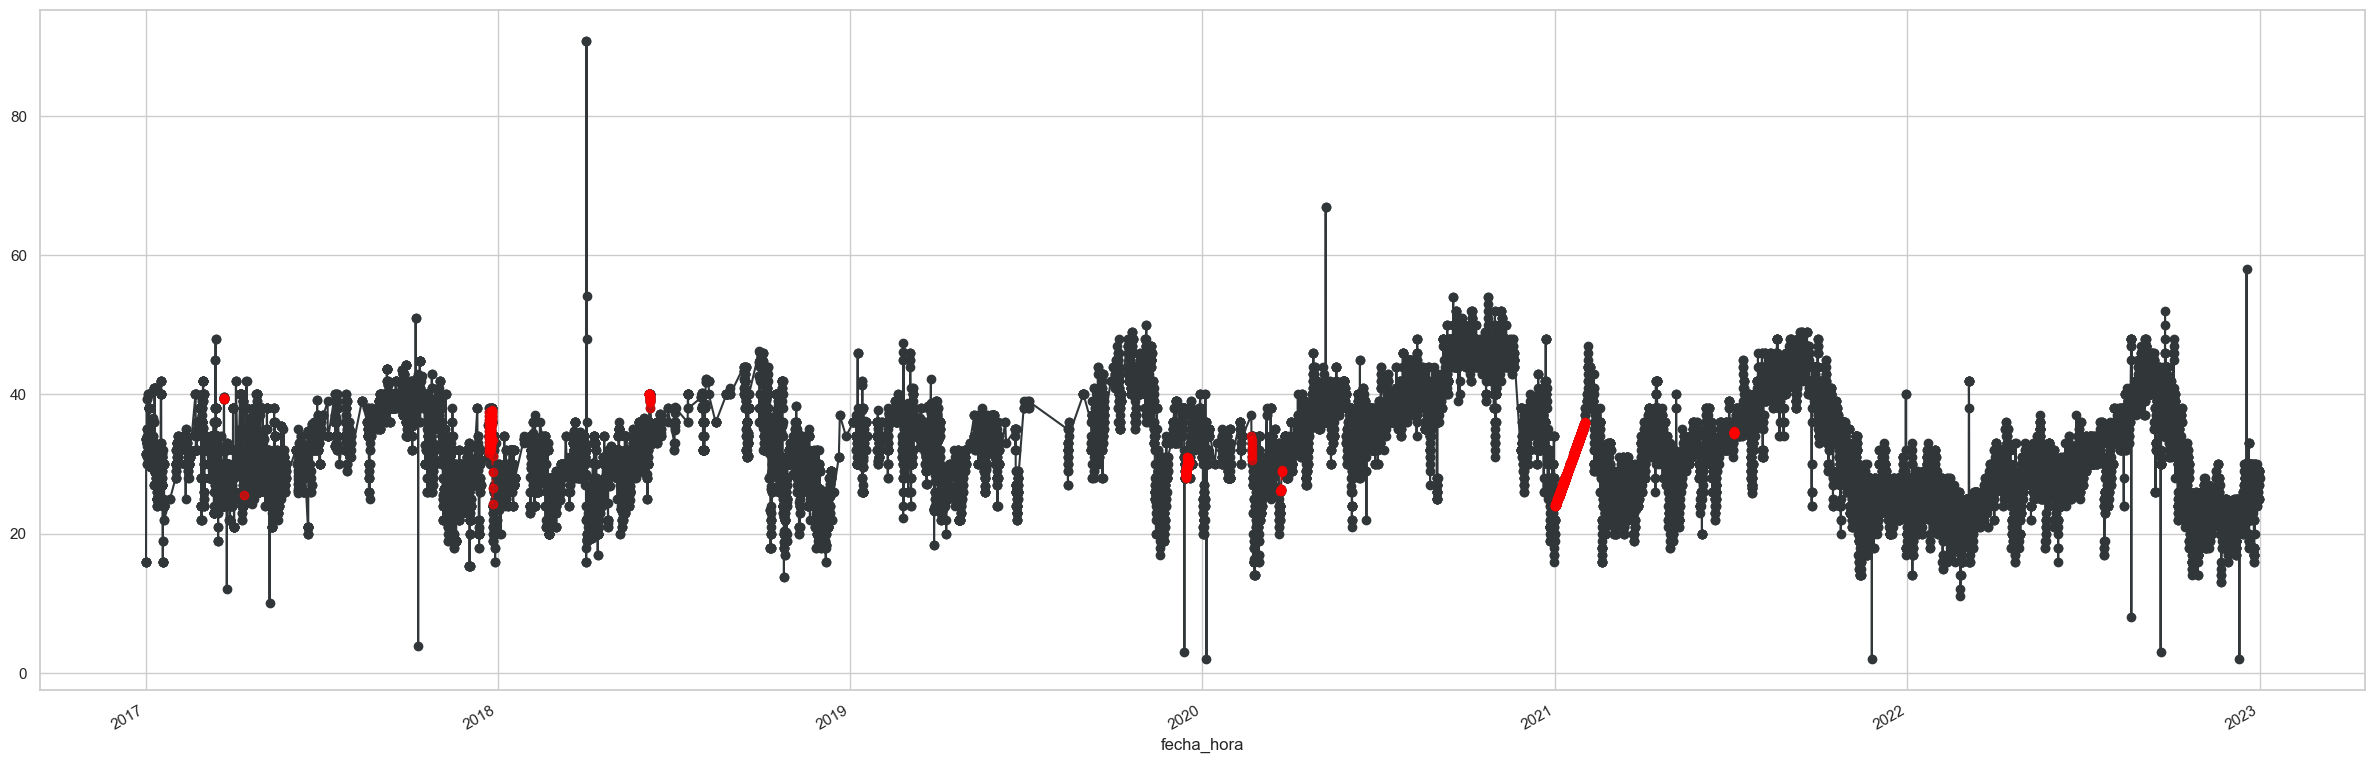

In [100]:
df_imputed_edit_2017 = impute_and_plot(df_imputed_edit_2017, 'clasificador_mensual', 'agua_cruda_alcalinidad')

In [101]:
df_imputed_edit_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32274 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    32274 non-null  float64
 1   agua_cruda_p_h            32274 non-null  float64
 2   agua_cruda_color          32274 non-null  float64
 3   agua_cruda_ntu            32274 non-null  float64
 4   agua_cruda_alcalinidad    32274 non-null  float64
 5   agua_cruda_conductividad  31276 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                19897 non-null  float64
 8   precipitacion             19900 non-null  float64
 9   temp_humeda               3041 non-null   float64
 10  clasificador_horario      32274 non-null  int64  
 11  clasificador_mensual      32274 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 3.2 MB


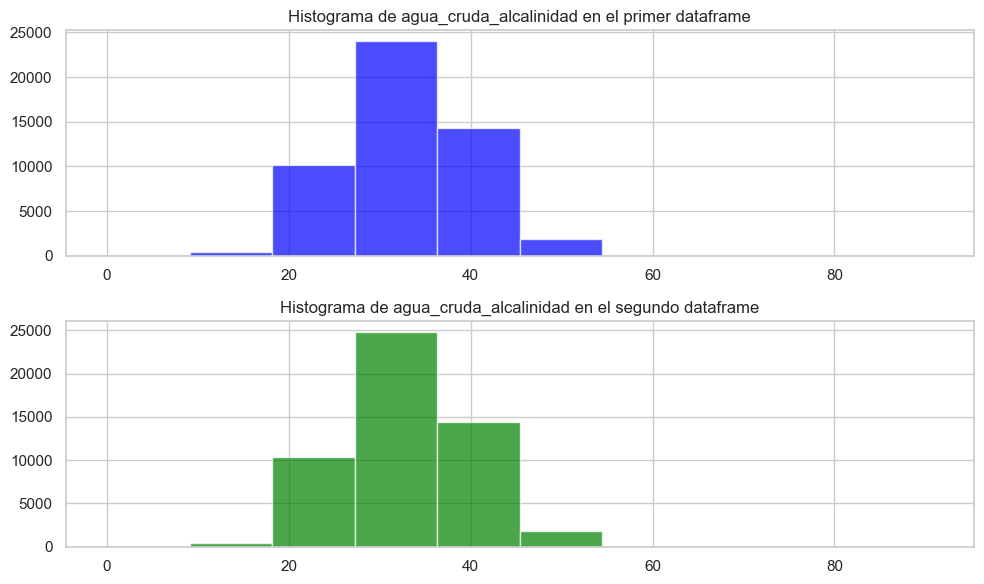

In [102]:
plot_histograms(df_2017, df_imputed_2017, 'agua_cruda_alcalinidad', bins=10)

### AGUA_CRUDA_CONDUCTIVIDAD

**Dataframes a partir del 2017**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

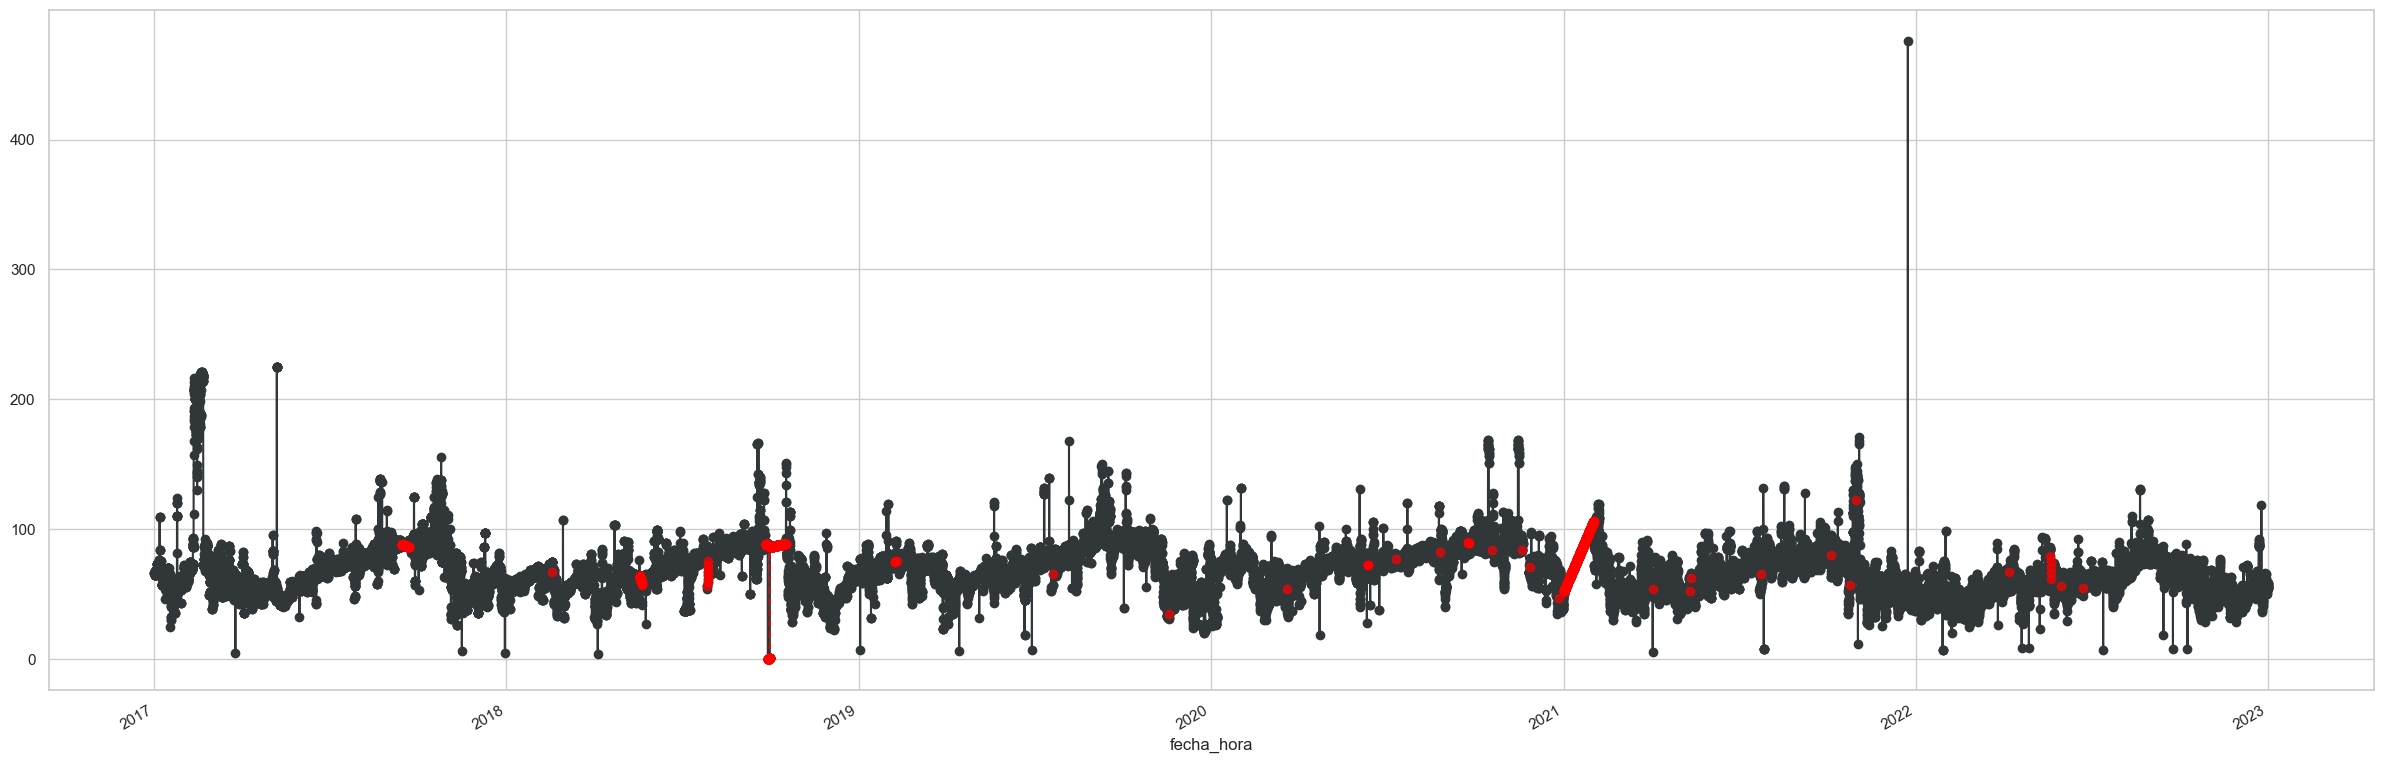

In [103]:
df_imputed_2017 = impute_and_plot(df_imputed_2017, 'clasificador_mensual', 'agua_cruda_conductividad')

In [104]:
df_imputed_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51808 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51808 non-null  float64
 1   agua_cruda_p_h            51808 non-null  float64
 2   agua_cruda_color          51808 non-null  float64
 3   agua_cruda_ntu            51808 non-null  float64
 4   agua_cruda_alcalinidad    51808 non-null  float64
 5   agua_cruda_conductividad  51808 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                36884 non-null  float64
 8   precipitacion             36890 non-null  float64
 9   temp_humeda               4912 non-null   float64
 10  clasificador_horario      51808 non-null  int64  
 11  clasificador_mensual      51808 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 5.1 MB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo[value_col] = df_grupo[value_col].interpolate(method = "time")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_grupo['imputed_values'] = np.where(missing_locs, df_grupo[value_col], np.nan)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5544\3928466274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

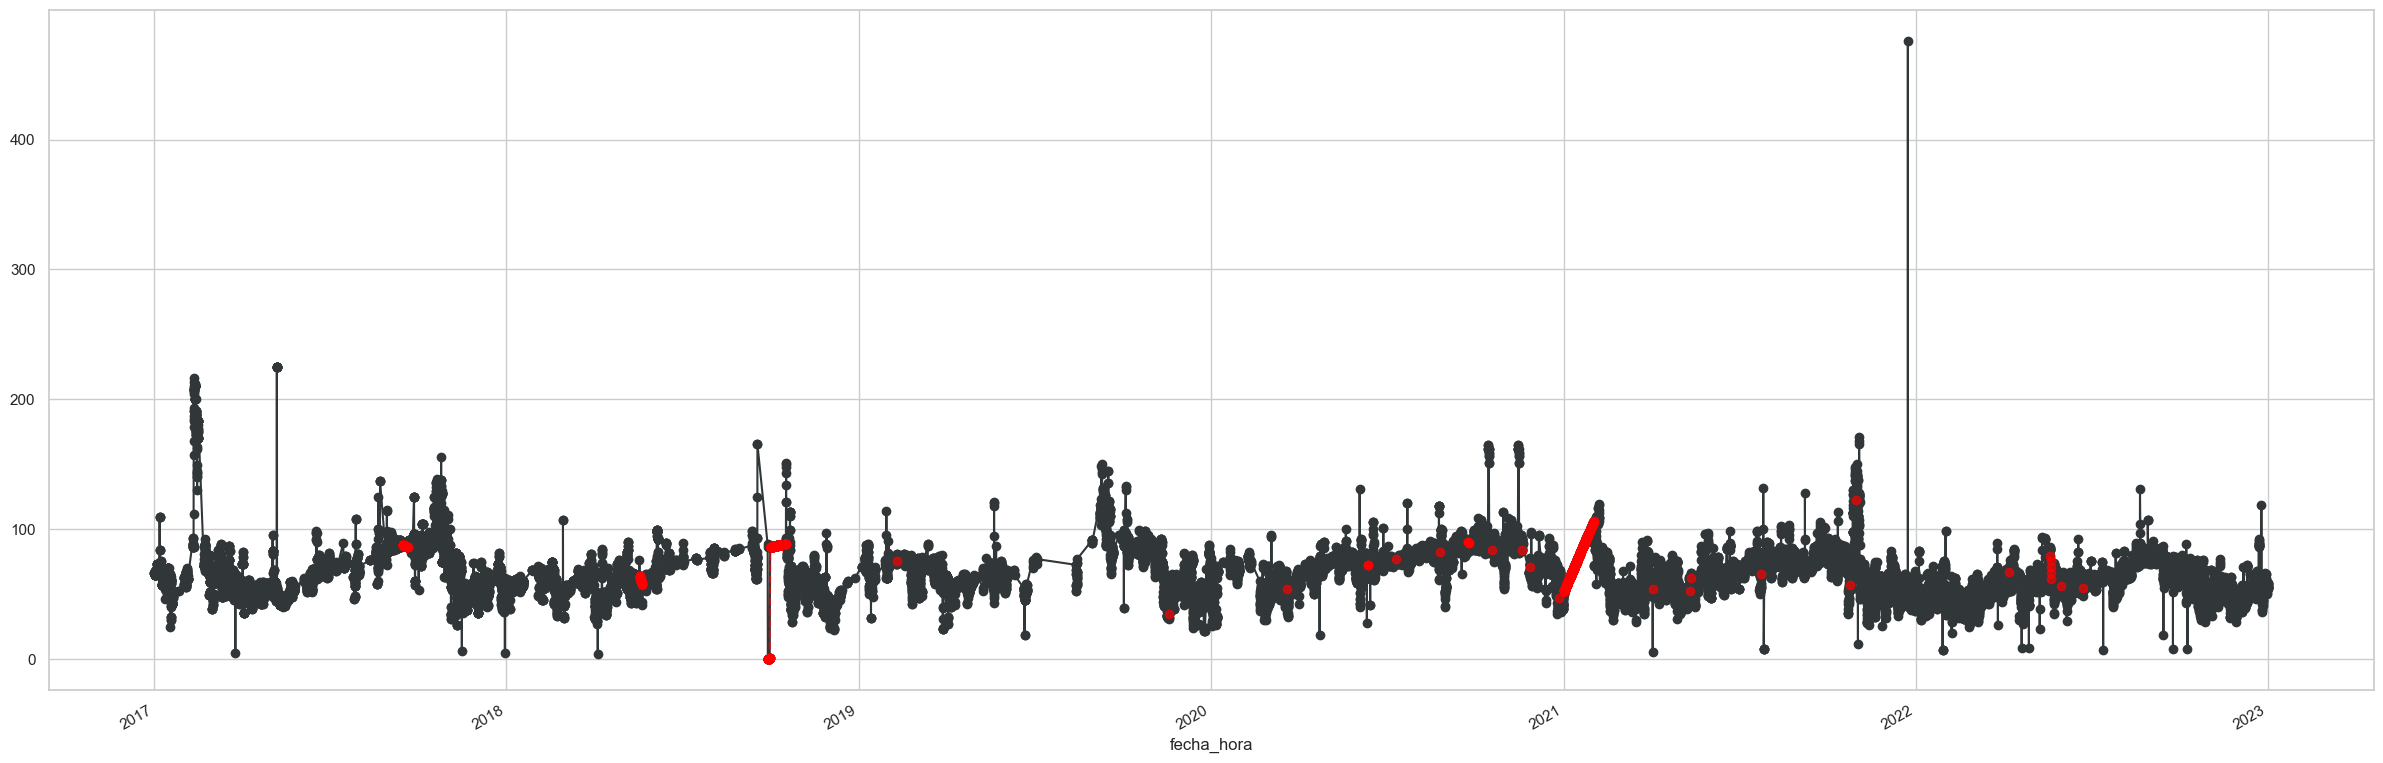

In [105]:
df_imputed_edit_2017 = impute_and_plot(df_imputed_edit_2017, 'clasificador_mensual', 'agua_cruda_conductividad')

In [106]:
df_imputed_edit_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32274 entries, 2017-01-01 01:00:00 to 2023-01-01 00:00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    32274 non-null  float64
 1   agua_cruda_p_h            32274 non-null  float64
 2   agua_cruda_color          32274 non-null  float64
 3   agua_cruda_ntu            32274 non-null  float64
 4   agua_cruda_alcalinidad    32274 non-null  float64
 5   agua_cruda_conductividad  32274 non-null  float64
 6   coagulante_dosis          28844 non-null  float64
 7   vel_viento                19897 non-null  float64
 8   precipitacion             19900 non-null  float64
 9   temp_humeda               3041 non-null   float64
 10  clasificador_horario      32274 non-null  int64  
 11  clasificador_mensual      32274 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 3.2 MB


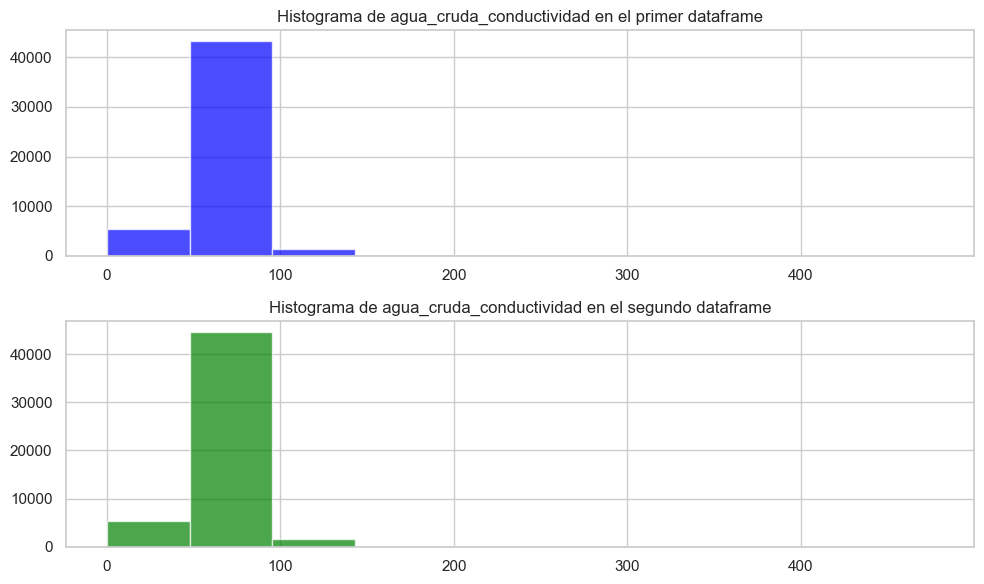

In [107]:
plot_histograms(df_2017, df_imputed_2017, 'agua_cruda_conductividad', bins=10)

### Demás variables

Optaremos por utilizar la imputación por modelos MICE para el resto de las variables, dado el volumen significativo de datos ausentes en ellas. Descartamos los otros métodos de imputación para evitar la introducción de posibles sesgos que podrían surgir con su uso.

In [108]:
from sklearn.impute import IterativeImputer

# Define el modelo de regresión
rf = RandomForestRegressor()

# Define el imputador
imp = IterativeImputer(random_state=0, estimator=rf)

# # Ajusta y transforma los datos
# df_imputed_mice = imp.fit_transform(df_imputed)

# # Convertir el resultado nuevamente a un DataFrame
# df_imputed_mice = pd.DataFrame(df_imputed_mice, columns = df_imputed.columns)
# df_imputed_mice.info()

In [109]:
# plot_histograms(df_imputed, df_imputed_mice, 'coagulante_dosis', bins=10)

In [110]:
# df_imputed_mice.to_csv('../data/dataframe_imputed.csv', sep=',')

In [111]:
# df_imputed_mice.coagulante_dosis.value_counts()

In [112]:
# Ajusta y transforma los datos
df_imputed_edit_mice = imp.fit_transform(df_imputed_edit)

# Convertir el resultado nuevamente a un DataFrame
df_imputed_edit_mice = pd.DataFrame(df_imputed_edit_mice, columns = df_imputed_edit.columns)
df_imputed_edit_mice.info()

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51573 entries, 0 to 51572
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51573 non-null  float64
 1   agua_cruda_p_h            51573 non-null  float64
 2   agua_cruda_color          51573 non-null  float64
 3   agua_cruda_ntu            51573 non-null  float64
 4   agua_cruda_alcalinidad    51573 non-null  float64
 5   agua_cruda_conductividad  51573 non-null  float64
 6   coagulante_dosis          51573 non-null  float64
 7   vel_viento                51573 non-null  float64
 8   precipitacion             51573 non-null  float64
 9   temp_humeda               51573 non-null  float64
 10  clasificador_horario      51573 non-null  float64
 11  clasificador_mensual      51573 non-null  float64
dtypes: float64(12)
memory usage: 4.7 MB


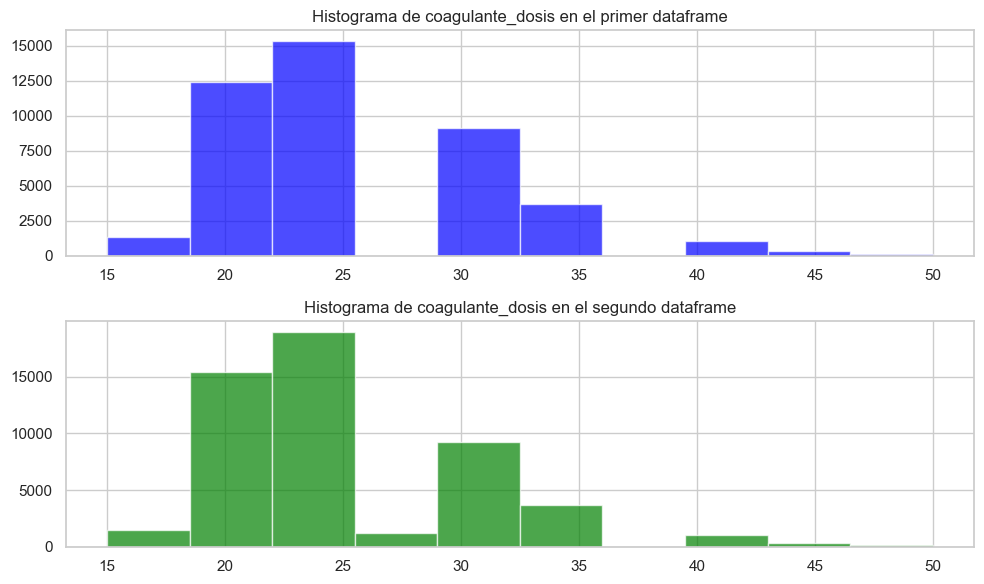

In [113]:
plot_histograms(df_imputed_edit, df_imputed_edit_mice, 'coagulante_dosis', bins=10)

In [114]:
df_imputed_edit_mice.to_csv('../data_edit/dataframe_edit_imputed.csv', sep=',')

In [121]:
# Ajusta y transforma los datos
df_imputed_2017_mice = imp.fit_transform(df_imputed_2017)

# Convertir el resultado nuevamente a un DataFrame
df_imputed_2017_mice = pd.DataFrame(df_imputed_2017_mice, columns = df_imputed_2017.columns)
df_imputed_2017_mice.info()

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51808 entries, 0 to 51807
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    51808 non-null  float64
 1   agua_cruda_p_h            51808 non-null  float64
 2   agua_cruda_color          51808 non-null  float64
 3   agua_cruda_ntu            51808 non-null  float64
 4   agua_cruda_alcalinidad    51808 non-null  float64
 5   agua_cruda_conductividad  51808 non-null  float64
 6   coagulante_dosis          51808 non-null  float64
 7   vel_viento                51808 non-null  float64
 8   precipitacion             51808 non-null  float64
 9   temp_humeda               51808 non-null  float64
 10  clasificador_horario      51808 non-null  float64
 11  clasificador_mensual      51808 non-null  float64
dtypes: float64(12)
memory usage: 4.7 MB


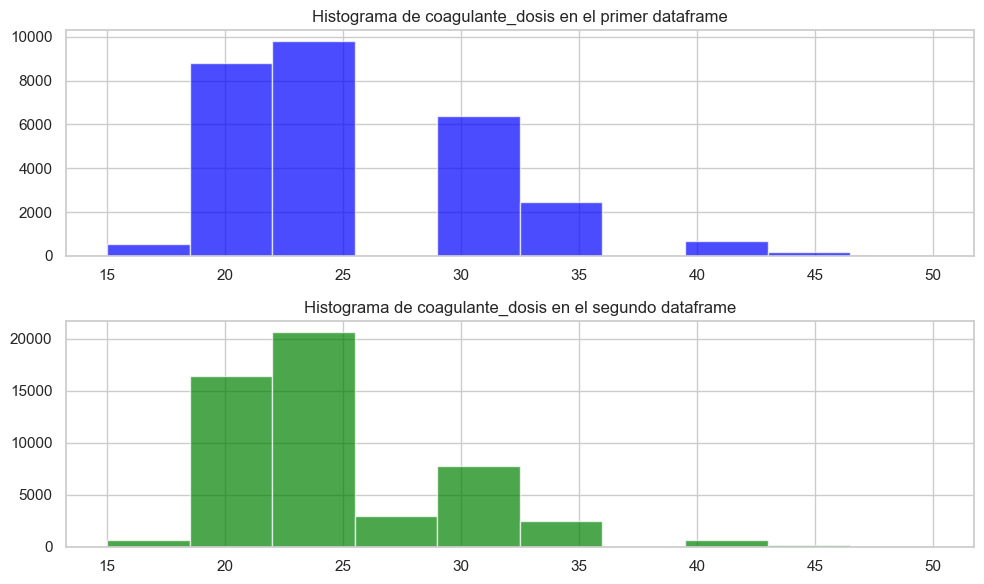

In [122]:
plot_histograms(df_imputed_2017, df_imputed_2017_mice, 'coagulante_dosis', bins=10)

In [124]:
df_imputed_2017_mice.to_csv('../data/dataframe_2017_imputed.csv', sep=',')

In [125]:
# Ajusta y transforma los datos
df_imputed_edit_2017_mice = imp.fit_transform(df_imputed_edit_2017)

# Convertir el resultado nuevamente a un DataFrame
df_imputed_edit_2017_mice = pd.DataFrame(df_imputed_edit_2017_mice, columns = df_imputed_edit_2017.columns)
df_imputed_edit_2017_mice.info()

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32274 entries, 0 to 32273
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   caudal                    32274 non-null  float64
 1   agua_cruda_p_h            32274 non-null  float64
 2   agua_cruda_color          32274 non-null  float64
 3   agua_cruda_ntu            32274 non-null  float64
 4   agua_cruda_alcalinidad    32274 non-null  float64
 5   agua_cruda_conductividad  32274 non-null  float64
 6   coagulante_dosis          32274 non-null  float64
 7   vel_viento                32274 non-null  float64
 8   precipitacion             32274 non-null  float64
 9   temp_humeda               32274 non-null  float64
 10  clasificador_horario      32274 non-null  float64
 11  clasificador_mensual      32274 non-null  float64
dtypes: float64(12)
memory usage: 3.0 MB


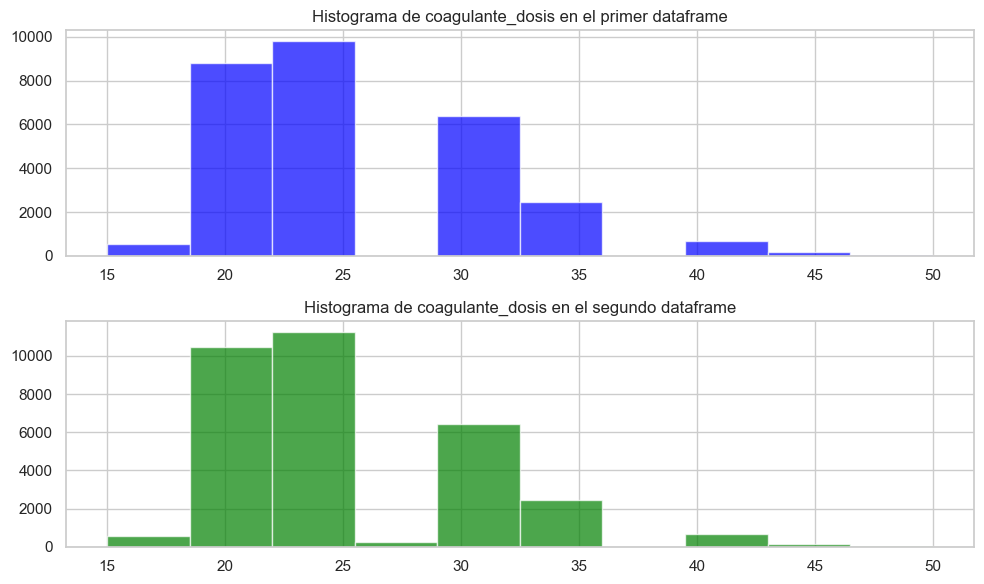

In [126]:
plot_histograms(df_imputed_edit_2017, df_imputed_edit_2017_mice, 'coagulante_dosis', bins=10)

In [127]:
df_imputed_edit_2017_mice.to_csv('../data_edit/dataframe_2017_edit_imputed.csv', sep=',')